In [1]:
import pandas as pd
import os
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import display, Markdown
from tabulate import tabulate

import sys
sys.path.append('../')

from evalutils.roc import get_bootstrapped_roc_ci_curves
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from utilities import data, roc, threshold

## directory where results are
CHANSEY_ROOT = "W:"
EXPERIMENT_DIR = f"{CHANSEY_ROOT}/experiments/lung-malignancy-fairness-shaurya"
NLST_PREDS = f"{EXPERIMENT_DIR}/nlst"

TEAMS_DIR = "C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results"
NLST_PREDS = f"{TEAMS_DIR}/nlst" ## Comment out if not using Teams backup (aka Chansey is up :)
RESULTS_DIR = f"{TEAMS_DIR}/fairness-analysis-results"
FIG_DIR = f"{TEAMS_DIR}/figs"
TAB_DIR = f"{TEAMS_DIR}/tables"

In [2]:
COL_TO_MODEL = {
    "DL_cal": "Venkadesh",
    "Ensemble_Kiran_cal": "Venkadesh", ## DLCST
    "thijmen_mean_cal": "De Haas Combined", ## DLCST
    "Thijmen_mean_cal": "De Haas Combined",
    "Thijmen_local_cal": "De Haas Local",
    "Thijmen_global_hidden_cal": "De Haas Global",
    "Thijmen_global_show_cal": "De Haas Global (Shown Nodule)",
    "sybil_year1": "Sybil (Year 1)",
    "PanCan2b": "PanCan2b",
}

In [3]:
nlst_preds_nodule = pd.read_csv(f"{NLST_PREDS}/nlst_demov4_allmodels_cal.csv")
nlst_preds_nodule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Columns: 131 entries, PatientID to SliceCount
dtypes: bool(27), float64(86), int64(12), object(6)
memory usage: 13.2+ MB


In [4]:
with open(f'{NLST_PREDS}/nlst_demo_v4_cols.json') as json_data:
    nlst_democols_og = json.load(json_data)
    json_data.close()

nlst_democols_og

{'num': {'demo': ['BMI', 'Age', 'height', 'weight'],
  'smoke': ['smokeage', 'smokeday', 'smokeyr', 'pkyr'],
  'nodule': ['CoordX', 'CoordZ', 'CoordY', 'Mean_Entropy_Kiran'],
  'other': ['NoduleCounts', 'Diameter_mm', 'SliceCount']},
 'cat': {'demo': ['Overweight',
   'educat',
   'Gender',
   'Married',
   'HighSchoolPlus',
   'NonHispanicWhite',
   'Unfinished_ed',
   'WhiteOrBlack',
   'marital',
   'ethnic',
   'race'],
  'smoke': ['smokelive', 'cigar', 'cigsmok', 'smokework', 'pipe'],
  'work': ['wrkbaki',
   'wrkfoun',
   'wrkchem',
   'wrkasbe',
   'wrkfire',
   'wrksand',
   'wrkfarm',
   'wrkcoal',
   'wrkpain',
   'wrkweld',
   'wrkflou',
   'wrkbutc',
   'wrkhard',
   'wrkcott'],
  'disease': ['diagasbe',
   'diagchas',
   'diagpneu',
   'diagstro',
   'diagemph',
   'diagbron',
   'diagsili',
   'diagsarc',
   'diaghear',
   'diagdiab',
   'diagadas',
   'diagcopd',
   'diagfibr',
   'diagtube',
   'diaghype',
   'diagchro'],
  'canchist': ['canckidn',
   'cancphar',
   'ca

### Check skew numerical cols (Mean vs. Median)

BMI


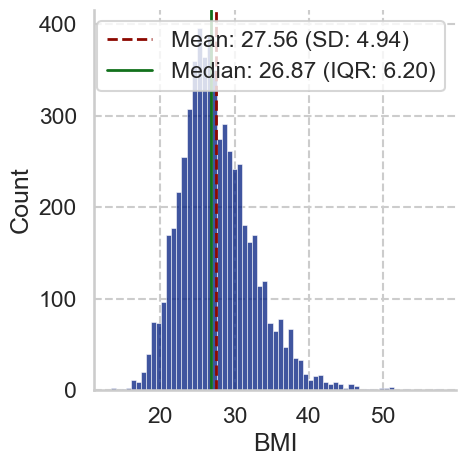

Age


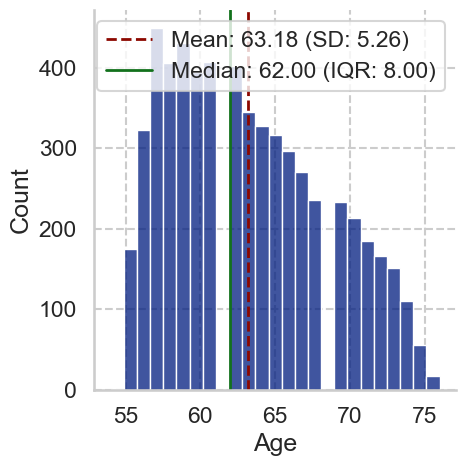

height


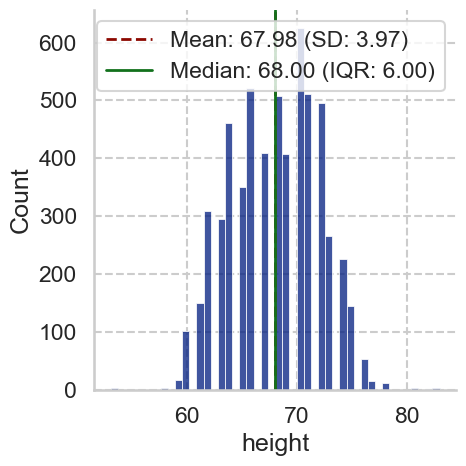

weight


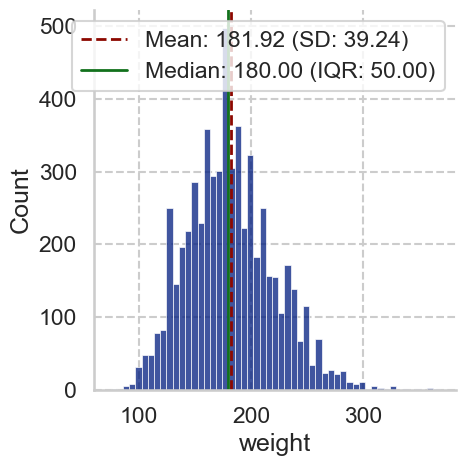

smokeage


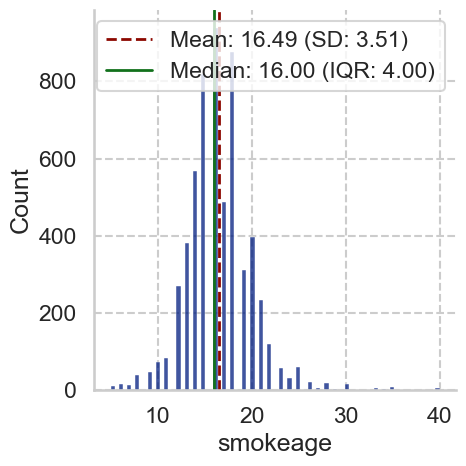

smokeday


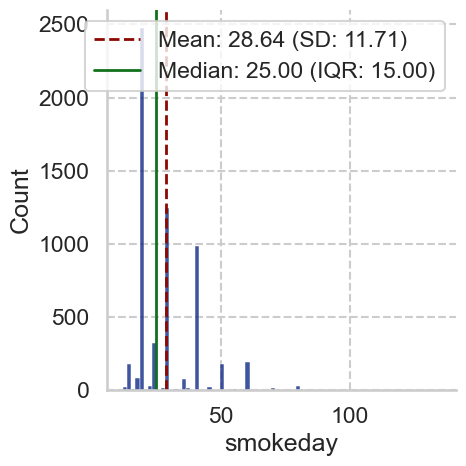

smokeyr


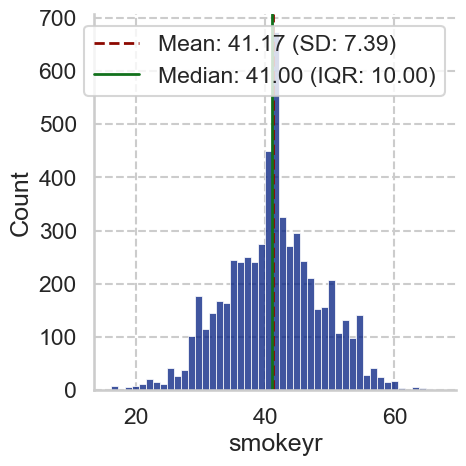

pkyr


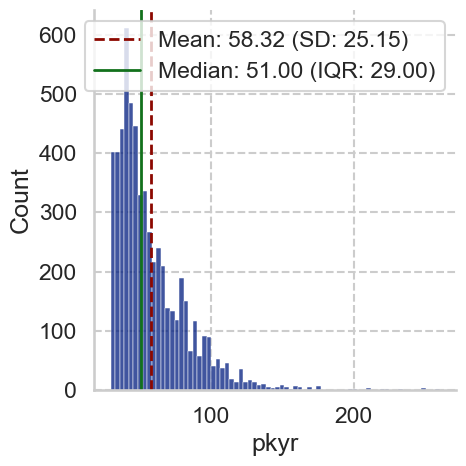

NoduleCounts


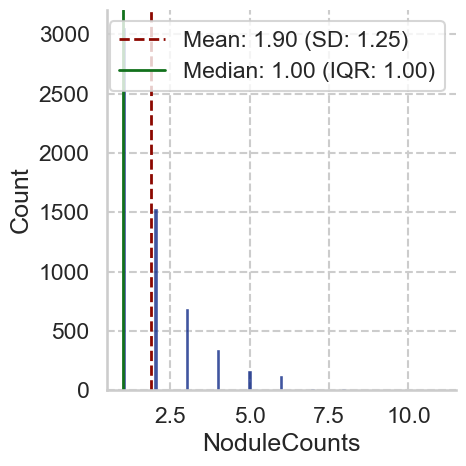

Diameter_mm


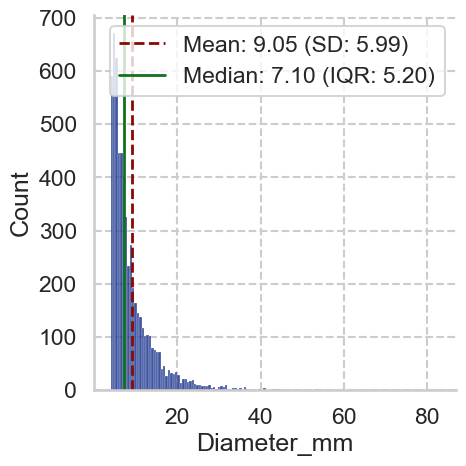

SliceCount


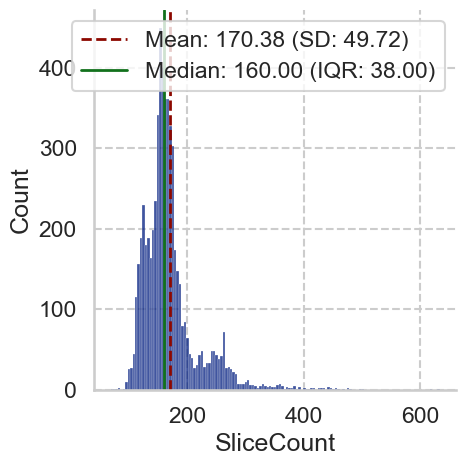

In [5]:
nlst_scan_test, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=False, bin_num=False)
for category in nlst_democols_og['num']:
    if category == 'nodule':
        continue
    for col in nlst_democols_og['num'][category]:
        print(col)
        sns.displot(nlst_scan_test, x=col)
        # Calculate mean and median
        mean = np.nanmean(nlst_scan_test[col])
        median = np.nanmedian(nlst_scan_test[col])
        std = np.nanstd(nlst_scan_test[col])
        iqr = nlst_scan_test[col].quantile(0.75) - nlst_scan_test[col].quantile(0.25)

        # Add vertical lines for mean and median
        plt.axvline(mean, color='r', linestyle='--', label=f'Mean: {mean:.2f} (SD: {std:.2f})')
        plt.axvline(median, color='g', linestyle='-', label=f'Median: {median:.2f} (IQR: {iqr:.2f})')

        # Add a legend
        plt.legend()
        plt.show()

# Materials

## Demographic characteristics of the NLST validation sets (n=5911 scans, n=1172 scans).

In [6]:
nlst_5911, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=True, bin_num=False)
nlst_1172, nlst_democols, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=True, sybil=True, pretty=True, bin_num=False)
len(nlst_5911), len(nlst_1172)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:473: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:473: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


(5911, 1172)

In [7]:
nlstval_full_mal = nlst_5911.query('label == 1')
nlstval_full_ben = nlst_5911.query('label == 0')
print('full:', len(nlstval_full_ben), 'ben', len(nlstval_full_mal), 'mal')

nlstval_some_mal = nlst_1172.query('label == 1')
nlstval_some_ben = nlst_1172.query('label == 0')
print('some:', len(nlstval_some_ben), 'ben', len(nlstval_some_mal), 'mal')

full: 5330 ben 581 mal
some: 1045 ben 127 mal


In [8]:
validation_sets = {
    "Full (malignant)": nlstval_full_mal,
    "Full (benign)": nlstval_full_ben,
    # "Full (all)": nlst_5911,
    "Partial (malignant)": nlstval_some_mal,
    "Partial (benign)": nlstval_some_ben,
    # "Partial (all)": nlst_1172,
}

In [9]:
cat_df0 = data.combine_diff_dfs(nlst_democols['cat'], data.diffs_category_prevalence, validation_sets)
cat_df = cat_df0.copy(deep=True)
for s in validation_sets:
    cat_df[f"{s}_info"] = cat_df.apply(lambda x: f'{0 if np.isnan(x[f"{s}_freq"]) else int(x[f"{s}_freq"])} ({0 if np.isnan(x[f"{s}_norm"]) else np.around(x[f"{s}_norm"], 1)})', axis=1)

cat_df = cat_df[['category', 'attribute', 'value'] + [f"{s}_info" for s in validation_sets]].dropna(axis=0)
cat_df = cat_df.set_index(pd.MultiIndex.from_frame(cat_df[['category', 'attribute', 'value']]))[[f"{s}_info" for s in validation_sets]]

In [10]:
MIN_MAL = 15
attribute_valid_subgroups_1172 = cat_df0[cat_df0['Partial (malignant)_freq'] > 15][['attribute', 'value', 'Partial (malignant)_freq']].groupby('attribute')['value'].count()
invalid_attributes_1172 = list(attribute_valid_subgroups_1172[attribute_valid_subgroups_1172 < 2].index)

attribute_valid_subgroups_5911 = cat_df0[cat_df0['Full (malignant)_freq'] > 15][['attribute', 'value', 'Partial (malignant)_freq']].groupby('attribute')['value'].count()
invalid_attributes_5911 = list(attribute_valid_subgroups_5911[attribute_valid_subgroups_5911 < 2].index)

total_categorical_columns = cat_df0['attribute'].nunique()
print("invalid:", len(invalid_attributes_5911), len(invalid_attributes_1172))
print("valid:", total_categorical_columns - len(invalid_attributes_5911), total_categorical_columns - len(invalid_attributes_1172))

invalid: 36 59
valid: 49 26


In [11]:
num_df = data.combine_diff_dfs(nlst_democols['num'], data.diffs_numerical_means, validation_sets)
num_df = num_df[(num_df['value'].isin(['Median (IQR)']))][['category', 'attribute', 'value'] + [f"{s}" for s in validation_sets]].dropna(axis=0)
num_df = num_df.set_index(pd.MultiIndex.from_frame(num_df[['category', 'attribute', 'value']]))[[f"{s}" for s in validation_sets]]

In [12]:
multicol_idx = pd.MultiIndex.from_tuples([
    ('Full Dataset (n=5911 Scans)', 'Malignant (n=581)'),
    ('Full Dataset (n=5911 Scans)', 'Benign (n=5330)'),
    # ('Full Dataset (n=5911 Scans)', 'Total'),
    ('Partial Dataset (n=1172 Scans)', 'Malignant (n=127)'),
    ('Partial Dataset (n=1172 Scans)', 'Benign (n=1045)'),
    # ('Partial Dataset (n=1172 Scans)', 'Total'),
])

cat_df.columns = multicol_idx
num_df.columns = multicol_idx

In [13]:
df_out = pd.concat([cat_df, num_df], axis=0)
df_out

Full Dataset (n=5911 Scans)  \
                                                                Malignant (n=581)   
category     attribute              value                                           
Demographics BMI Class              25+                                372 (64.0)   
                                    < 25                               209 (36.0)   
             Education Status       8th grade or less                     9 (1.5)   
                                    9th-11th grade                       32 (5.5)   
                                    Associate Degree                   126 (21.7)   
...                                                                           ...   
Smoking      Total Years of Smoking Median (IQR)                          44 (10)   
             Pack-Years             Median (IQR)                          56 (39)   
Other        Nodules Per Scan       Median (IQR)                            2 (2)   
             Diameter (mm)          Median (IQR)                           12 (9)   
             Slices In Scan         Median (IQR)                         162 (40)   

                                                                       \
                                                      Benign (n=5330)   
category     attribute              value                               
Demographics BMI Class              25+                   3640 (68.3)   
                                    < 25                  1690 (31.7)   
             Education Status       8th grade or less       102 (1.9)   
                                    9th-11th grade          258 (4.8)   
                                    Associate Degree      1175 (22.0)   
...                                                               ...   
Smoking      Total Years of Smoking Median (IQR)              41 (10)   
             Pack-Years             Median (IQR)              50 (28)   
Other        Nodules Per Scan       Median (IQR)                1 (1)   
             Diameter (mm)          Median (IQR)                6 (4)   
             Slices In Scan         Median (IQR)             160 (38)   

                                                      Partial Dataset (n=1172 Scans)  \
                                                                   Malignant (n=127)   
category     attribute              value                                              
Demographics BMI Class              25+                                    82 (64.6)   
                                    < 25                                   45 (35.4)   
             Education Status       8th grade or less                        4 (3.1)   
                                    9th-11th grade                           2 (1.6)   
                                    Associate Degree                       31 (24.4)   
...                                                                              ...   
Smoking      Total Years of Smoking Median (IQR)                             44 (10)   
             Pack-Years             Median (IQR)                             64 (35)   
Other        Nodules Per Scan       Median (IQR)                               2 (1)   
             Diameter (mm)          Median (IQR)                              11 (9)   
             Slices In Scan         Median (IQR)                            162 (43)   

                                                                       
                                                      Benign (n=1045)  
category     attribute              value                              
Demographics BMI Class              25+                    719 (68.8)  
                                    < 25                   326 (31.2)  
             Education Status       8th grade or less        23 (2.2)  
                                    9th-11th grade           65 (6.2)  
                                    Associate Degree       213 (20.4)  
...                            

In [14]:
df_out[('Partial Dataset (n=1172 Scans)', 'Malignant (n=127)')]

category      attribute               value            
Demographics  BMI Class               25+                  82 (64.6)
                                      < 25                 45 (35.4)
              Education Status        8th grade or less      4 (3.1)
                                      9th-11th grade         2 (1.6)
                                      Associate Degree     31 (24.4)
                                                             ...    
Smoking       Total Years of Smoking  Median (IQR)           44 (10)
              Pack-Years              Median (IQR)           64 (35)
Other         Nodules Per Scan        Median (IQR)             2 (1)
              Diameter (mm)           Median (IQR)            11 (9)
              Slices In Scan          Median (IQR)          162 (43)
Name: (Partial Dataset (n=1172 Scans), Malignant (n=127)), Length: 217, dtype: object

In [15]:
df_out2 = df_out.xs('Demographics', level='category')
df_out2

Full Dataset (n=5911 Scans)  \
                                                         Malignant (n=581)   
attribute                  value                                             
BMI Class                  25+                                  372 (64.0)   
                           < 25                                 209 (36.0)   
Education Status           8th grade or less                       9 (1.5)   
                           9th-11th grade                         32 (5.5)   
                           Associate Degree                     126 (21.7)   
                           Bachelors Degree                      96 (16.5)   
                           Graduate School                       76 (13.1)   
                           HS Graduate / GED                    141 (24.3)   
                           Post-HS training                      87 (15.0)   
Gender                     Female                               244 (42.0)   
                           Male                                 337 (58.0)   
Married                    False                                197 (33.9)   
                           True                                 384 (66.1)   
HS Education               False                                   9 (1.5)   
                           True                                 572 (98.5)   
Non-Hispanic White         False                                  55 (9.5)   
                           True                                 526 (90.5)   
Unfinished Education Level False                                423 (72.8)   
                           True                                 158 (27.2)   
White or Black             Black                                  28 (4.8)   
                           White                                530 (91.2)   
Marital Status             Divorced                             125 (21.5)   
                           Married                              384 (66.1)   
                           Never Married                          16 (2.8)   
                           Separated                               5 (0.9)   
                           Widowed                                49 (8.4)   
Ethnicity                  Hispanic/Latino                         4 (0.7)   
                           Not Hispanic/Latino                  574 (98.8)   
Race                       Asian                                   6 (1.0)   
                           Black                                  28 (4.8)   
                           More than one race                      6 (1.0)   
                           Native American                         8 (1.4)   
                           Native Hawaiian                         1 (0.2)   
                           White                                530 (91.2)   
BMI                        Median (IQR)                             26 (4)   
Age                        Median (IQR)                             64 (8)   
Height                     Median (IQR)                             68 (6)   
Weight                     Median (IQR)                           175 (50)   

                                                                \
                                               Benign (n=5330)   
attribute                  value                                 
BMI Class                  25+                     3640 (68.3)   
                           < 25                    1690 (31.7)   
Education Status           8th grade or less         102 (1.9)   
                           9th-11th grade            258 (4.8)   
                           Associate Degree        1175 (22.0)   
                           Bachelors Degree         817 (15.3)   
                           Graduate School          778 (14.6)   
                           HS Graduate / GED       1338 (25.1)   
                           Post-HS training         765 (14.4)   
Gender                     Female                  2226 

In [16]:
print(df_out2.style.format(precision=1, na_rep='-').to_latex(
    buf=f"{TAB_DIR}/datasetDemos.tex",
    hrules=True, label='tab:datasetDemos', environment='table*', column_format='ll|rr|rr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption=f'Demographic characteristics of the NLST validation sets (n={len(nlst_5911)} scans, n={len(nlst_1172)} scans). HS = High School.'))

None


## DLCST vs. NLST

In [17]:
nlst_valset, nlst_cols, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=True, bin_num=False)
dlcst_democols = {
    'cat': {'demo': ['Sex'], 'other': ['FamilyHistoryLungCa', 'Emphysema']},
    'num': {'demo': ['Age'], 'other': ['NoduleCountPerScan']}
}
dlcst_preds = pd.read_csv(f"{TEAMS_DIR}/dlcst/calibrated_dlcst_thijmen_kiran_sybil_malignancy_estimation_results.csv", header=0)
dlcst_valset, dlcst_cols = data.nlst_pretty_labels(dlcst_preds, dlcst_democols)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:473: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:473: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


In [18]:
popshift_check = {
    "NLST_mal": nlst_valset.query('label == 1'),
    "NLST_ben": nlst_valset.query('label == 0'),
    # "NLST_full": nlst_valset,
    "DLCST_mal": dlcst_valset.query('label == 1'),
    "DLCST_ben": dlcst_valset.query('label == 0'),
    # "DLCST_full": dlcst_valset,   
}

popshift_multi_idx = pd.MultiIndex.from_tuples([
    ('NLST Validation (n=5911 Scans)', 'Malignant (n=581)'),
    ('NLST Validation (n=5911 Scans)', 'Benign (n=5330)'),
    # ('NLST Validation (n=5911 Scans)', 'Total'),
    ('DLCST Validation (n=599 Scans)', 'Malignant (n=59)'),
    ('DLCST Validation (n=599 Scans)', 'Benign (n=540)'),
    # ('DLCST Validation (n=599 Scans)', 'Total'),
])

df_popshift = data.combine_diff_dfs(dlcst_cols['cat'], dfsets=popshift_check, dispdf=False)
for s in popshift_check:
    df_popshift[f"{s}_info"] = df_popshift.apply(lambda x: f'{0 if np.isnan(x[f"{s}_freq"]) else int(x[f"{s}_freq"])} ({0 if np.isnan(x[f"{s}_norm"]) else np.around(x[f"{s}_norm"], 1)})', axis=1)

cat_multiidx = pd.MultiIndex.from_frame(df_popshift[['attribute', 'value']])
df_popshift = df_popshift.set_index(cat_multiidx)[[f"{s}_info" for s in popshift_check]]
df_popshift.columns = popshift_multi_idx

In [19]:
num_popshift = data.combine_diff_dfs(dlcst_cols['num'], df_func=data.diffs_numerical_means, dfsets=popshift_check, dispdf=False)
num_popshift = num_popshift[
    (num_popshift['category'] == "Demographics") & (num_popshift['value'].isin(['Median (IQR)']))
    # & (df['attribute'].isin(['Gender', 'Race', 'Education Status', 'Marital Status', 'Ethnic']))
][['attribute', 'value'] + [f"{s}" for s in popshift_check]].dropna(axis=0)
num_popshift = num_popshift.set_index(pd.MultiIndex.from_frame(num_popshift[['attribute', 'value']]))[[f"{s}" for s in popshift_check]]
num_popshift.columns = popshift_multi_idx

In [20]:
df_popshift = pd.concat([df_popshift, num_popshift], axis=0)
df_popshift

NLST Validation (n=5911 Scans)  \
                                               Malignant (n=581)   
attribute            value                                         
Gender               Female                           244 (42.0)   
                     Male                             337 (58.0)   
Family History of LC False                            401 (69.0)   
                     True                             180 (31.0)   
Emphysema in Scan    False                            317 (54.6)   
                     True                             264 (45.4)   
Age                  Median (IQR)                         64 (8)   

                                                   \
                                  Benign (n=5330)   
attribute            value                          
Gender               Female           2226 (41.8)   
                     Male             3104 (58.2)   
Family History of LC False            3983 (74.7)   
                     True             1347 (25.3)   
Emphysema in Scan    False            3438 (64.5)   
                     True             1892 (35.5)   
Age                  Median (IQR)          62 (8)   

                                  DLCST Validation (n=599 Scans)  \
                                                Malignant (n=59)   
attribute            value                                         
Gender               Female                            27 (45.8)   
                     Male                              32 (54.2)   
Family History of LC False                             43 (72.9)   
                     True                              16 (27.1)   
Emphysema in Scan    False                             15 (25.4)   
                     True                              44 (74.6)   
Age                  Median (IQR)                         62 (7)   

                                                  
                                  Benign (n=540)  
attribute            value                        
Gender               Female           249 (46.1)  
                     Male             291 (53.9)  
Family History of LC False            454 (84.1)  
                     True              86 (15.9)  
Emphysema in Scan    False            179 (33.1)  
                     True             361 (66.9)  
Age                  Median (IQR)         58 (7)

In [21]:
print(df_popshift.style.format(precision=1, na_rep='-').to_latex(
    buf=f"{TAB_DIR}/populationShift.tex",
    hrules=True, label='tab:populationShift', environment='table*', column_format='ll|rr|rr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption=f'Demographic characteristics of the DLCST validation set (n=599 scans), compared to those from the NLST validation set (n=5911 scans).'))

None


# Methods

### Thresholds from policies on validation sets.

In [22]:
policies = (
    ("Sensitivity", 0.9),
    # ("Sensitivity", 1.0),
    ("Specificity", 0.9),
    # ("Specificity", 1.0),
    # ("Youden J", 1.0),  ## Max J statistic
)

In [23]:
DLCST_MODELCOLS = {
    "Venkadesh": "Ensemble_Kiran_cal",
    "De Haas Combined": "thijmen_mean_cal",
    "PanCan2b": "PanCan2b",
    "Sybil (Year 1)": "sybil_year1",
}
dlcst_policies, _ = threshold.get_threshold_policies(dlcst_preds, models=DLCST_MODELCOLS, policies=policies, brock=True)

In [24]:
NLST_1172_MODELCOLS = {
    "Venkadesh": "DL_cal",
    "De Haas Combined": "Thijmen_mean_cal",
    "De Haas Local": "Thijmen_local_cal",
    "De Haas Global": "Thijmen_global_hidden_cal",
    # "De Haas Global (Shown Nodule)": "Thijmen_global_show_cal",
    "Sybil (Year 1)": "sybil_year1",
    "PanCan2b": "PanCan2b",
}
nlst_1172, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=True, sybil=True, pretty=True, bin_num=False)
nlst_1172_policies, _ = threshold.get_threshold_policies(nlst_1172, models=NLST_1172_MODELCOLS, policies=policies, brock=True)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:473: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


In [25]:
NLST_5911_MODELCOLS = {
    "Venkadesh": "DL_cal",
    # "De Haas Combined": "Thijmen_mean_cal",
    "De Haas Local": "Thijmen_local_cal",
    "De Haas Global": "Thijmen_global_hidden_cal",
    # "De Haas Global (Shown Nodule)": "Thijmen_global_show_cal",
    "Sybil (Year 1)": "sybil_year1",
    "PanCan2b": "PanCan2b",
}
nlst_5911, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=True, bin_num=False)
nlst_5911_policies, _ = threshold.get_threshold_policies(nlst_5911, models=NLST_5911_MODELCOLS, policies=policies, brock=True)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:473: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


In [26]:
policy_dfs = {
    "DLCST (n=599)": dlcst_policies.copy(deep=True), 
    "NLST Partial (n=1172)": nlst_1172_policies.copy(deep=True), 
    "NLST Full (n=5911)": nlst_5911_policies.copy(deep=True)
}

for val in policy_dfs:
    if 'Brock' in policy_dfs[val].columns:
        policy_dfs[val].drop(columns='Brock', inplace=True)
    policy_dfs[val].rename(columns={'Sensitivity=0.9': '90\% Sensitivity', 'Specificity=0.9': '90\% Specificity'}, inplace=True)

combined_policies = pd.concat(policy_dfs, axis=1).sort_index(ascending=False)
combined_policies = combined_policies[combined_policies.index != 'De Haas Global (Shown Nodule)']
combined_policies

DLCST (n=599)                  NLST Partial (n=1172)  \
                 90\% Sensitivity 90\% Specificity      90\% Sensitivity   
Venkadesh                   0.134            0.204                 0.026   
Sybil (Year 1)              0.001            0.018                 0.003   
PanCan2b                    0.020            0.093                 0.014   
De Haas Local                 NaN              NaN                 0.049   
De Haas Global                NaN              NaN                 0.060   
De Haas Combined            0.099            0.193                 0.069   

                                  NLST Full (n=5911)                   
                 90\% Specificity   90\% Sensitivity 90\% Specificity  
Venkadesh                   0.229              0.048            0.220  
Sybil (Year 1)              0.058              0.003            0.058  
PanCan2b                    0.168              0.015            0.165  
De Haas Local               0.214              0.044            0.212  
De Haas Global              0.235              0.066            0.241  
De Haas Combined            0.261                NaN              NaN

In [27]:
print(combined_policies.style.format(precision=3, na_rep='\\verb|-|').to_latex(
    buf=f"{TAB_DIR}/thresholds.tex",
    hrules=True, label='tab:thresholds', environment='table*', column_format='l|rr|rr|rr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='Thresholds used to evaluate model performance on DLCST and both NLST validation datasets. All models are also evaluated on the ILST moderate risk threshold of 6\% (0.06) \cite{Lim2020-ilst}.'))

None


# Results

In [28]:
model_column_rename = {
    'Venkadesh': 'Venkadesh',
    'de Haas': 'De Haas Combined', 
    'de Haas Combined': 'De Haas Combined', 
    'Sybil year 1': 'Sybil (Year 1)', 
    'de Haas Local': 'De Haas Local',
    'de Haas Global (hidden nodule)': 'De Haas Global',
    'de Haas Global (shown nodule)': 'De Haas Global (Shown Nodule)',
    'PanCan2b': 'PanCan2b'
}

In [ ]:
def prettify_result_val(attribute, group):
    if ">" in attribute:
        attribute_value_split_list = attribute.split(">")
        new_attribute = data.rename_cols[attribute_value_split_list[0].strip()] + " Class"

        if group == 'ALL':
            return new_attribute, 'ALL'
                                         
        new_group = "True"
        if str(group).lower() in ['true', '1', '1.0']:
            # new_group = f"Above {int(attribute_value_split_list[1].strip())}"
            new_group = f"> {int(attribute_value_split_list[1].strip())}"
        else:
            # new_group = f"{int(attribute_value_split_list[1].strip())} or Below"
            new_group = f"≤ {int(attribute_value_split_list[1].strip())}"

    else:    
        new_attribute = data.rename_cols[attribute]
        if group == 'ALL':
            return new_attribute, 'ALL'
        
        new_group = group
        if attribute in data.keys:
            if group == 'True':
                new_group = True
            elif group == 'False':
                new_group = False    
            elif pd.isna(group):
                new_group = None
            else:
                new_group = int(float(group))
            new_group = data.keys[attribute][new_group]
        
        elif attribute in data.boolean_cols:
            if str(group).lower() == 'true' or str(group) == '1':
                new_group = "True"
            elif str(group).lower() == 'false' or str(group) == '0':
                new_group = "False"

    return new_attribute, new_group

## ROC Tables

In [30]:
TABLE_SCORE_PRECISION = 2
def pretty_interval(row, precision, group_num=1, metric='AUC'):
    return f"{row[f'{metric}_{group_num}']:.{precision}f} ({row[f'{metric}-CI-lo_{group_num}']:.{precision}f}, {row[f'{metric}-CI-hi_{group_num}']:.{precision}f})"

In [31]:
def latex_replace_arrowbrackets(s):
    return str(s).replace("≤", "$\leqslant$").replace("≥", "$\geqslant$").replace("<", "$\lt$").replace(">", "$\gt$")

In [32]:
def roc_results_pretty(df, model_order_0, precision=TABLE_SCORE_PRECISION):
    model_order = [model_column_rename[m] for m in model_order_0]
    df.rename(index=model_column_rename, inplace=True)
    df.reset_index(inplace=True, names='model')
    
    ## Get AUC info in nice interval notation.
    df['Group_1_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=1), axis=1)
    df['Group_2_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=2), axis=1)

    df1 = df[['model', 'category', 'attribute', 'Group_1', 'Group_1_AUC', 'Group_1_mal']].rename(columns={'Group_1': 'Group', 'Group_1_AUC': 'ROC AUC', 'Group_1_mal': 'Malignant Scans'})
    df2 = df[['model', 'category', 'attribute', 'Group_2', 'Group_2_AUC', 'Group_2_mal', 'p']].rename(columns={'Group_2': 'Group', 'Group_2_AUC': 'ROC AUC', 'Group_2_mal': 'Malignant Scans'})
    df_res = pd.concat([df1, df2])

    df_res['Category'] = df_res.apply(lambda row: data.rename_types[row['category']], axis=1)
    df_res['Attribute'] = df_res.apply(lambda row: prettify_result_val(row['attribute'], row['Group'])[0], axis=1)
    df_res['Group'] = df_res.apply(lambda row: prettify_result_val(row['attribute'], row['Group'])[1], axis=1)
    df_res['p'] = df_res.apply(lambda row: data.truncate_p(row['p']), axis=1)
    df_res = df_res.set_index(pd.MultiIndex.from_frame(df_res[['Category', 'Attribute', 'Group']]))

    model_results = {m: dfm[['ROC AUC', 'p']] for m, dfm in df_res.groupby('model')}
    df_out = pd.concat(model_results, axis=1)
    df_out['Malignant Scans'] = df_res['Malignant Scans'].drop_duplicates()
    df_out = df_out.sort_values(by='Malignant Scans', ascending=False)
    df_out = df_out.sort_index(ascending=True, level=['Category', 'Attribute'], sort_remaining=False)[model_order + ['Malignant Scans']]
    return df_out

### DLCST

In [33]:
dlcst_results = pd.read_csv(f"{RESULTS_DIR}/auroc-dlcst-599.csv", index_col=0)
dlcst_model_order = ['Venkadesh', 'de Haas', 'Sybil year 1', 'PanCan2b']
dlcst_out = roc_results_pretty(dlcst_results, dlcst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])
dlcst_out_demos = dlcst_out.xs('Demographics', level='Category')
dlcst_out_demos

C:\Users\shaur\AppData\Local\Temp\ipykernel_17912\1842769948.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dlcst_out = roc_results_pretty(dlcst_results, dlcst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])


Venkadesh         De Haas Combined        \
                            ROC AUC     p            ROC AUC     p   
Attribute Group                                                      
Age Class > 61    0.92 (0.87, 0.97)  None  0.91 (0.85, 0.96)  None   
          ≤ 61    0.92 (0.85, 0.97)   .99  0.92 (0.86, 0.97)   .78   
Gender    Male    0.91 (0.84, 0.96)  None  0.90 (0.84, 0.96)  None   
          Female  0.94 (0.91, 0.97)   .44  0.95 (0.91, 0.98)   .37   

                     Sybil (Year 1)                 PanCan2b        
                            ROC AUC     p            ROC AUC     p  
Attribute Group                                                     
Age Class > 61    0.86 (0.78, 0.94)  None  0.85 (0.79, 0.91)  None  
          ≤ 61    0.86 (0.78, 0.93)   .98  0.90 (0.84, 0.95)   .46  
Gender    Male    0.87 (0.78, 0.94)  None  0.91 (0.86, 0.95)  None  
          Female  0.86 (0.78, 0.93)   .88  0.86 (0.79, 0.92)   .35

In [34]:
print(dlcst_out_demos.style
      .format(na_rep='', escape='latex-math')
      .format_index(escape='latex-math', axis=1)
      .format_index(escape='latex-math', axis=0)
      .format(latex_replace_arrowbrackets)
      .format_index(latex_replace_arrowbrackets)
      .to_latex(
    buf=f"{TAB_DIR}/resDLCSTdemoROC.tex",
    hrules=True, label='tab:resDLCSTdemoROC', environment='table*', column_format=f'll{"|ll"*len(dlcst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='ROC AUC with 95\% Confidence Intervals for models on demographic characteristics when evaluated on the DLCST validation set (599 scans), including p values. No significant demographic biases were found from any of our models on the DLCST cohort.'))

None


### NLST (for Tijmen's combined model only.)

In [35]:
nlst_demos_to_include = ['Age Class', 'Gender', 'Race', 'HS Education', 'Height Class', 'Weight Class', 'BMI Class']
nlst_tijmen_model_order = ['de Haas Combined', 'de Haas Local', 'de Haas Global (hidden nodule)']

In [36]:
nlst_tijmen_scan_res = pd.read_csv(f"{RESULTS_DIR}/auroc-nlst-1172.csv", index_col=0)

nlst_tijmen_scan_out = roc_results_pretty(nlst_tijmen_scan_res, nlst_tijmen_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])
nlst_tijmen_scan_out_demos = nlst_tijmen_scan_out.xs('Demographics', level='Category').query('Attribute in @nlst_demos_to_include & Attribute not in @invalid_attributes_1172')
nlst_tijmen_scan_out_demos

C:\Users\shaur\AppData\Local\Temp\ipykernel_17912\2205574530.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  nlst_tijmen_scan_out = roc_results_pretty(nlst_tijmen_scan_res, nlst_tijmen_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])


De Haas Combined            De Haas Local        \
                               ROC AUC     p            ROC AUC     p   
Attribute    Group                                                      
Age Class    > 61    0.86 (0.82, 0.90)  None  0.85 (0.81, 0.90)  None   
             ≤ 61    0.88 (0.82, 0.92)   .73  0.88 (0.83, 0.93)   .45   
BMI Class    25+     0.87 (0.83, 0.90)  None  0.87 (0.83, 0.91)  None   
             < 25    0.87 (0.82, 0.92)   .91  0.85 (0.79, 0.90)   .57   
Gender       Male    0.87 (0.84, 0.91)  None  0.87 (0.82, 0.91)  None   
             Female  0.86 (0.80, 0.91)   .69  0.87 (0.81, 0.91)   .98   
Height Class > 68    0.87 (0.83, 0.91)  None  0.86 (0.82, 0.91)  None   
             ≤ 68    0.87 (0.82, 0.92)   .91  0.87 (0.83, 0.92)   .83   
Weight Class ≤ 180   0.86 (0.82, 0.90)  None  0.86 (0.82, 0.90)  None   
             > 180   0.87 (0.83, 0.91)   .83  0.87 (0.82, 0.92)   .71   

                        De Haas Global        
                               ROC AUC     p  
Attribute    Group                            
Age Class    > 61    0.77 (0.73, 0.82)  None  
             ≤ 61    0.77 (0.71, 0.82)   .91  
BMI Class    25+     0.78 (0.74, 0.82)  None  
             < 25    0.75 (0.68, 0.81)   .49  
Gender       Male    0.80 (0.75, 0.84)  None  
             Female  0.72 (0.66, 0.78)   .13  
Height Class > 68    0.79 (0.74, 0.84)  None  
             ≤ 68    0.75 (0.69, 0.81)   .39  
Weight Class ≤ 180   0.74 (0.69, 0.79)  None  
             > 180   0.80 (0.75, 0.85)   .17

In [37]:
print(nlst_tijmen_scan_out_demos.style
      .format(na_rep='', escape='latex-math')
      .format_index(escape='latex-math', axis=1)
      .format_index(escape='latex-math', axis=0)
      .format(latex_replace_arrowbrackets)
      .format_index(latex_replace_arrowbrackets)
      .to_latex(
    buf=f"{TAB_DIR}/resNLSTtijmenROC.tex",
    hrules=True, label='tab:resNLSTtijmenROC', environment='table*', column_format=f'll{"|ll"*len(nlst_tijmen_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='ROC AUC with 95\% Confidence Intervals for the De Haas model and its constituent submodels on demographic characteristics when evaluated on the smaller NLST validation set (1172 scans), including p values. Race and High School Education analysis are not included since there are less than 15 malignant scans in the underrepresented subgroup. No significant demographic biases were found from the De Haas Combined model on this limited set of scans.'))

None


### NLST for all other models

In [38]:
nlst_scan_res = pd.read_csv(f"{RESULTS_DIR}/auroc-nlst-5911.csv", index_col=0)
nlst_model_order = ['Venkadesh', 'de Haas Local', 'de Haas Global (hidden nodule)', 'Sybil year 1', 'PanCan2b']
nlst_scan_out = roc_results_pretty(nlst_scan_res, nlst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])
nlst_scan_out_demos = nlst_scan_out.xs('Demographics', level='Category').query('Attribute in @nlst_demos_to_include & Attribute not in @invalid_attributes_5911')
nlst_scan_out_demos

C:\Users\shaur\AppData\Local\Temp\ipykernel_17912\571848125.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  nlst_scan_out = roc_results_pretty(nlst_scan_res, nlst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])


Venkadesh            De Haas Local        \
                               ROC AUC     p            ROC AUC     p   
Attribute    Group                                                      
Age Class    > 61    0.88 (0.86, 0.90)  None  0.86 (0.85, 0.88)  None   
             ≤ 61    0.90 (0.88, 0.92)   .14  0.88 (0.86, 0.91)   .33   
BMI Class    25+     0.90 (0.88, 0.91)  None  0.87 (0.85, 0.89)  None   
             < 25    0.88 (0.85, 0.90)   .32  0.87 (0.85, 0.90)   .91   
Gender       Male    0.89 (0.87, 0.91)  None  0.87 (0.85, 0.89)  None   
             Female  0.89 (0.87, 0.91)   .92  0.88 (0.86, 0.90)   .40   
Height Class ≤ 68    0.89 (0.87, 0.91)  None  0.88 (0.86, 0.90)  None   
             > 68    0.88 (0.86, 0.91)   .67  0.86 (0.84, 0.89)   .35   
Race         White   0.89 (0.88, 0.91)  None  0.87 (0.86, 0.89)  None   
             Black   0.82 (0.74, 0.89)   .14  0.81 (0.72, 0.89)   .21   
Weight Class ≤ 180   0.88 (0.87, 0.90)  None  0.87 (0.85, 0.89)  None   
             > 180   0.89 (0.87, 0.91)   .65  0.87 (0.85, 0.89)   .95   

                        De Haas Global           Sybil (Year 1)          \
                               ROC AUC     p            ROC AUC       p   
Attribute    Group                                                        
Age Class    > 61    0.79 (0.77, 0.81)  None  0.84 (0.82, 0.86)    None   
             ≤ 61    0.81 (0.79, 0.83)   .30  0.85 (0.82, 0.88)     .67   
BMI Class    25+     0.80 (0.78, 0.82)  None  0.86 (0.84, 0.88)    None   
             < 25    0.79 (0.76, 0.82)   .63  0.81 (0.78, 0.85)     .05   
Gender       Male    0.81 (0.80, 0.83)  None  0.81 (0.78, 0.84)    None   
             Female  0.77 (0.74, 0.80)   .05  0.88 (0.86, 0.90)  < .001   
Height Class ≤ 68    0.79 (0.76, 0.81)  None  0.87 (0.85, 0.89)    None   
             > 68    0.80 (0.78, 0.83)   .48  0.80 (0.77, 0.83)  < .001   
Race         White   0.80 (0.78, 0.81)  None  0.84 (0.83, 0.86)    None   
             Black   0.83 (0.76, 0.90)   .45  0.83 (0.74, 0.90)     .77   
Weight Class ≤ 180   0.78 (0.75, 0.80)  None  0.84 (0.82, 0.87)    None   
             > 180   0.82 (0.79, 0.84)   .05  0.84 (0.81, 0.87)     .82   

                              PanCan2b        
                               ROC AUC     p  
Attribute    Group                            
Age Class    > 61    0.76 (0.74, 0.79)  None  
             ≤ 61    0.81 (0.78, 0.83)   .05  
BMI Class    25+     0.81 (0.79, 0.83)  None  
             < 25    0.73 (0.70, 0.77)  .001  
Gender       Male    0.79 (0.76, 0.81)  None  
             Female  0.78 (0.75, 0.81)   .66  
Height Class ≤ 68    0.79 (0.76, 0.81)  None  
             > 68    0.78 (0.75, 0.80)   .71  
Race         White   0.78 (0.76, 0.80)  None  
             Black   0.75 (0.65, 0.83)   .54  
Weight Class ≤ 180   0.77 (0.74, 0.79)  None  
             > 180   0.80 (0.77, 0.82)   .13

In [39]:
print(nlst_scan_out_demos.style
      .format(na_rep='', escape='latex-math')
      .format_index(escape='latex-math', axis=1)
      .format_index(escape='latex-math', axis=0)
      .format(latex_replace_arrowbrackets)
      .format_index(latex_replace_arrowbrackets)
      .to_latex(
    buf=f"{TAB_DIR}/resNLSTscanROC.tex",
    hrules=True, label='tab:resNLSTscanROC', environment='table*', column_format=f'll{"|ll"*len(nlst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='ROC AUC with 95\% Confidence Intervals for models on demographic characteristics when evaluated on the larger NLST validation set (5911 scans), including p values. Sybil has significant demographic biases against men, people above 68 inches tall, and married indivivduals.'))

None


## Threshold Utilities

In [40]:
rename_policies = {'Sensitivity=0.9': '90% Sensitivity', 'Specificity=0.9': '90% Specificity', 'Brock': 'Brock ILST (6%)'}
POLICIES_TO_USE = ['90% Sensitivity', '90% Specificity', 'Brock ILST (6%)']


rename_metrics = {
    'fpr': 'FPR',
    'fnr': 'FNR',
    'tpr': 'TPR',
    'tnr': 'TNR'
}

rename_metrics_hi = {f'{k}_hi': f'{v}_hi' for k, v in rename_metrics.items()}
rename_metrics_lo = {f'{k}_lo': f'{v}_lo' for k, v in rename_metrics.items()}

In [41]:
def threshold_stats_pretty(df, policies, demographic_for_isolations=None):
    policies.rename(columns=rename_policies, inplace=True)
    df['policy'] = df['policy'].replace(rename_policies)
    df['model'] = df.apply(lambda row: COL_TO_MODEL[row['col']], axis=1)
    df['category'] = df.apply(lambda row: data.rename_types[row['category']], axis=1)

    if demographic_for_isolations is None:
        df['attribute2'] = df.apply(lambda row: prettify_result_val(row['attribute'], row['group'])[0], axis=1)
        df['group'] = df.apply(lambda row: prettify_result_val(row['attribute'], row['group'])[1], axis=1)
        df['attribute'] = df['attribute2']

    else:
        df['filter_by2'] = df.apply(lambda row: prettify_result_val(row['filter_by'], row['filter_val'])[0], axis=1)
        df['filter_val'] = df.apply(lambda row: prettify_result_val(row['filter_by'], row['filter_val'])[1], axis=1)
        df['filter_by'] = df['filter_by2']
        df['group'] = df.apply(lambda row: prettify_result_val(demographic_for_isolations, row['group'])[1], axis=1)

    df.rename(columns=rename_metrics, inplace=True)
    df.rename(columns=rename_metrics_lo, inplace=True)
    df.rename(columns=rename_metrics_hi, inplace=True)

    return df, policies

In [42]:
dlcst_preds_pretty, _ = data.nlst_pretty_labels(dlcst_preds, dlcst_democols)
threshold_dlcst = pd.read_csv(f'{RESULTS_DIR}/threshold-perfs-dlcst-{len(dlcst_preds)}.csv', index_col=0)
threshold_dlcst, dlcst_policies = threshold_stats_pretty(threshold_dlcst, dlcst_policies)

In [43]:
threshold_nlst_1172 = pd.read_csv(f'{RESULTS_DIR}/threshold-perfs-nlst-1172.csv', index_col=0)
threshold_nlst_1172, nlst_1172_policies = threshold_stats_pretty(threshold_nlst_1172, nlst_1172_policies)

In [44]:
threshold_nlst_5911 = pd.read_csv(f'{RESULTS_DIR}/threshold-perfs-nlst-5911.csv', index_col=0)
threshold_nlst_5911, nlst_5911_policies = threshold_stats_pretty(threshold_nlst_5911, nlst_5911_policies)

In [45]:
PRETTY_MODELS_NLST = {
    'Venkadesh': 'DL_cal',
    'De Haas Combined': 'Thijmen_mean_cal', 
    'Sybil (Year 1)': 'sybil_year1', 
    'De Haas Local': 'Thijmen_local_cal',
    'De Haas Global': 'Thijmen_global_hidden_cal',
    # 'De Haas Global (Shown Nodule)': "Thijmen_global_show_cal",
    'PanCan2b': 'PanCan2b'
}

PRETTY_MODELS_DLCST = {
    'Venkadesh': 'Ensemble_Kiran_cal',
    'De Haas Combined': "thijmen_mean_cal", ## DLCST
    'Sybil (Year 1)': 'sybil_year1', 
    'PanCan2b': 'PanCan2b'
}

## Threshold Plots

### DLCST

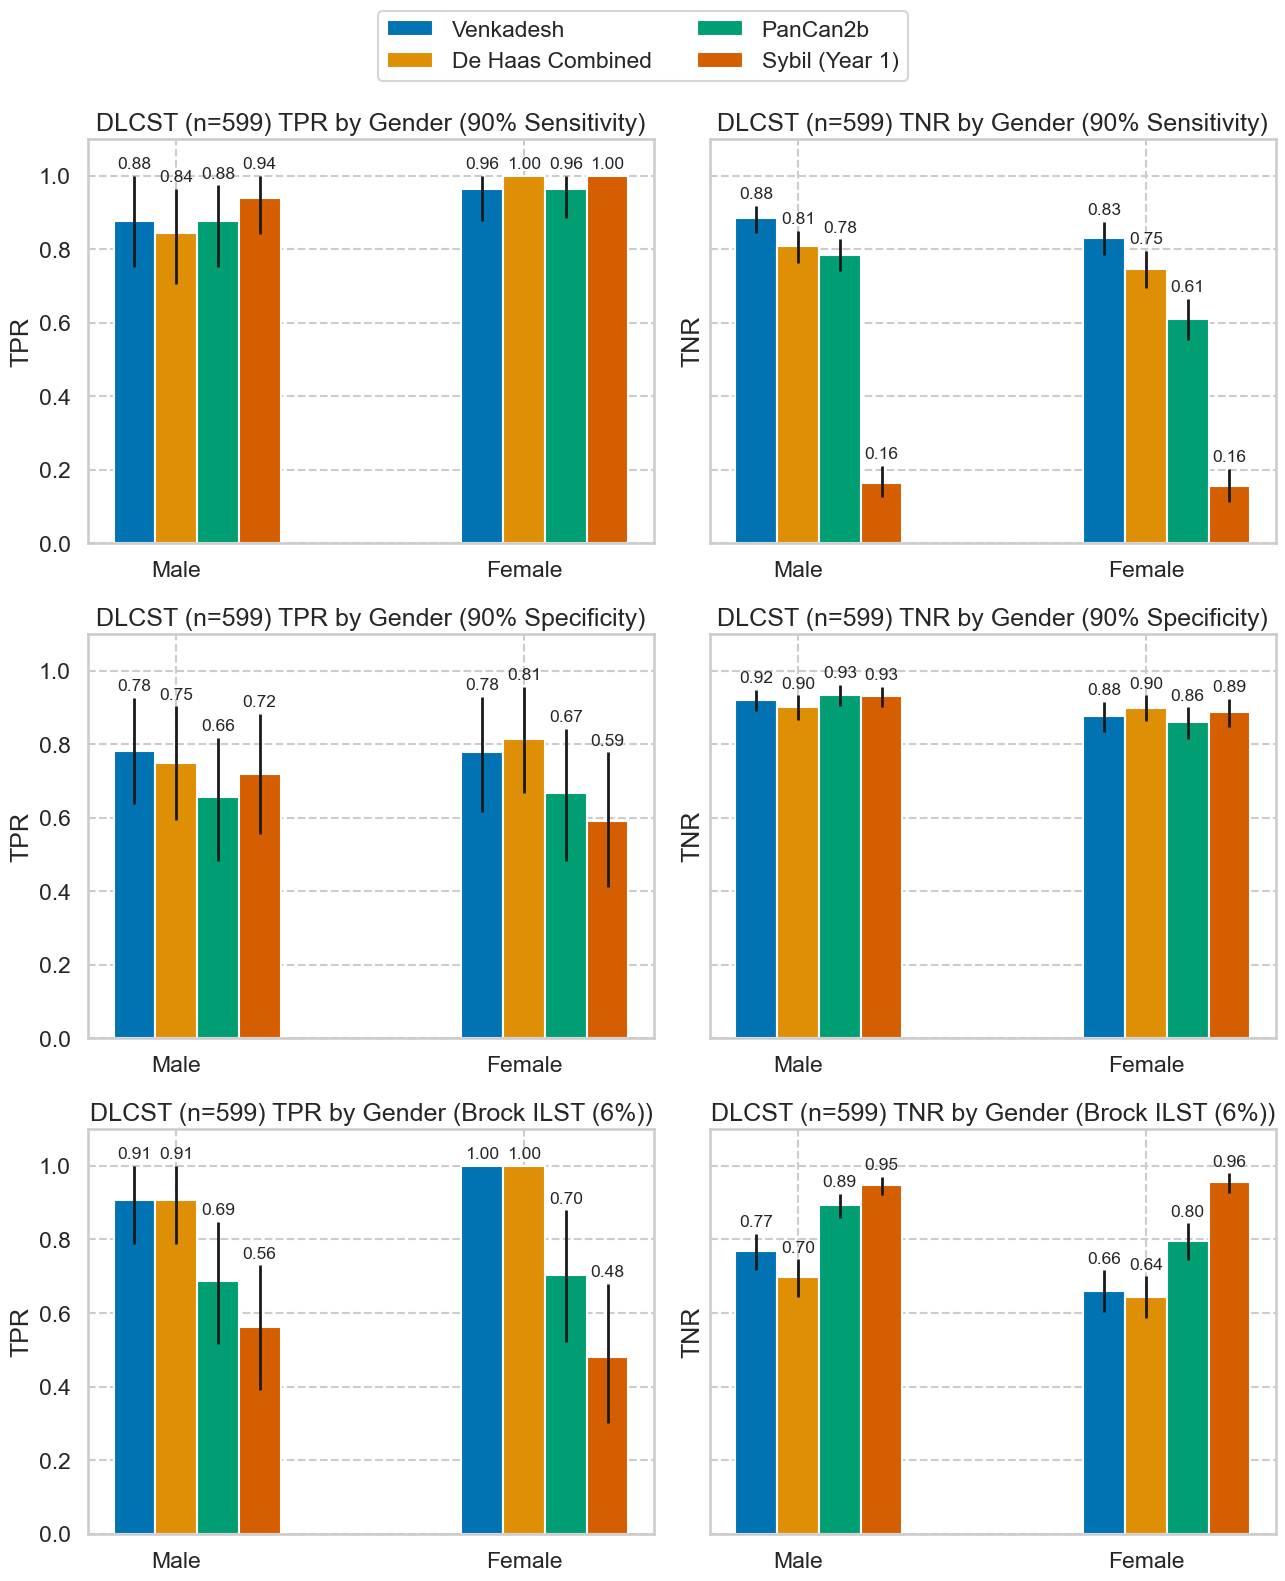

In [46]:
_ = threshold.plot_threshold_stats_subgroups(dlcst_preds_pretty, 'Gender', dataset_name='DLCST',
                                             policies=dlcst_policies, models=DLCST_MODELCOLS, 
                                             stats=threshold_dlcst.query('attribute == "Gender"'),
                                             plot_metrics=['TPR', 'TNR'], diff=False, show_mb_count=False,
                                             imgpath=f"{FIG_DIR}/thresholdDLCSTsex.png"
                                            )

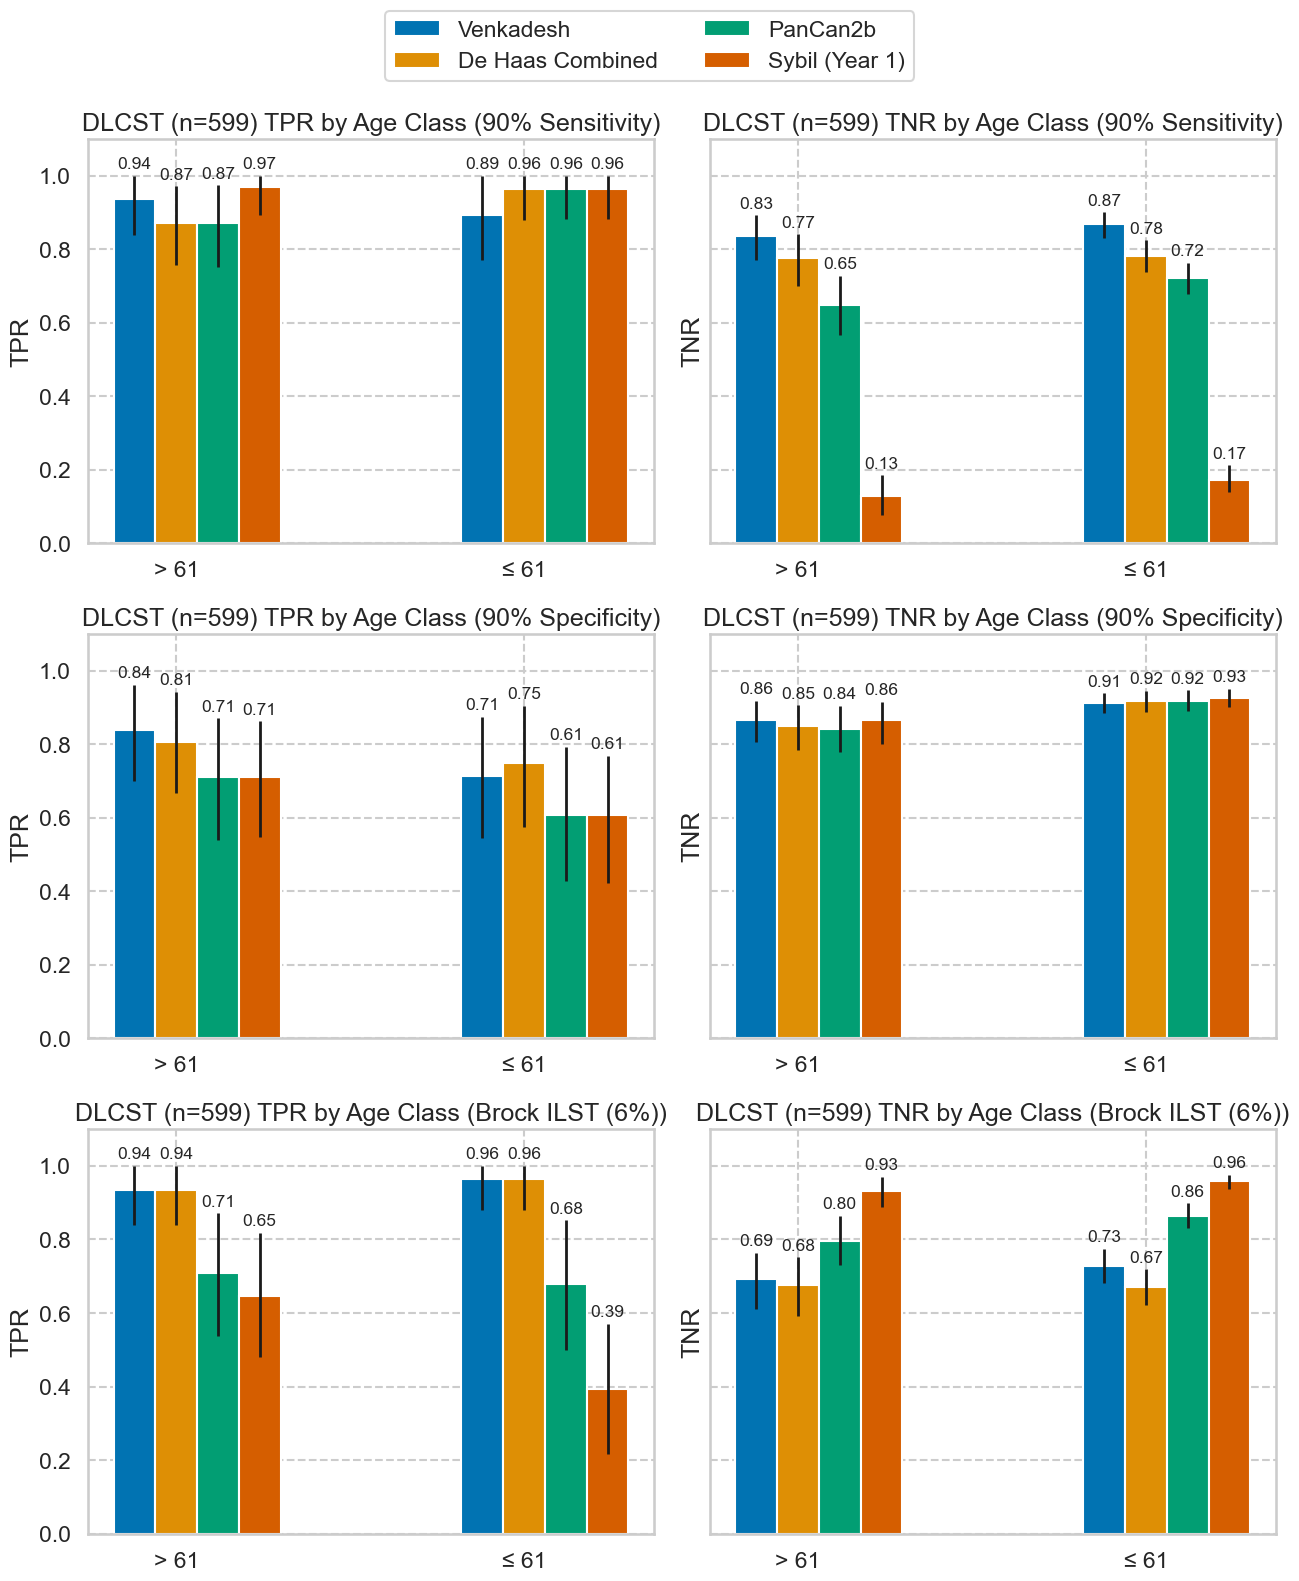

In [47]:
_ = threshold.plot_threshold_stats_subgroups(dlcst_preds_pretty, 'Age Class', dataset_name='DLCST',
                                             policies=dlcst_policies, models=DLCST_MODELCOLS, 
                                             stats=threshold_dlcst.query('attribute == "Age Class"'),
                                             plot_metrics=['TPR', 'TNR'], diff=False, show_mb_count=False,
                                             imgpath=f"{FIG_DIR}/thresholdDLCSTage.png"
                                            )

### NLST (1172)

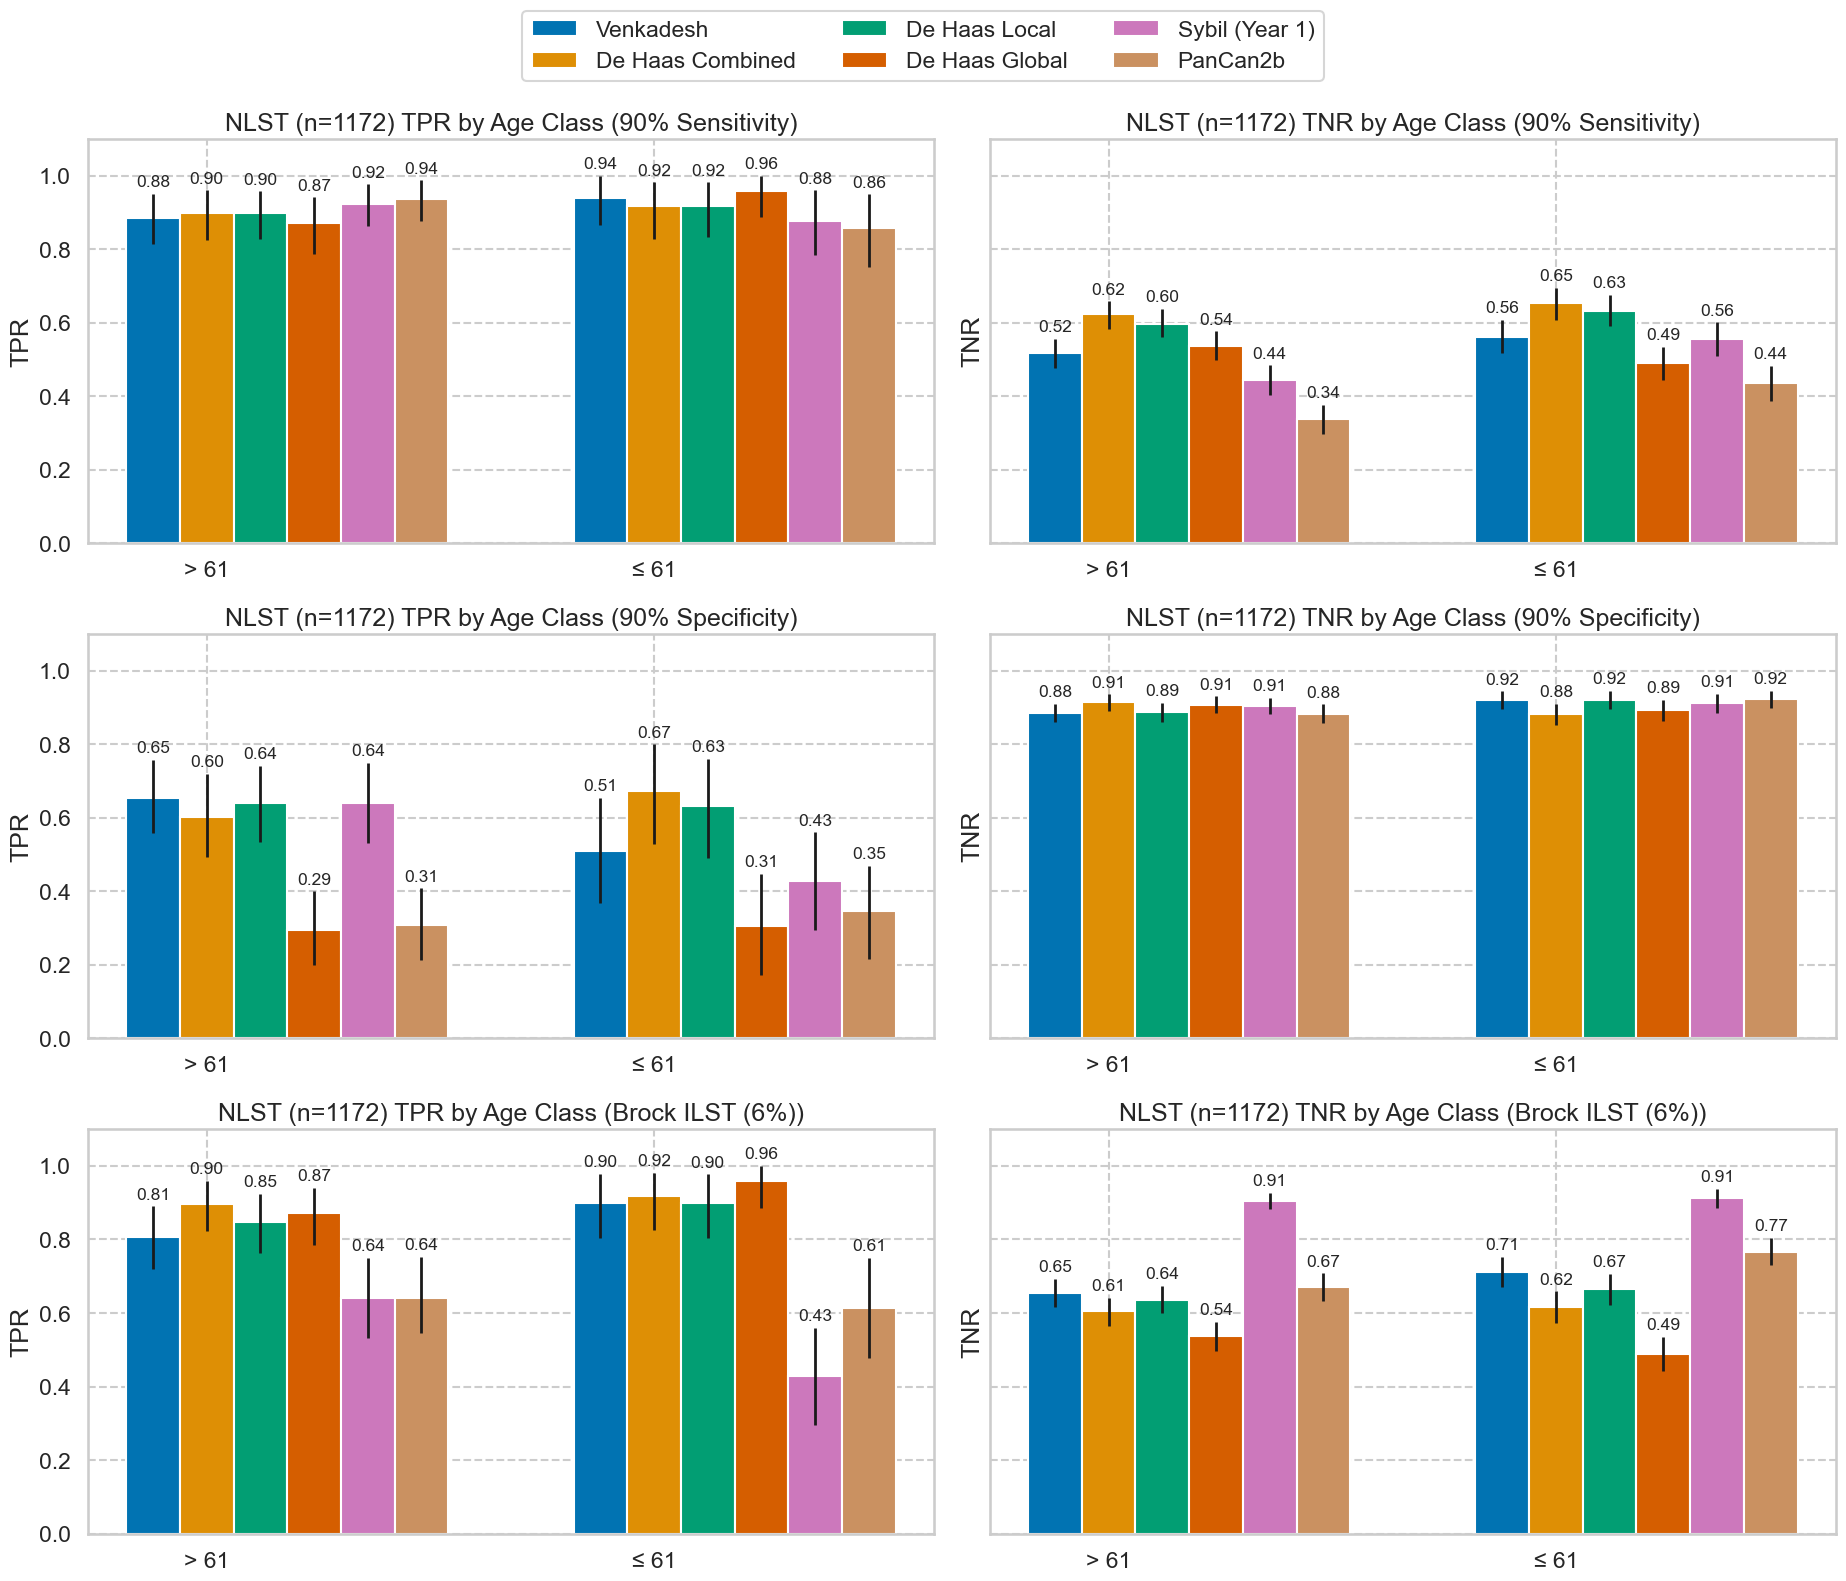

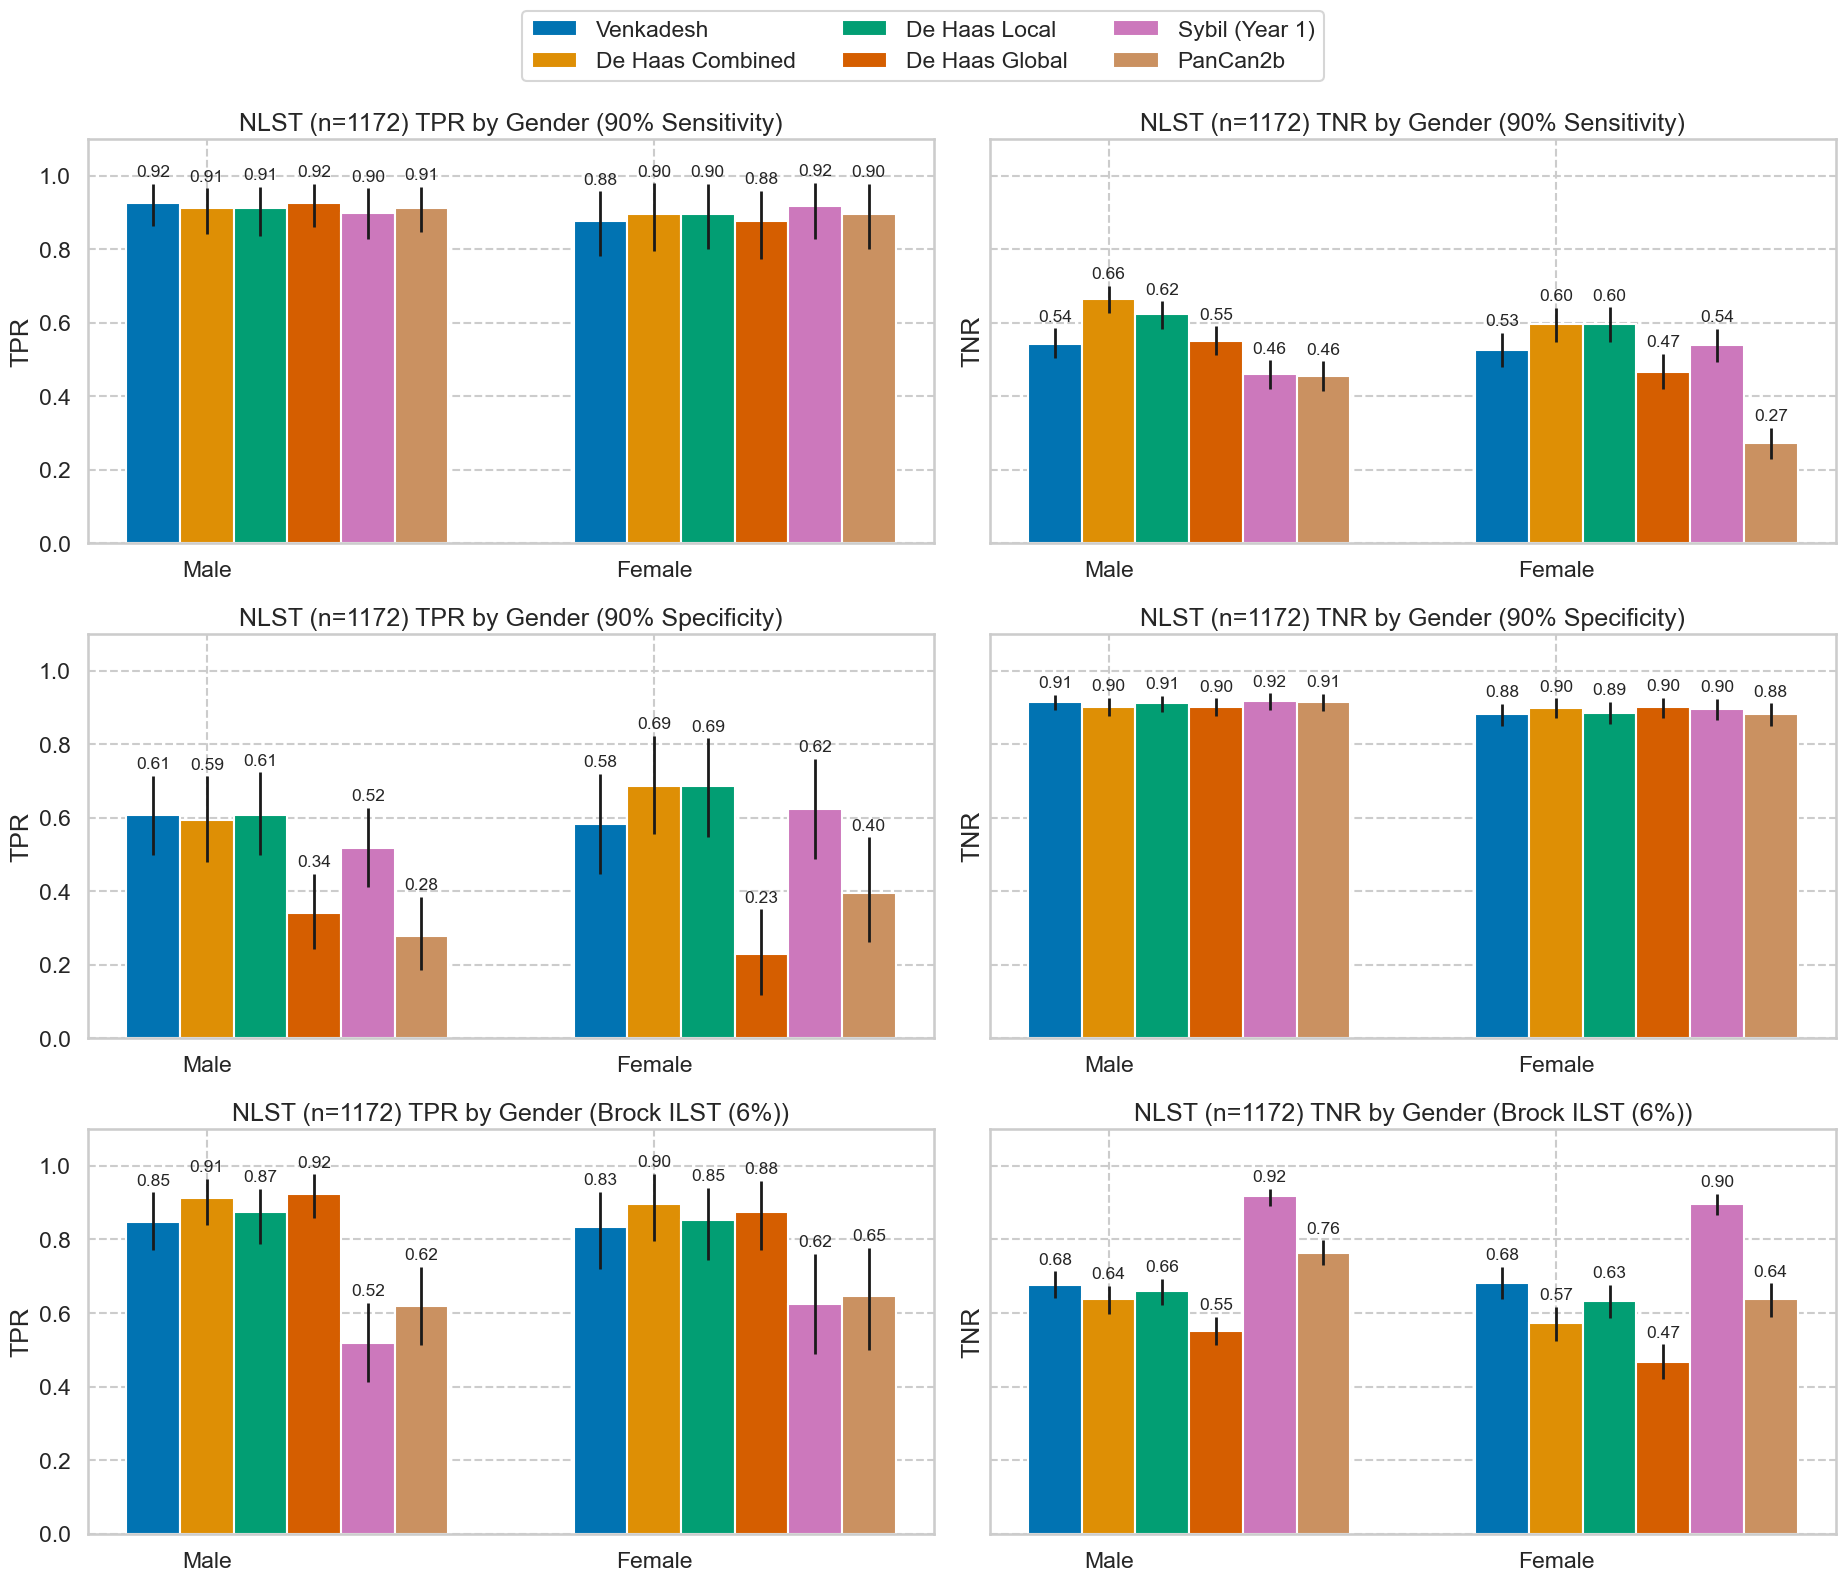

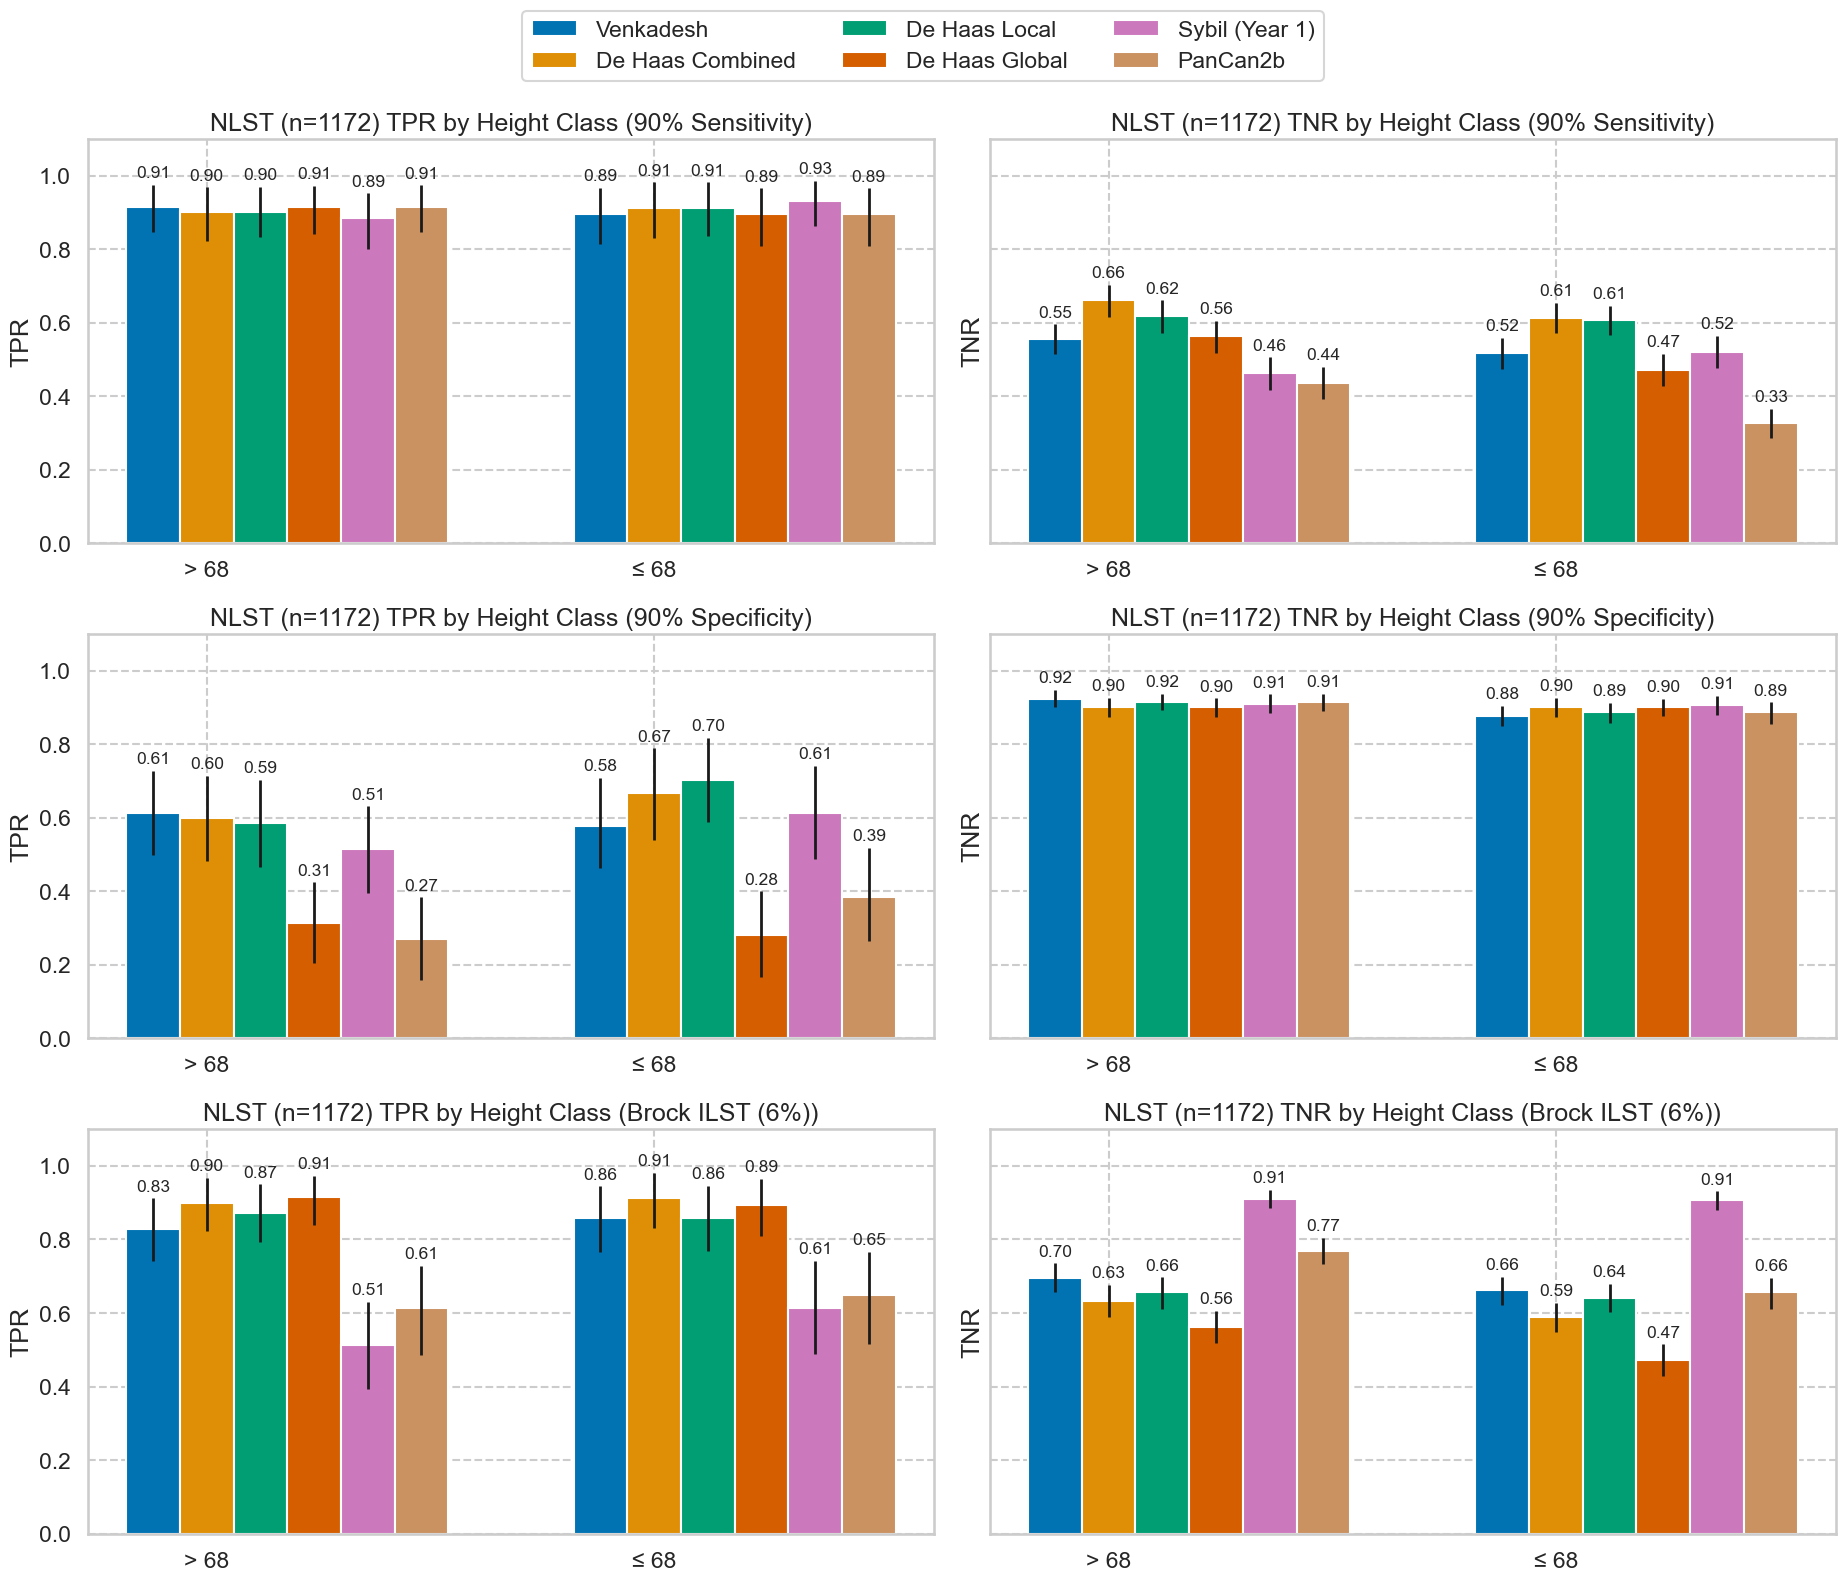

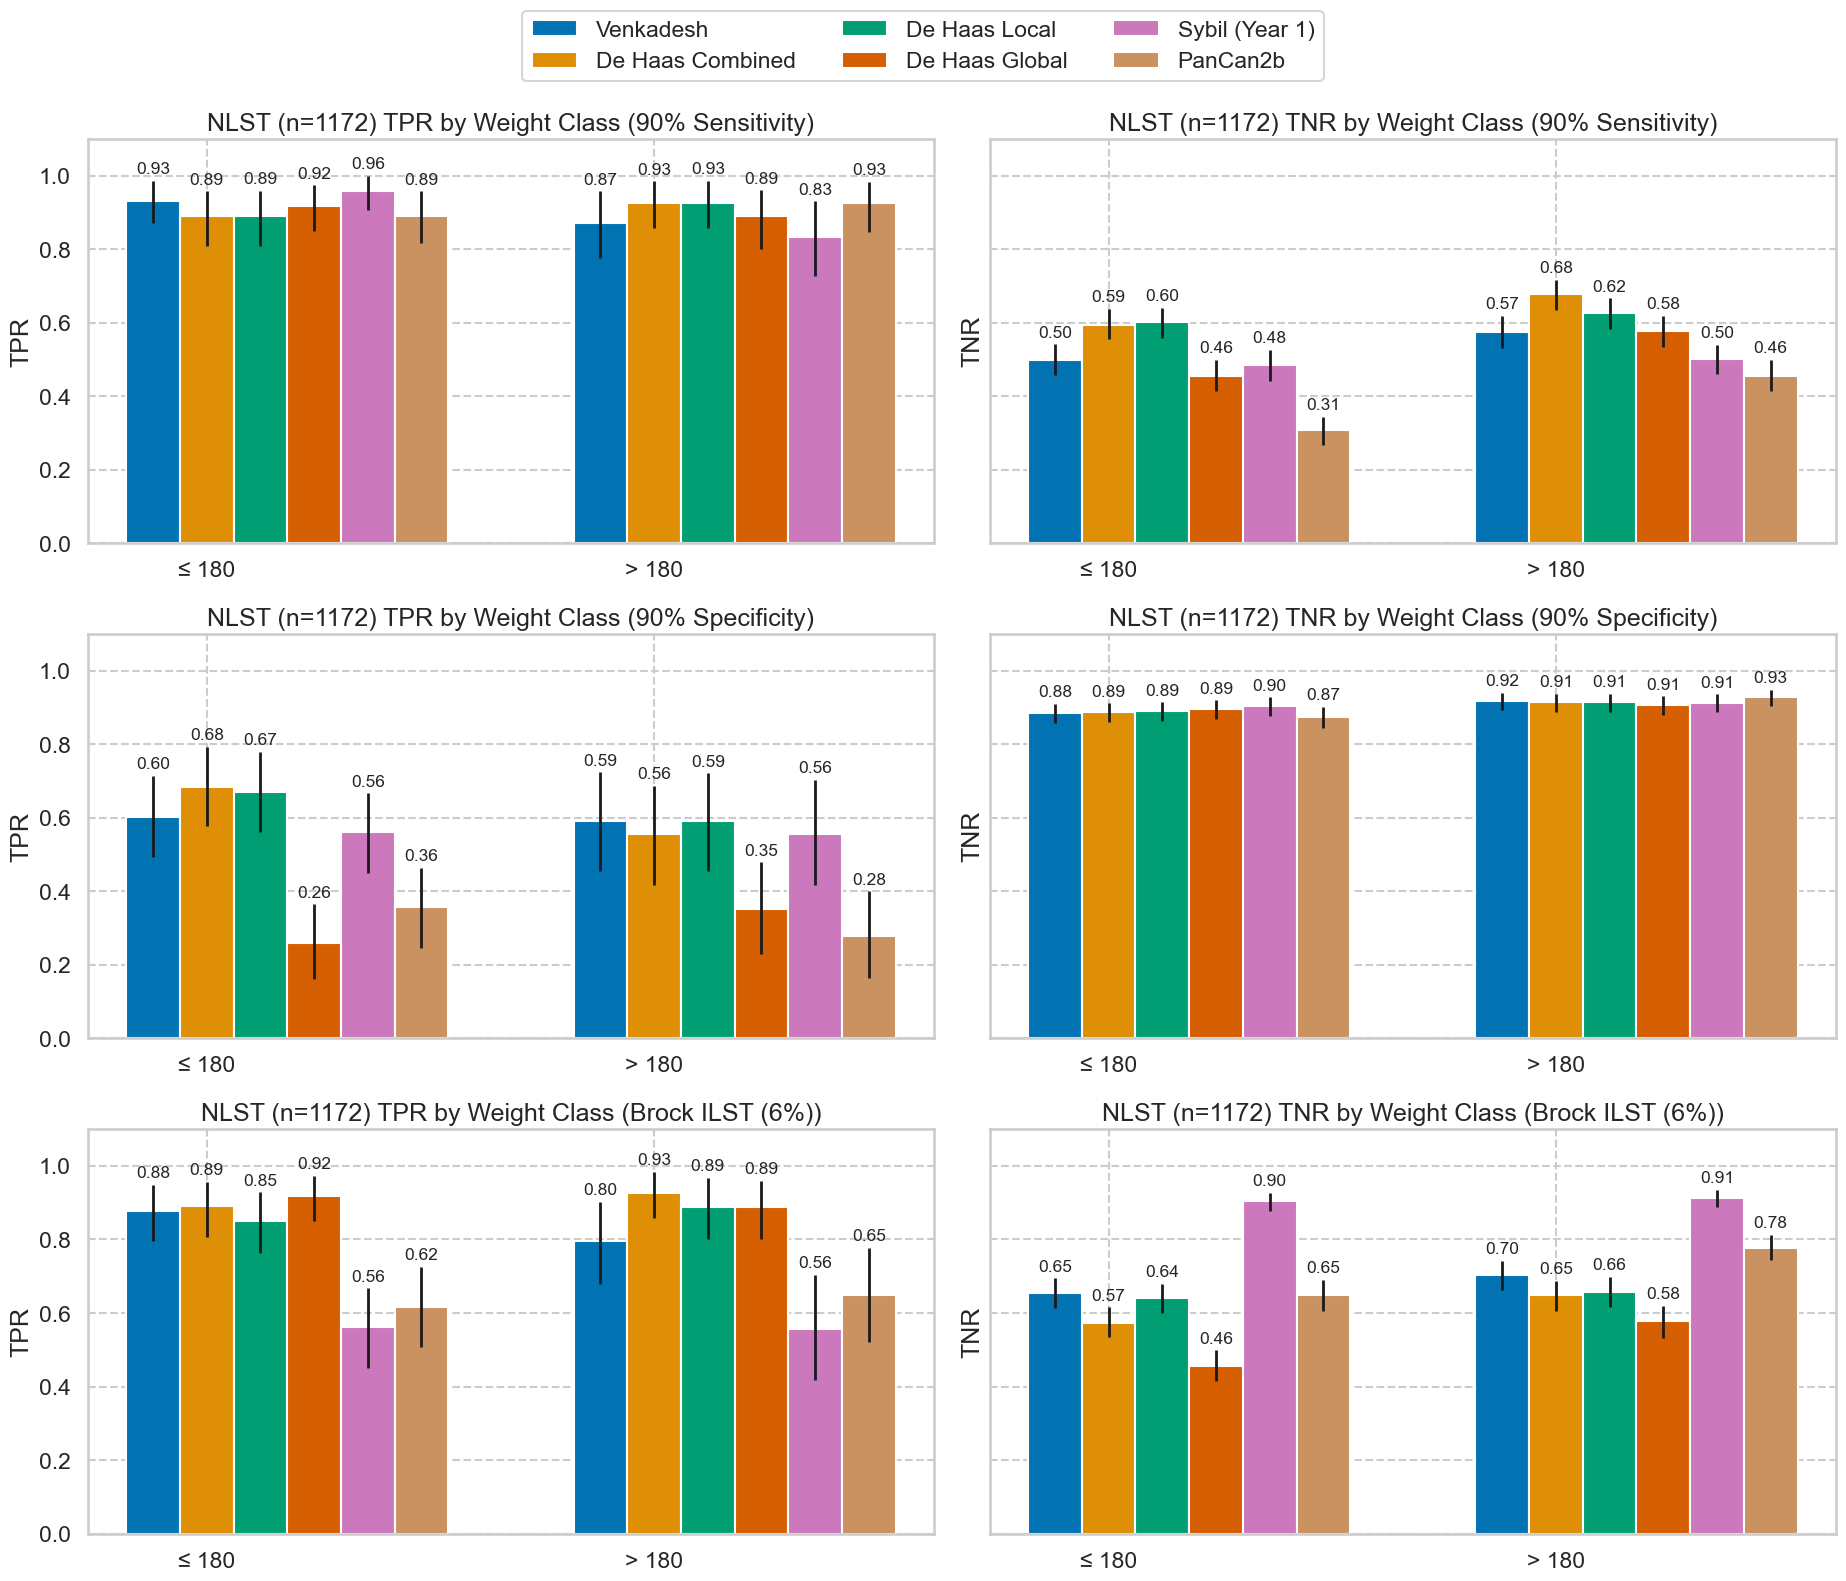

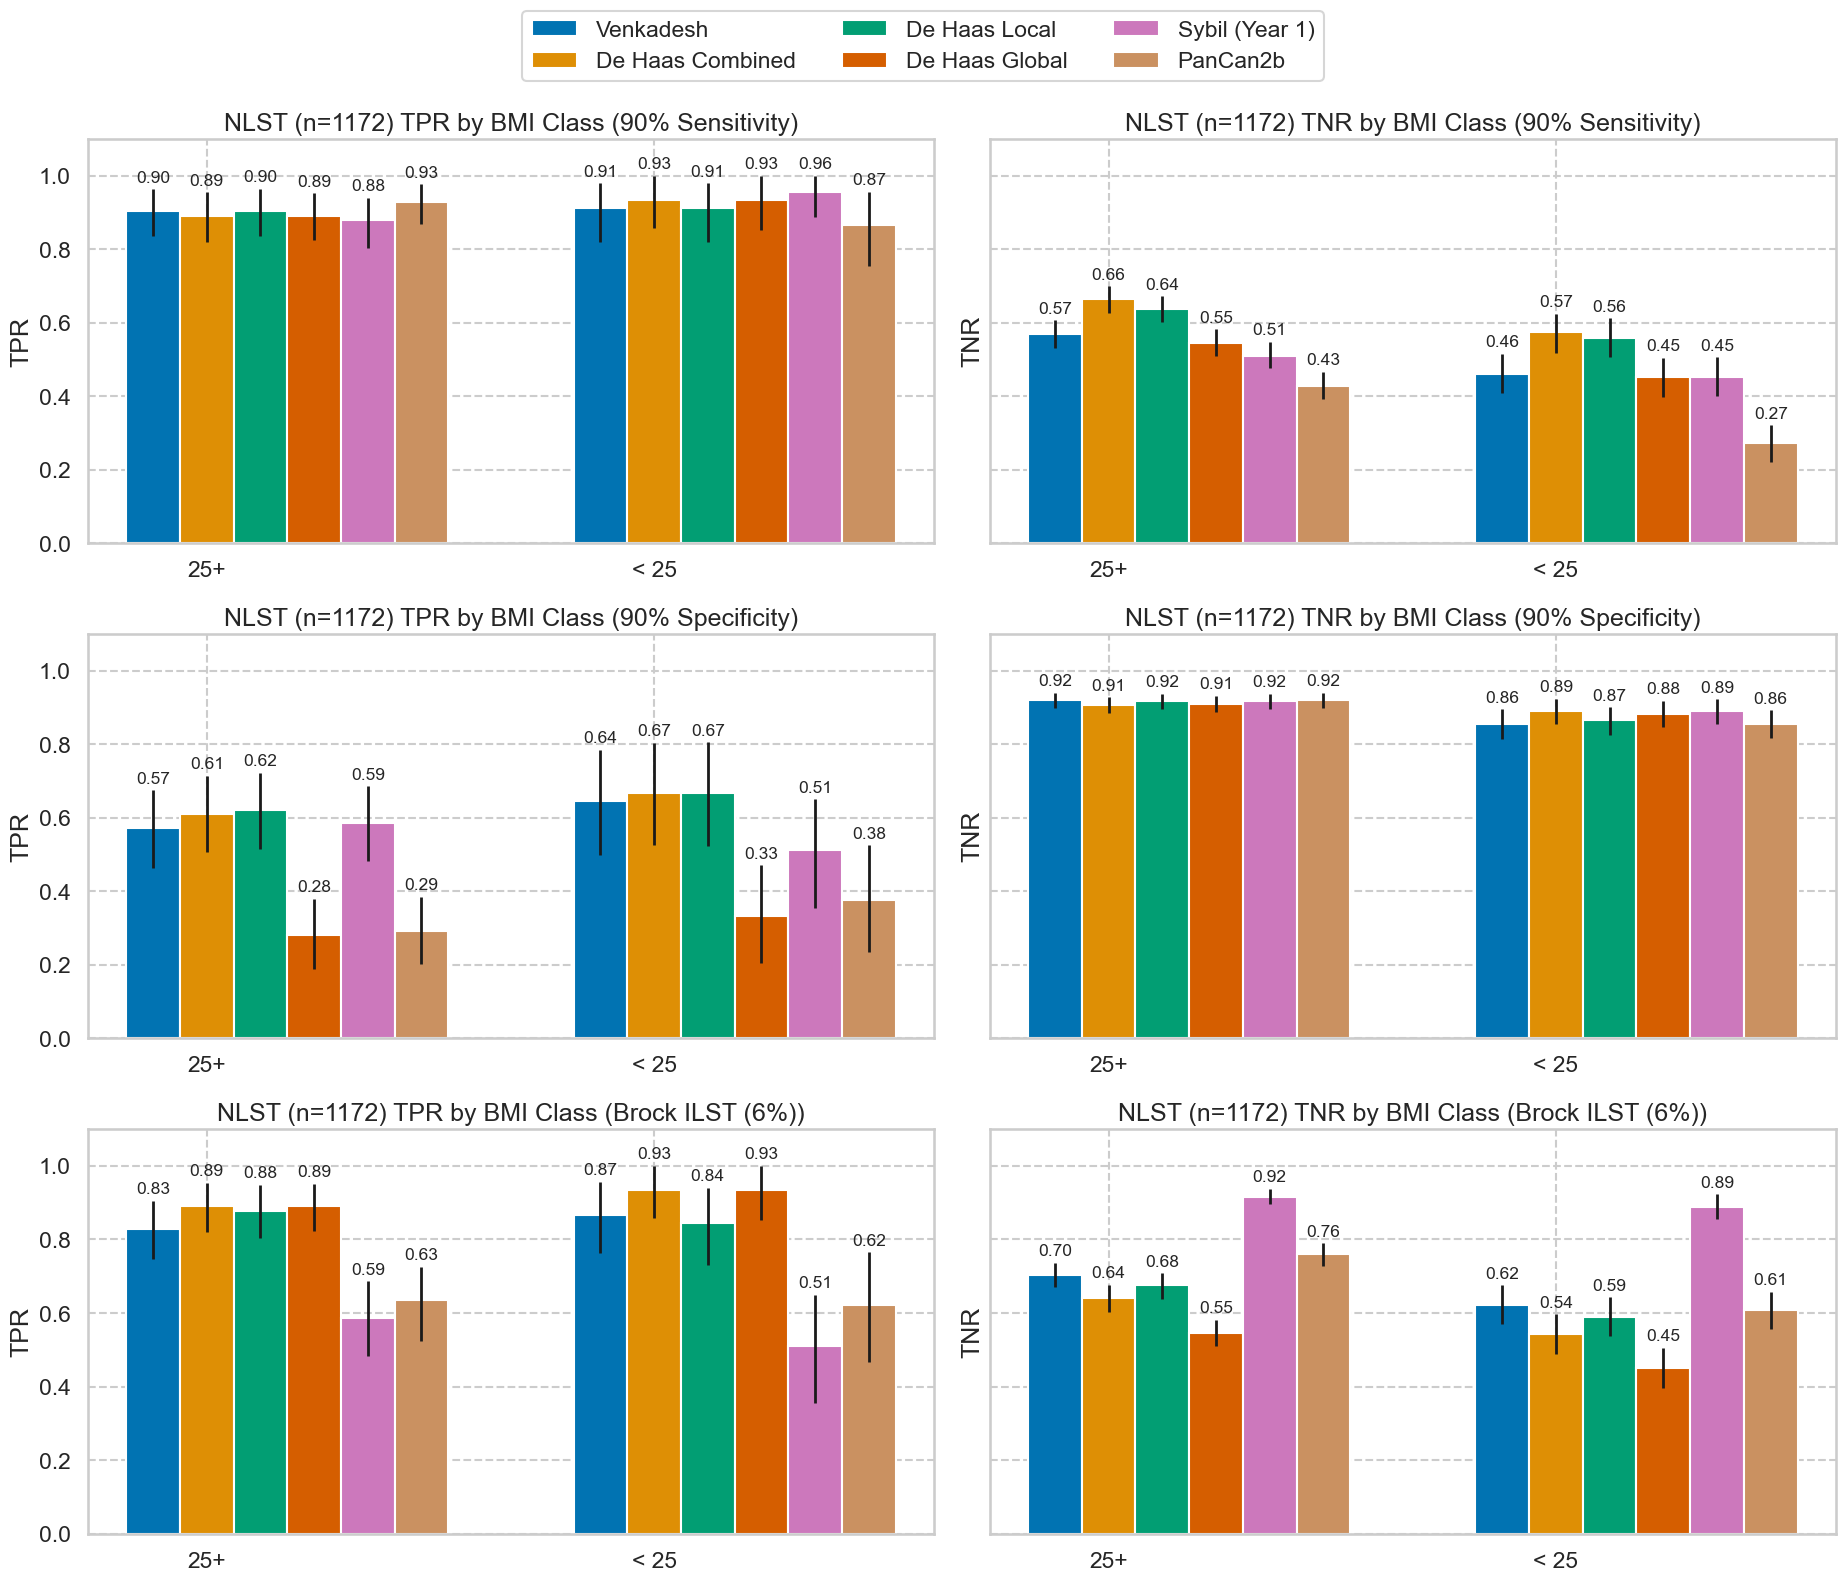

In [48]:
for col in nlst_demos_to_include:
    _ = threshold.plot_threshold_stats_subgroups(nlst_1172, col, dataset_name='NLST',
                                                policies=nlst_1172_policies, models=NLST_1172_MODELCOLS, 
                                                stats=threshold_nlst_1172.query(f'attribute == "{col}"'),
                                                plot_metrics=['TPR', 'TNR'], diff=False, show_mb_count=False,
                                                imgpath=f"{FIG_DIR}/threshold-NLST-1172/{col}.png"
                                                )  

### NLST 5911


['Age Class', 'Gender', 'Race', 'HS Education', 'Height Class', 'Weight Class', 'BMI Class']


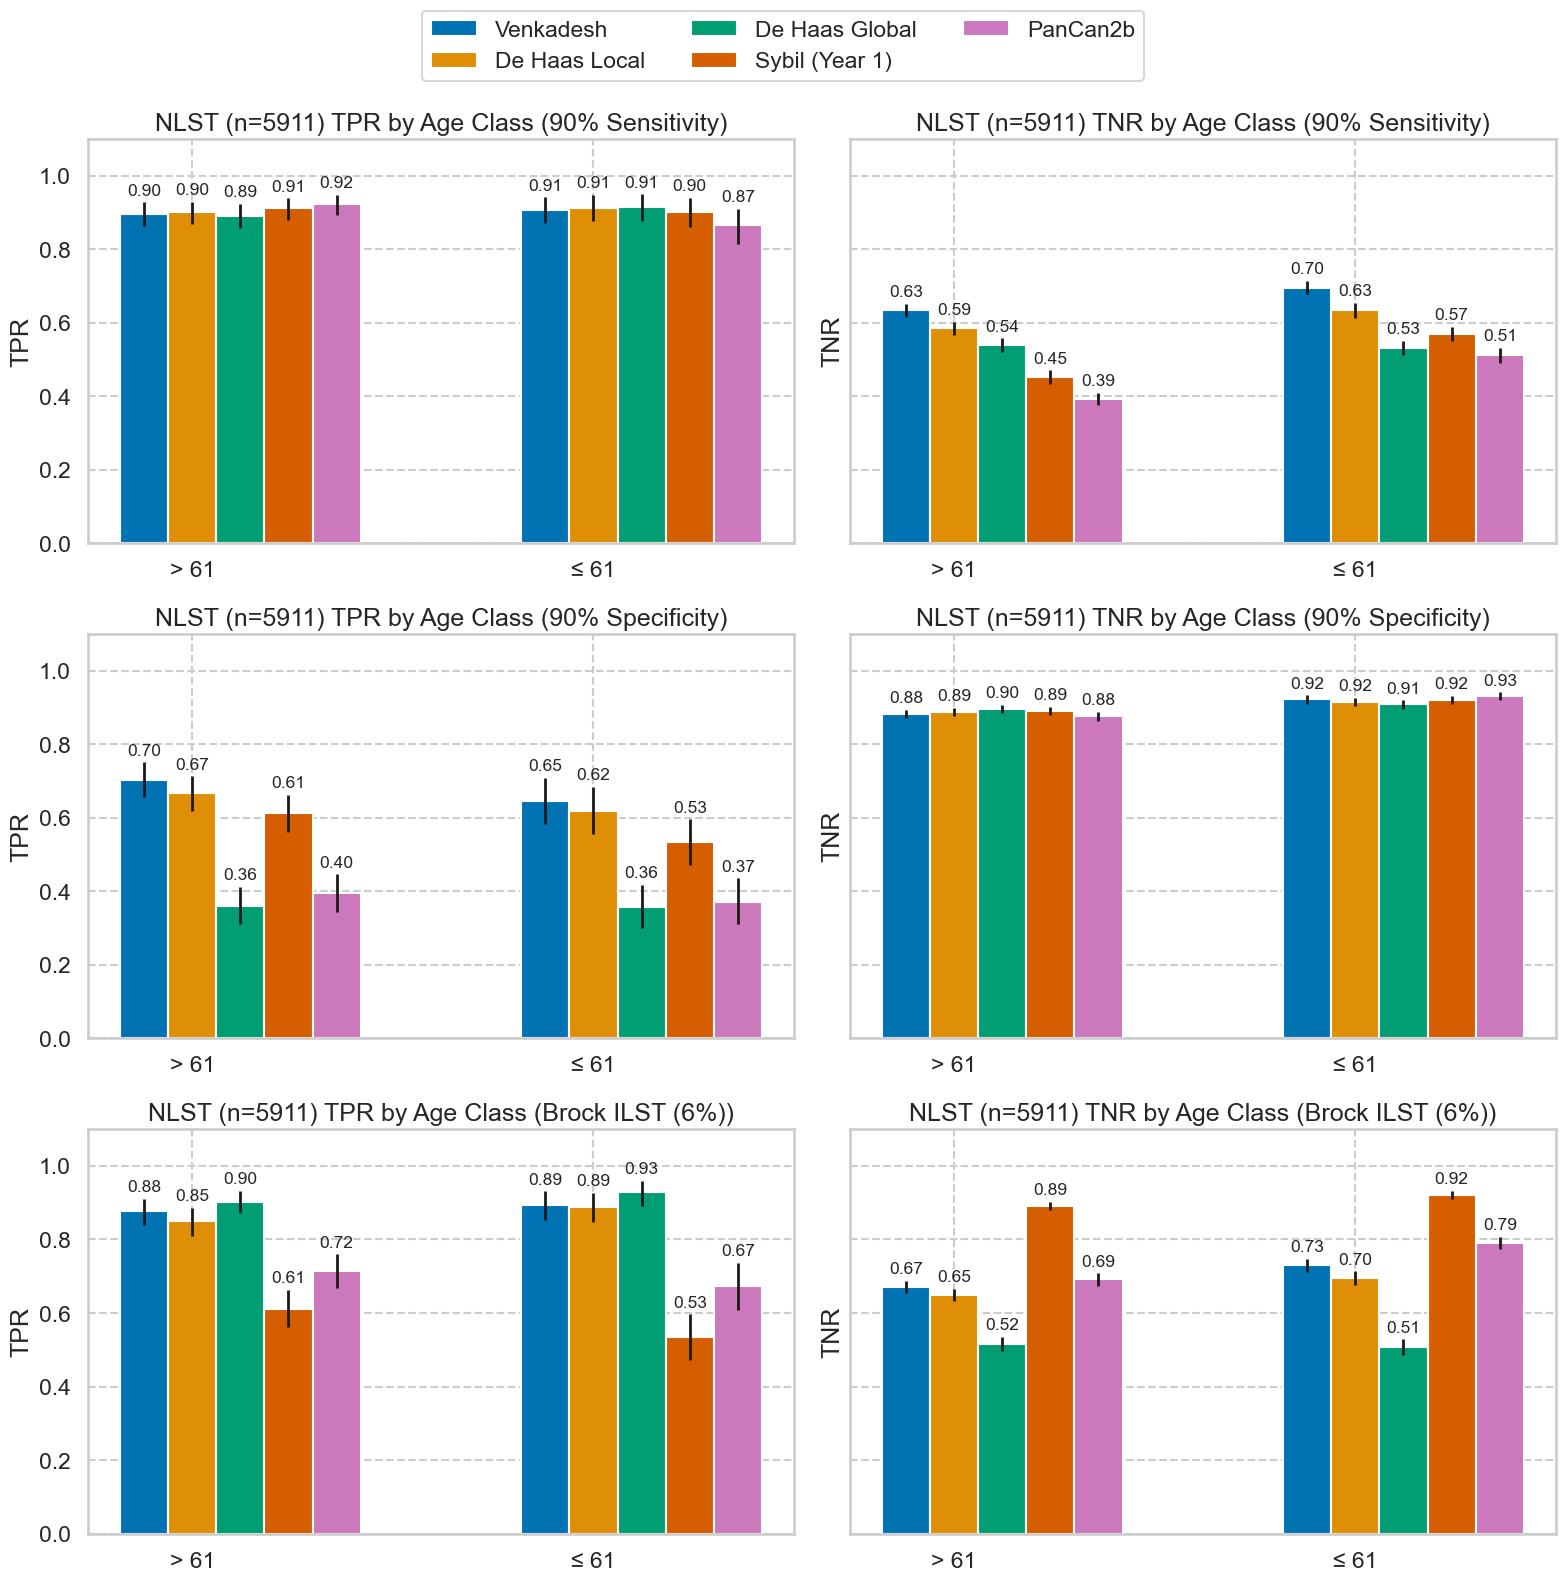

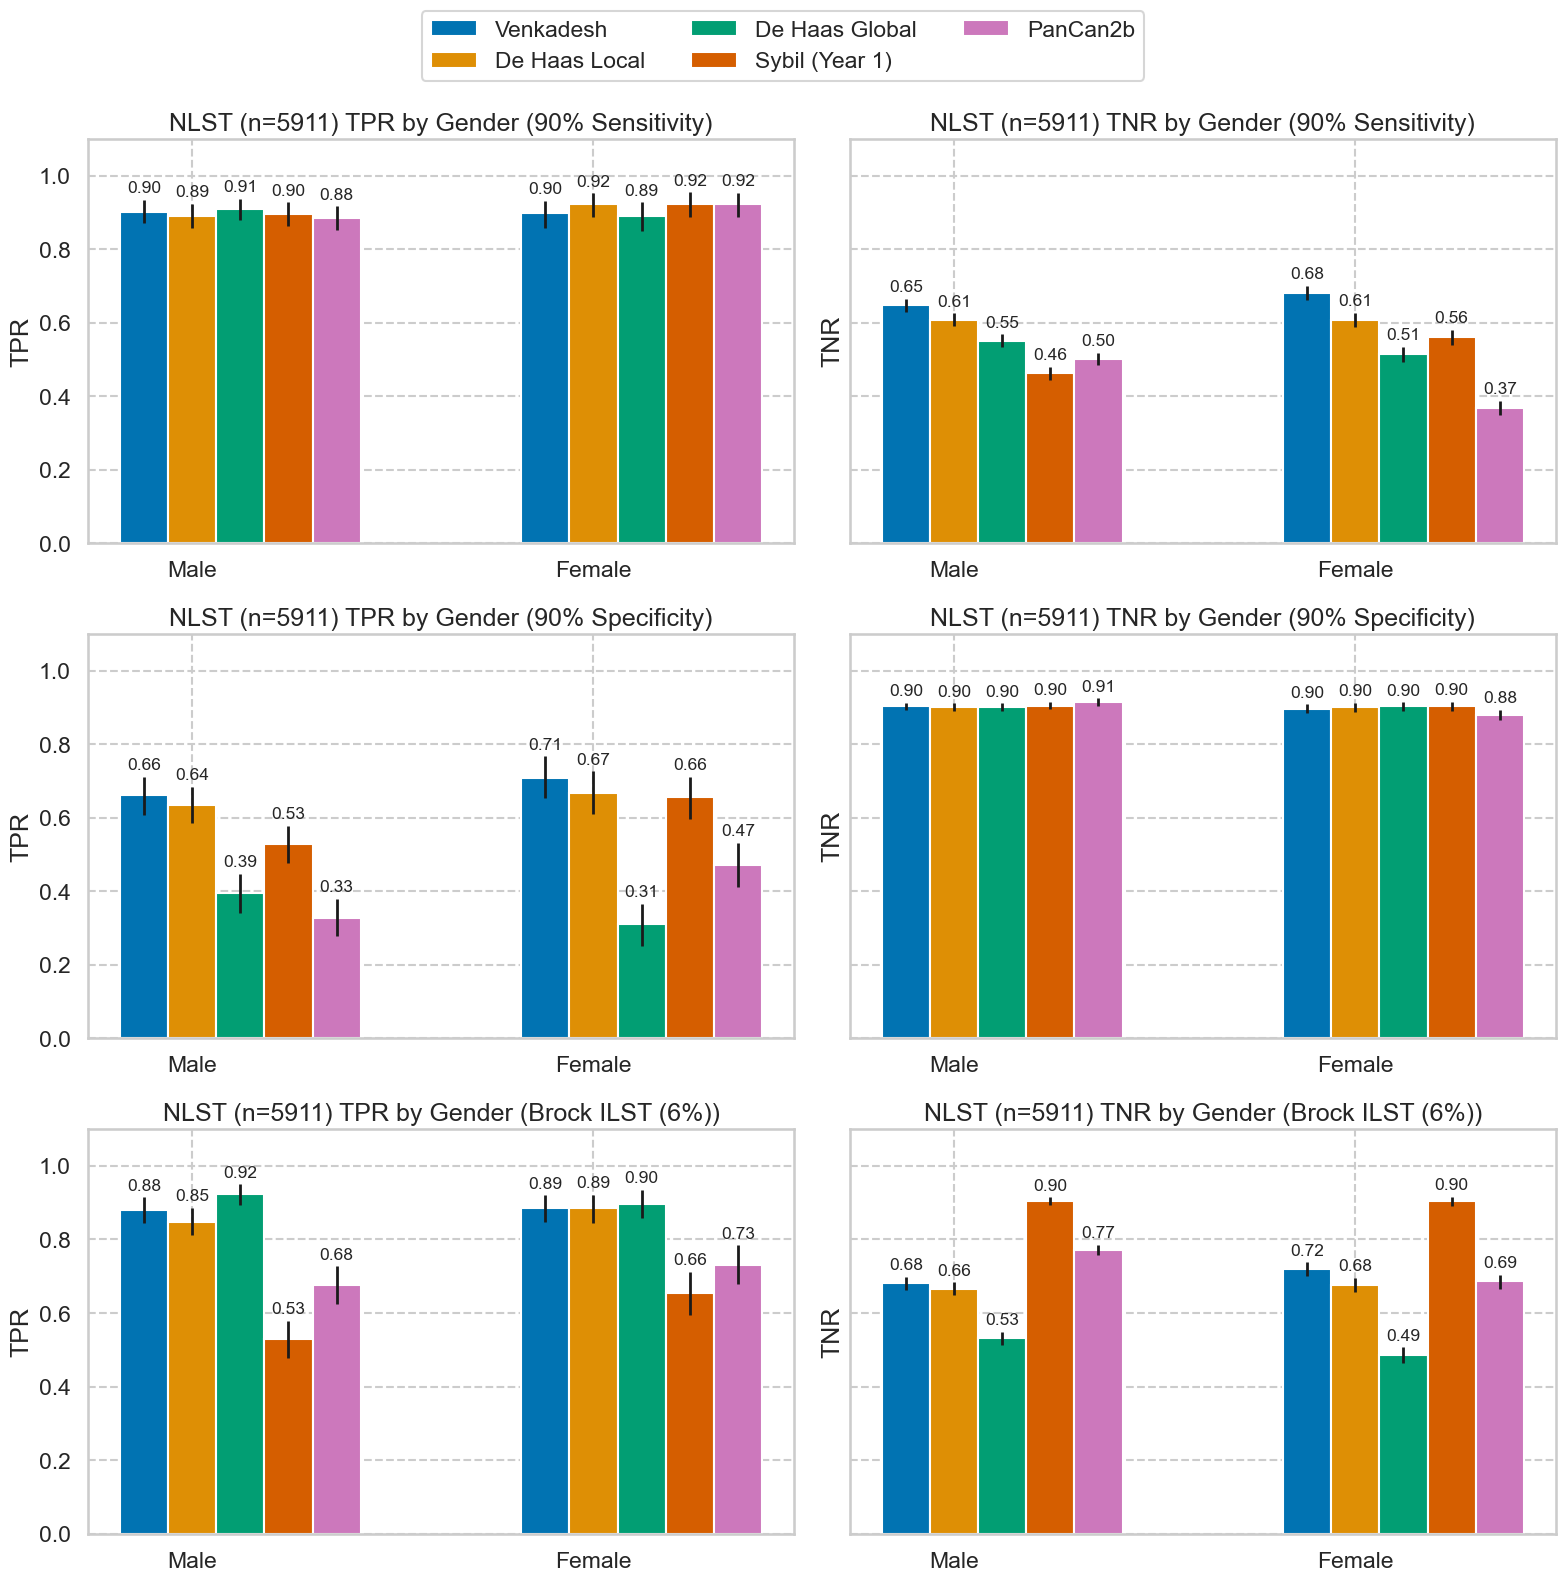

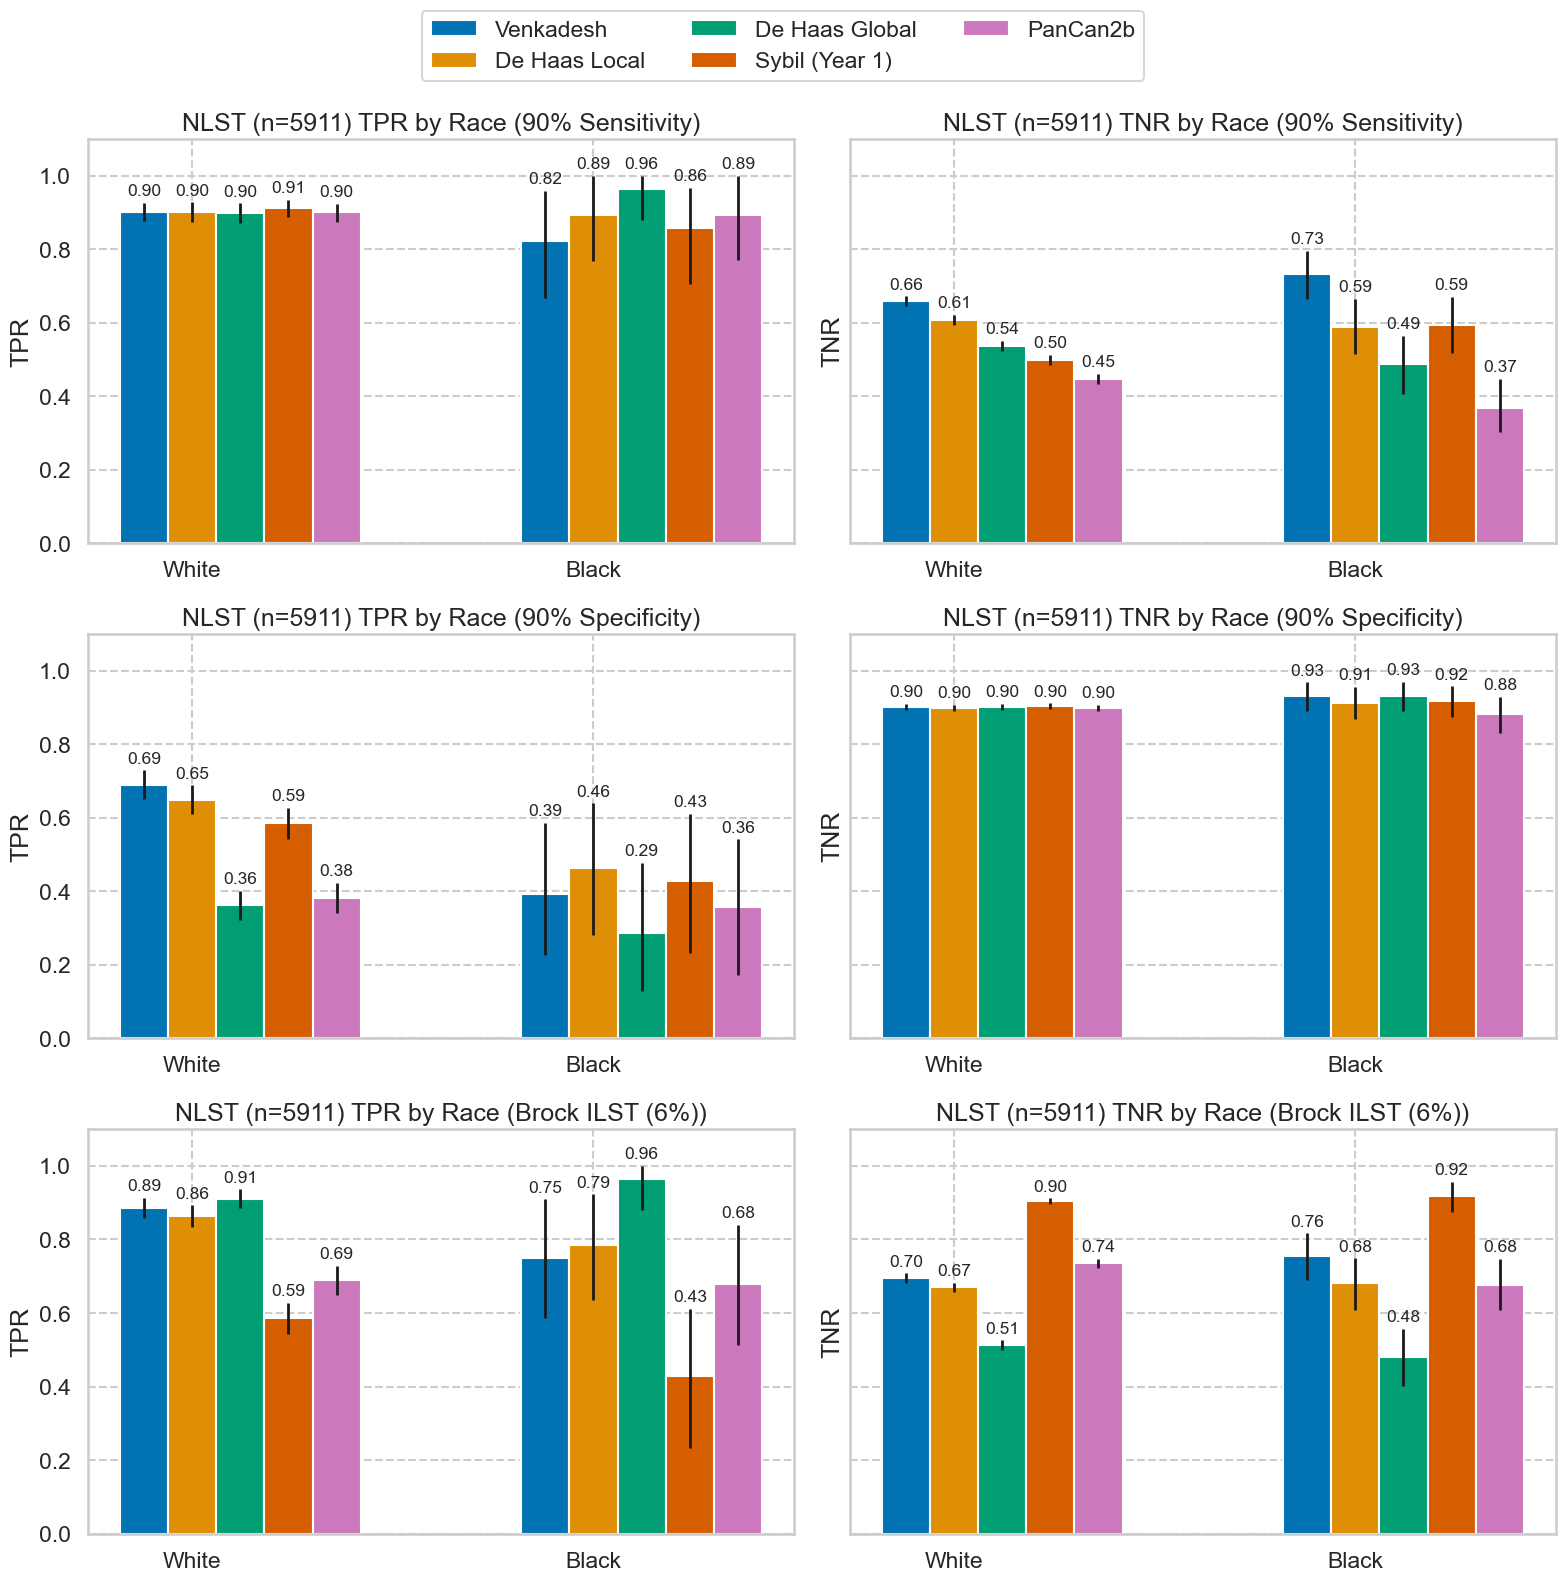

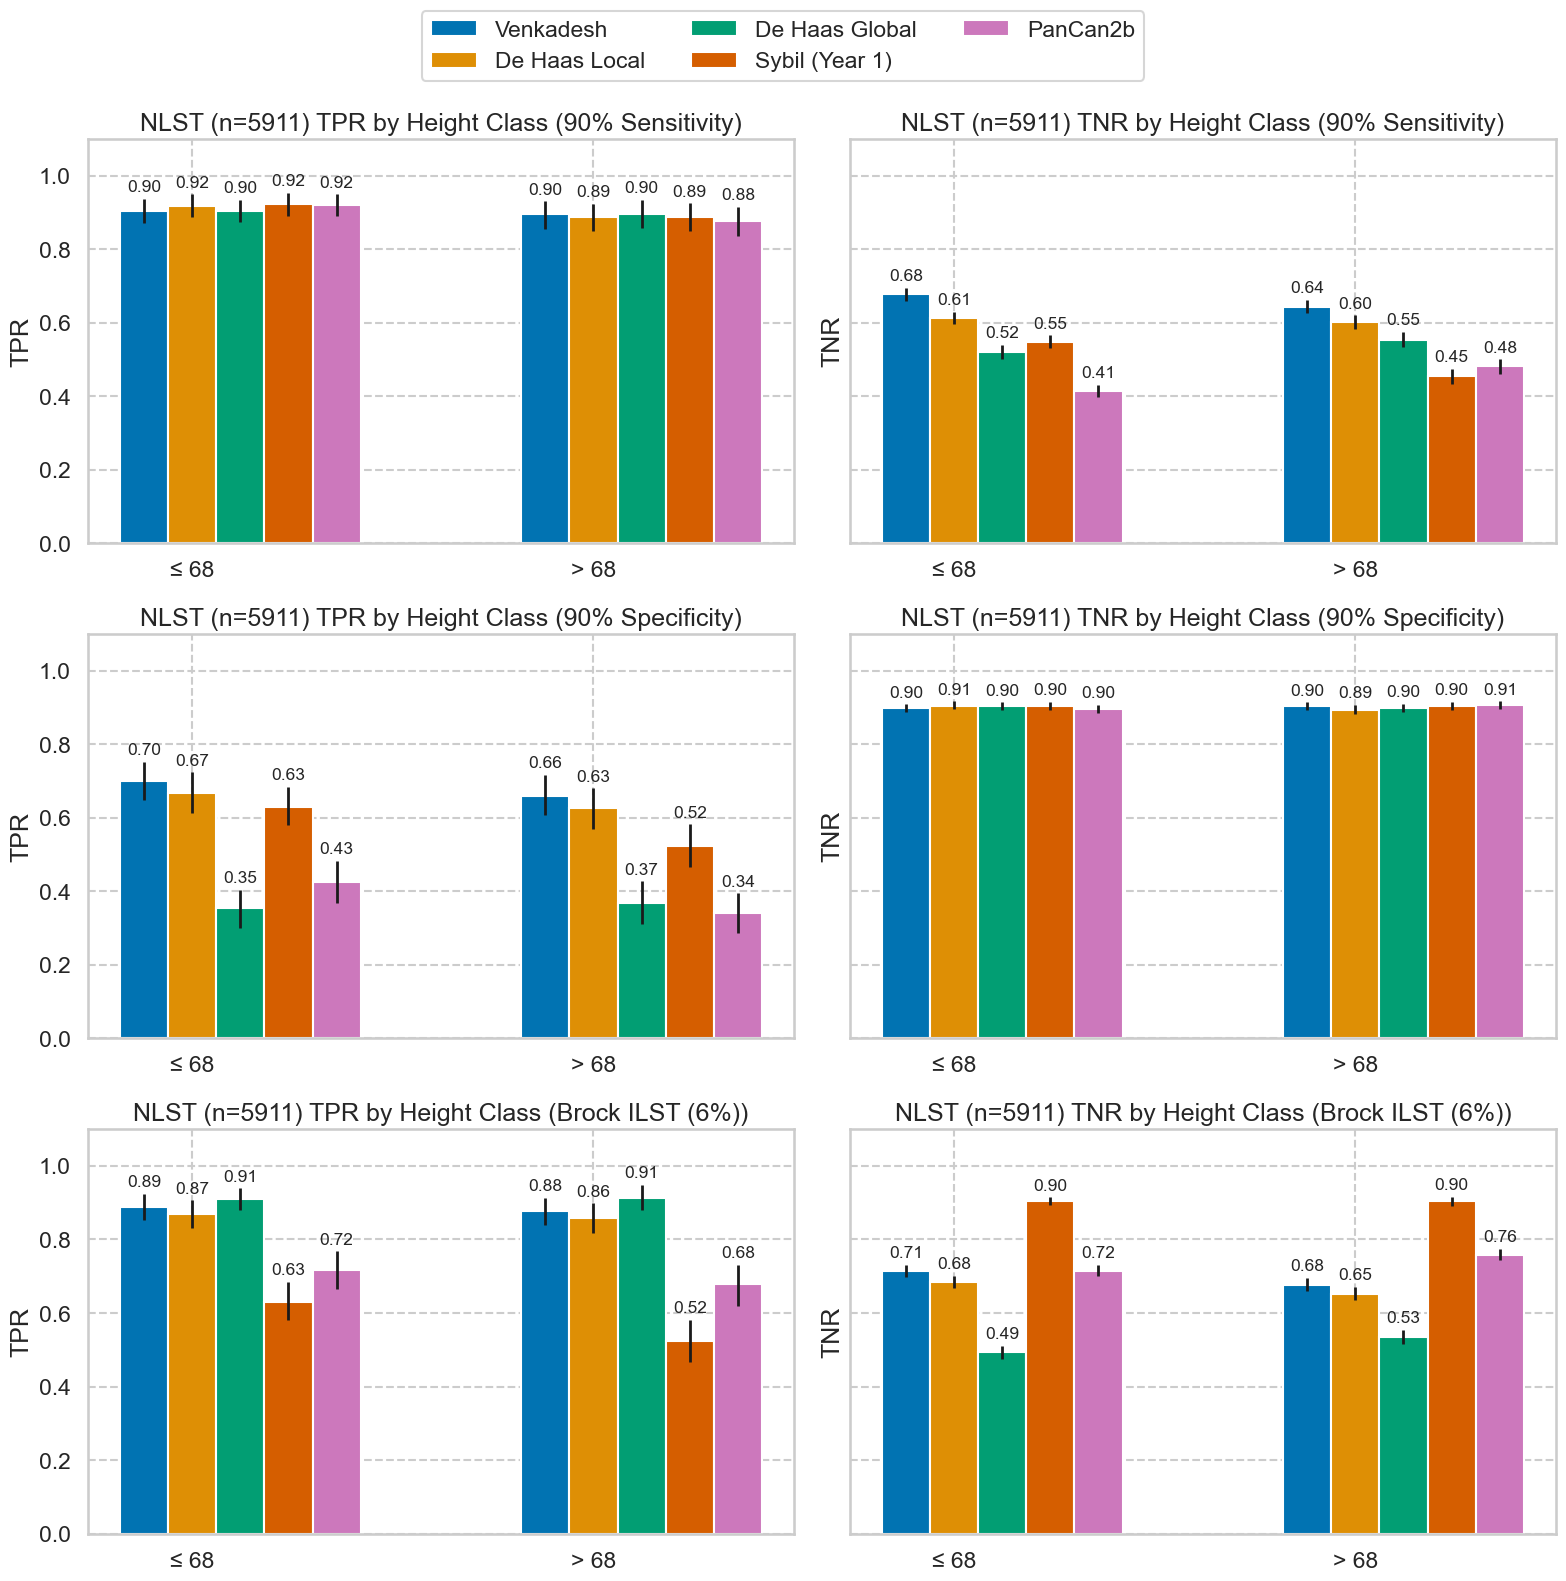

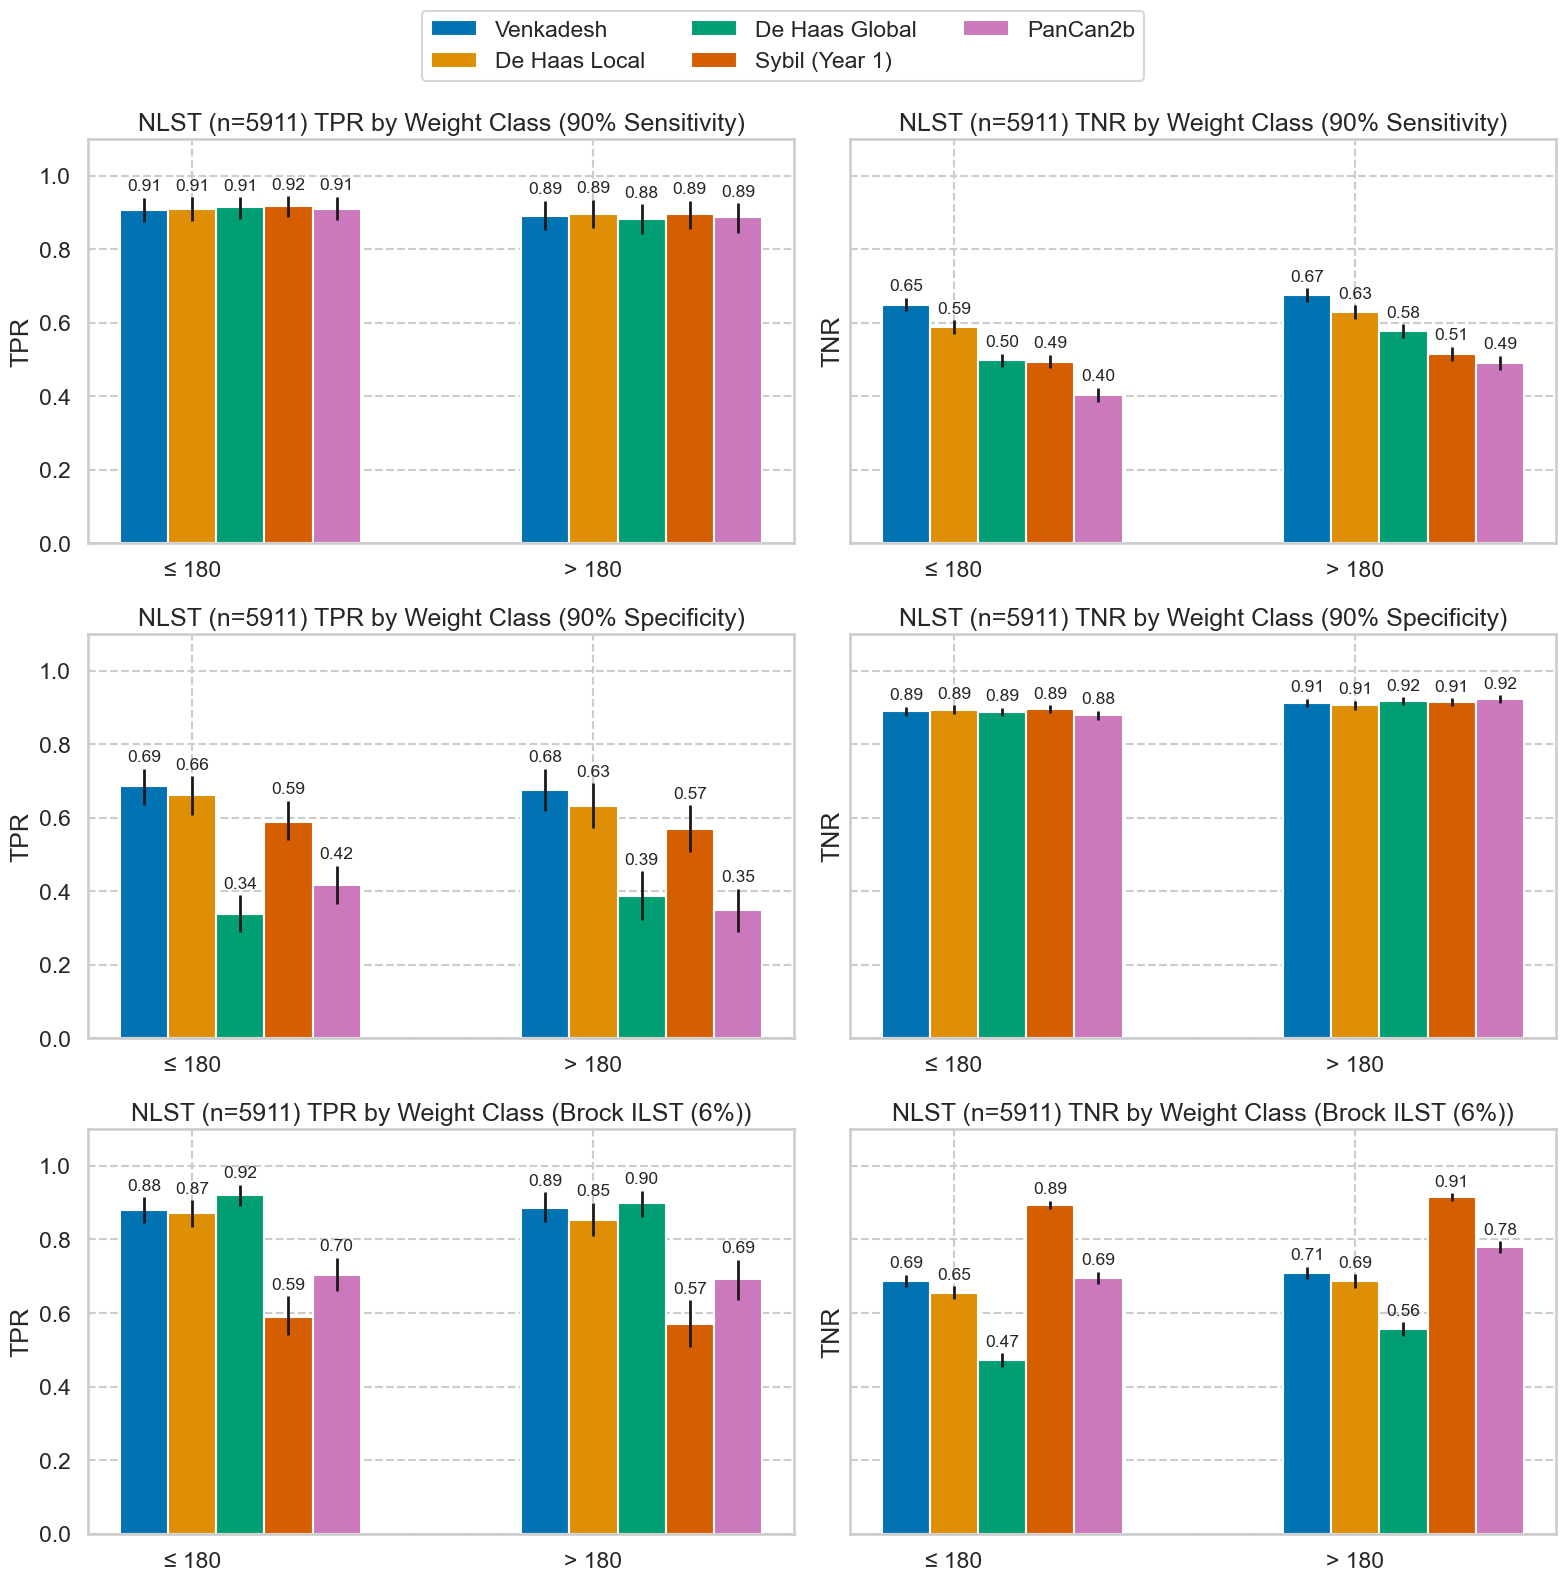

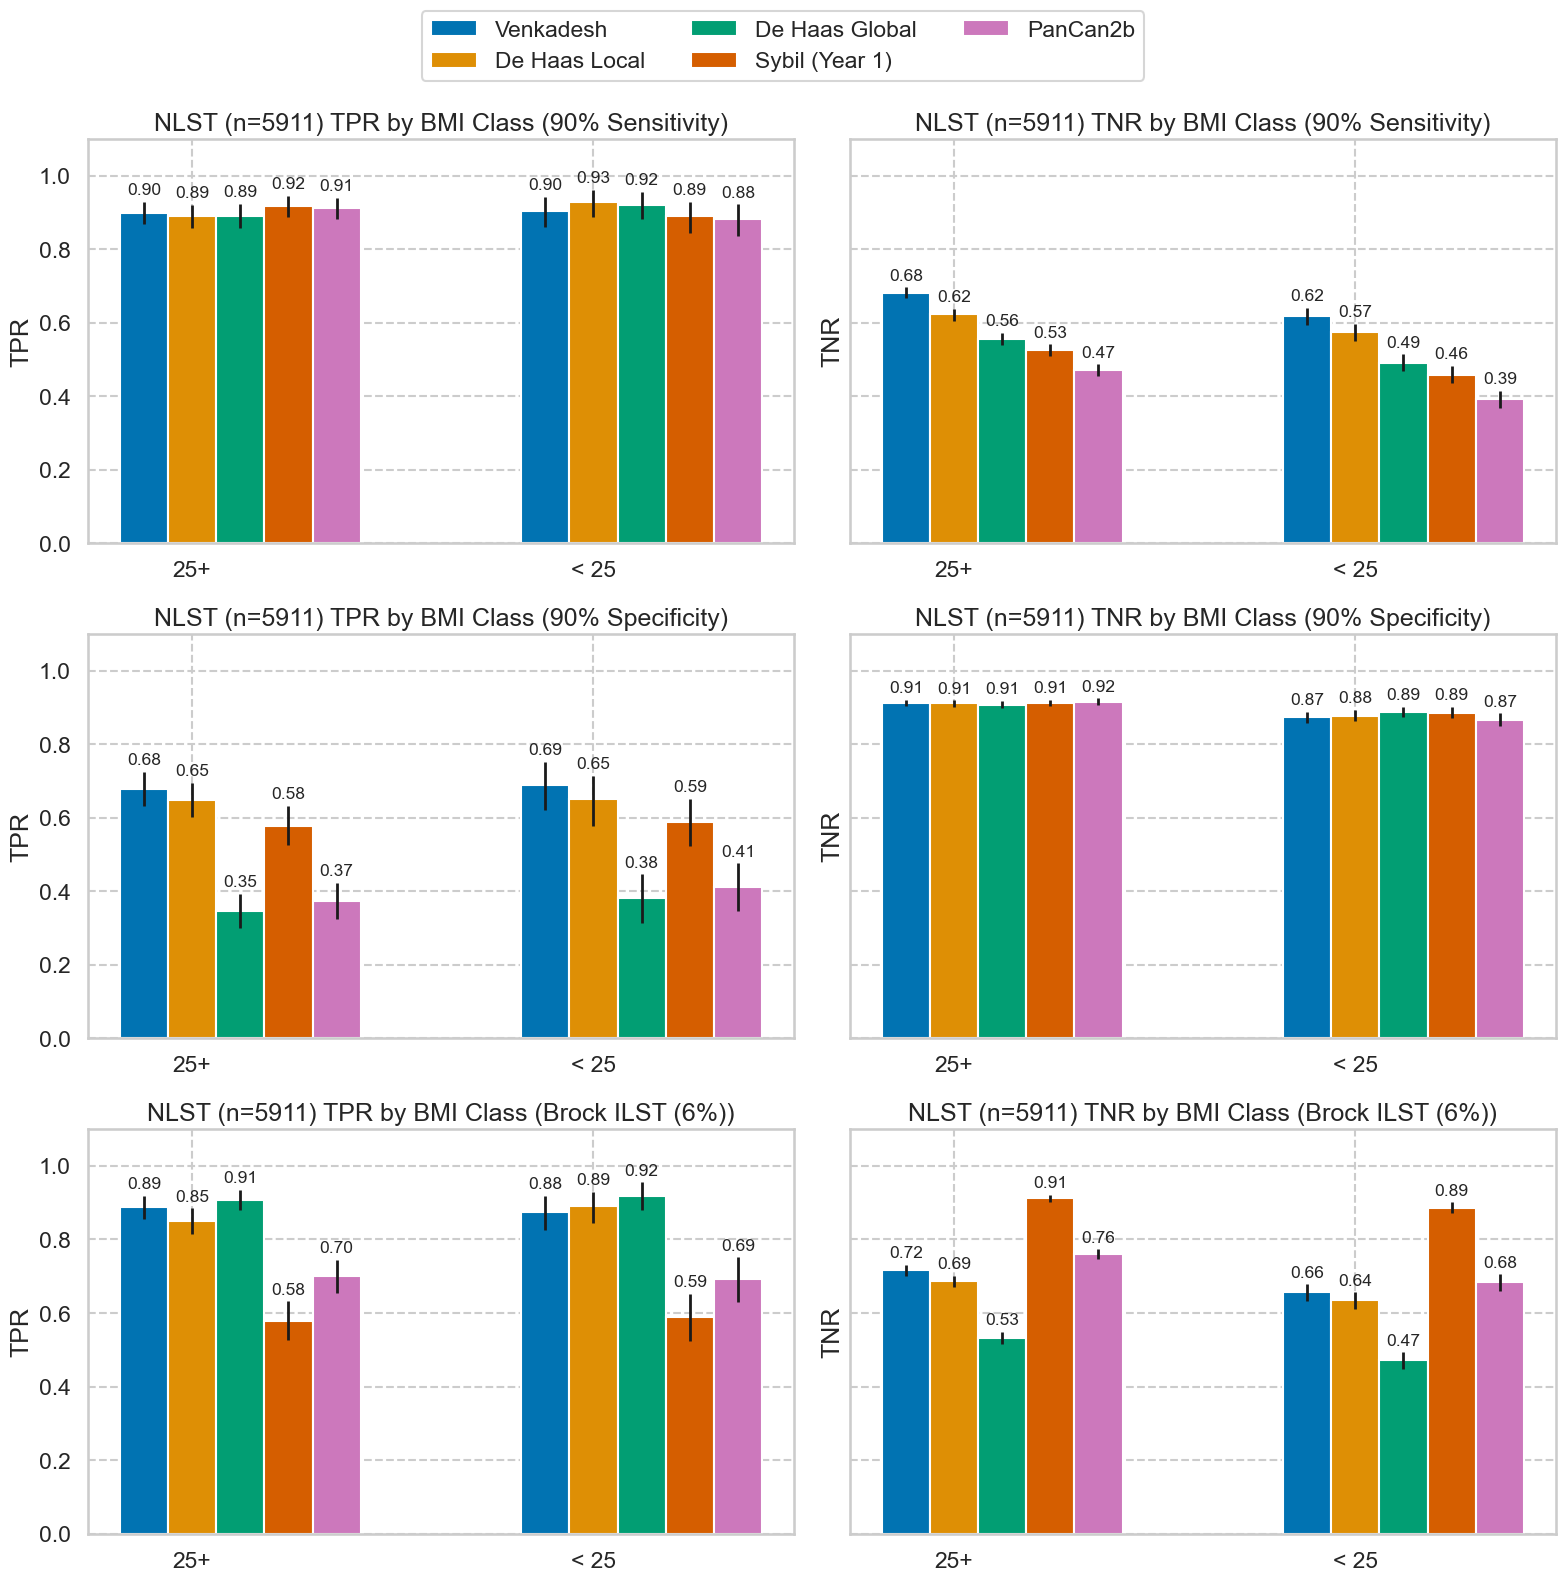

In [49]:
print(nlst_demos_to_include)
for col in nlst_demos_to_include:
    _ = threshold.plot_threshold_stats_subgroups(nlst_5911, col, dataset_name='NLST',
                                                policies=nlst_5911_policies, models=NLST_5911_MODELCOLS, 
                                                stats=threshold_nlst_5911.query(f'attribute == "{col}"'),
                                                plot_metrics=['TPR', 'TNR'], diff=False, show_mb_count=False,
                                                imgpath=f"{FIG_DIR}/threshold-NLST-5911/{col}.png"
                                                )  

## Threshold Tables

In [50]:
def metric_outside_ci(val_is_outside_ci):
    return "*" if val_is_outside_ci else ""

def ci_dont_intersect(ci_notouch):
    return "**" if ci_notouch else ""

def check_ci(val_is_outside_ci, ci_notouch):
    if ci_notouch and val_is_outside_ci:
        return "**"
    if ci_notouch and not val_is_outside_ci:
        return "???"
    if val_is_outside_ci and not ci_notouch:
        return "*"
    if not val_is_outside_ci and not ci_notouch:
        return ""

def threshold_results_pretty(df, model_order, metric='FPR', precision=TABLE_SCORE_PRECISION):
    df['model'] = df.apply(lambda row: COL_TO_MODEL[row['col']], axis=1)
    df = df.query('Group_1 != "ALL" & Group_2 != "ALL"').drop_duplicates(subset='comp_id')

    ## Get metric info in nice interval notation.
    df[f'Group_1_{metric}'] = df.apply(lambda row: pretty_interval(row, precision, group_num=1, metric=metric), axis=1)
    df[f'Group_2_{metric}'] = df.apply(lambda row: pretty_interval(row, precision, group_num=2, metric=metric), axis=1)


    df1 = df[['comp_id', 'model', 'policy', 'category', 'attribute', 'Group_1', f'Group_1_{metric}', 'Group_1_mal', f'{metric}_diff']].rename(columns={
        'Group_1': 'Group', f'Group_1_{metric}': metric, 'Group_1_mal': 'Malignant Scans'})
    # df1['CI'] = df1.apply(lambda row: metric_outside_ci(row['CI']), axis=1)
    # df1['CI'] = df1.apply(lambda row: f"{row[f'{metric}_diff']:.{precision}f}", axis=1)
    df1['CI'] = "" * len(df1)
    df1['comp_id'] = df1.apply(lambda row: row['comp_id'].split(row['policy'])[1][1:], axis=1)

    df2 = df[['comp_id', 'model', 'policy', 'category', 'attribute', 'Group_2', f'Group_2_{metric}', 'Group_2_mal', f"{metric}_outside_CI", f"{metric}_CI_notouch"]].rename(columns={
        'Group_2': 'Group', f'Group_2_{metric}': metric, 'Group_2_mal': 'Malignant Scans'})
    df2['CI'] = df2.apply(lambda row: check_ci(row[f"{metric}_outside_CI"], row[f"{metric}_CI_notouch"]), axis=1)
    df2['comp_id'] = df2.apply(lambda row: row['comp_id'].split(row['policy'])[1][1:], axis=1)
    df_res = pd.concat([df1, df2])


    if df_res['category'].iloc[0] in data.rename_types.keys():
        df_res['Category'] = df_res.apply(lambda row: data.rename_types[row['category']], axis=1)
    else:
        df_res['Category'] = df_res['category']
    
    if df_res['attribute'].iloc[0] in data.rename_cols.keys():
        df_res['Attribute'] = df_res.apply(lambda row: prettify_result_val(row['attribute'], row['Group'])[0], axis=1)
        df_res['Group'] = df_res.apply(lambda row: prettify_result_val(row['attribute'], row['Group'])[1], axis=1)
    else:
        df_res['Attribute'] = df_res['attribute']

    df_res = df_res.set_index(pd.MultiIndex.from_frame(df_res[['policy', 'Category', 'Attribute', 'Group']]))
    model_results = {m: dfm[[metric, 'CI']] for m, dfm in df_res.groupby('model')}
    
    df_out = pd.concat(model_results, axis=1)
    df_out['Malignant Scans'] = df_res['Malignant Scans'].drop_duplicates()
    df_out = df_out.sort_values(by='Malignant Scans', ascending=False)
    
    df_out = df_out.sort_index(ascending=True, level=['policy', 'Category', 'Attribute'], sort_remaining=False)[model_order]
    return df_out

### DLCST

In [51]:
dlcst_demos_to_include = ['Age Class', 'Gender']
pairwise_tpr_dlcst = threshold.all_attribute_pairwise_comparisons(threshold_dlcst, metric="TPR")
threshold_tpr_dlcst = threshold_results_pretty(pairwise_tpr_dlcst, model_order=list(DLCST_MODELCOLS.keys()), metric='TPR')
tpr_dlcst_demo = threshold_tpr_dlcst.xs("Demographics", level='Category').query('Attribute in @dlcst_demos_to_include & policy in @POLICIES_TO_USE')
tpr_dlcst_demo

Venkadesh      De Haas Combined      \
                                                TPR CI                TPR  CI   
policy          Attribute Group                                                 
90% Sensitivity Age Class > 61    0.94 (0.84, 1.00)     0.87 (0.76, 0.97)       
                          ≤ 61    0.89 (0.77, 1.00)     0.96 (0.88, 1.00)       
                Gender    Male    0.88 (0.75, 1.00)     0.84 (0.70, 0.96)       
                          Female  0.96 (0.88, 1.00)     1.00 (1.00, 1.00)  **   
90% Specificity Age Class > 61    0.84 (0.70, 0.96)     0.81 (0.67, 0.94)       
                          ≤ 61    0.71 (0.55, 0.88)     0.75 (0.58, 0.90)       
                Gender    Male    0.78 (0.64, 0.93)     0.75 (0.59, 0.90)       
                          Female  0.78 (0.62, 0.93)     0.81 (0.67, 0.96)       
Brock ILST (6%) Age Class > 61    0.94 (0.84, 1.00)     0.94 (0.84, 1.00)       
                          ≤ 61    0.96 (0.88, 1.00)     0.96 (0.88, 1.00)       
                Gender    Male    0.91 (0.79, 1.00)     0.91 (0.79, 1.00)       
                          Female  1.00 (1.00, 1.00)     1.00 (1.00, 1.00)       

                                           PanCan2b        Sybil (Year 1)     
                                                TPR CI                TPR CI  
policy          Attribute Group                                               
90% Sensitivity Age Class > 61    0.87 (0.75, 0.97)     0.97 (0.89, 1.00)     
                          ≤ 61    0.96 (0.88, 1.00)     0.96 (0.88, 1.00)     
                Gender    Male    0.88 (0.75, 0.97)     0.94 (0.84, 1.00)     
                          Female  0.96 (0.88, 1.00)     1.00 (1.00, 1.00)     
90% Specificity Age Class > 61    0.71 (0.54, 0.87)     0.71 (0.55, 0.86)     
                          ≤ 61    0.61 (0.43, 0.79)     0.61 (0.42, 0.77)     
                Gender    Male    0.66 (0.48, 0.82)     0.72 (0.56, 0.88)     
                          Female  0.67 (0.48, 0.84)     0.59 (0.41, 0.78)     
Brock ILST (6%) Age Class > 61    0.71 (0.54, 0.87)     0.65 (0.48, 0.82)     
                          ≤ 61    0.68 (0.50, 0.85)     0.39 (0.22, 0.57)  *  
                Gender    Male    0.69 (0.52, 0.85)     0.56 (0.39, 0.73)     
                          Female  0.70 (0.52, 0.88)     0.48 (0.30, 0.68)

In [52]:
print(tpr_dlcst_demo.style
      .format(na_rep='', escape='latex-math')
      .format_index(escape='latex-math', axis=1)
      .format_index(escape='latex-math', axis=0)
      .format(latex_replace_arrowbrackets)
      .format_index(latex_replace_arrowbrackets)
      .to_latex(
    buf=f"{TAB_DIR}/resDLCSTdemoTPR.tex",
    hrules=True, label='tab:resDLCSTdemoTPR', environment='table*', column_format=f'lll{"|ll"*len(dlcst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Sensitivity (TPR) with 95\% Confidence Intervals (CI) for models on demographic characteristics when evaluated on the DLCST validation set (n=599 scans). Single asterisk (*) = TPR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


In [53]:
pairwise_tnr_dlcst = threshold.all_attribute_pairwise_comparisons(threshold_dlcst, metric='TNR')
threshold_tnr_dlcst = threshold_results_pretty(pairwise_tnr_dlcst, model_order=list(DLCST_MODELCOLS.keys()), metric='TNR')
tnr_dlcst_demo = threshold_tnr_dlcst.xs("Demographics", level='Category').query('Attribute in @dlcst_demos_to_include & policy in @POLICIES_TO_USE')
tnr_dlcst_demo

Venkadesh       De Haas Combined     \
                                                TNR  CI                TNR CI   
policy          Attribute Group                                                 
90% Sensitivity Age Class > 61    0.83 (0.77, 0.89)      0.77 (0.70, 0.84)      
                          ≤ 61    0.87 (0.83, 0.90)      0.78 (0.74, 0.82)      
                Gender    Male    0.88 (0.84, 0.92)      0.81 (0.76, 0.85)      
                          Female  0.83 (0.78, 0.87)   *  0.75 (0.69, 0.80)  *   
90% Specificity Age Class > 61    0.86 (0.81, 0.92)      0.85 (0.79, 0.91)      
                          ≤ 61    0.91 (0.88, 0.94)      0.92 (0.89, 0.94)  *   
                Gender    Male    0.92 (0.89, 0.95)      0.90 (0.87, 0.93)      
                          Female  0.88 (0.83, 0.91)   *  0.90 (0.86, 0.93)      
Brock ILST (6%) Age Class > 61    0.69 (0.61, 0.76)      0.68 (0.59, 0.75)      
                          ≤ 61    0.73 (0.68, 0.78)      0.67 (0.62, 0.72)      
                Gender    Male    0.77 (0.72, 0.82)      0.70 (0.64, 0.75)      
                          Female  0.66 (0.60, 0.72)  **  0.64 (0.59, 0.70)      

                                           PanCan2b         Sybil (Year 1)     
                                                TNR  CI                TNR CI  
policy          Attribute Group                                                
90% Sensitivity Age Class > 61    0.65 (0.57, 0.73)      0.13 (0.08, 0.18)     
                          ≤ 61    0.72 (0.68, 0.76)      0.17 (0.14, 0.21)     
                Gender    Male    0.78 (0.74, 0.83)      0.16 (0.13, 0.21)     
                          Female  0.61 (0.55, 0.66)  **  0.16 (0.11, 0.20)     
90% Specificity Age Class > 61    0.84 (0.78, 0.90)      0.86 (0.80, 0.92)     
                          ≤ 61    0.92 (0.89, 0.95)   *  0.93 (0.90, 0.95)  *  
                Gender    Male    0.93 (0.90, 0.96)      0.93 (0.90, 0.96)     
                          Female  0.86 (0.81, 0.90)  **  0.89 (0.85, 0.92)  *  
Brock ILST (6%) Age Class > 61    0.80 (0.73, 0.86)      0.93 (0.89, 0.97)     
                          ≤ 61    0.86 (0.83, 0.90)   *  0.96 (0.94, 0.98)     
                Gender    Male    0.89 (0.86, 0.92)      0.95 (0.92, 0.97)     
                          Female  0.80 (0.74, 0.84)  **  0.96 (0.93, 0.98)

In [54]:
print(tnr_dlcst_demo.style
      .format(na_rep='', escape='latex-math')
      .format_index(escape='latex-math', axis=1)
      .format_index(escape='latex-math', axis=0)
      .format(latex_replace_arrowbrackets)
      .format_index(latex_replace_arrowbrackets)
      .to_latex(
    buf=f"{TAB_DIR}/resDLCSTdemoTNR.tex",
    hrules=True, label='tab:resDLCSTdemoTNR', environment='table*', column_format=f'lll{"|ll"*len(dlcst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Specificity (TNR) with 95\% Confidence Intervals (CI) for models on demographic characteristics when evaluated on the DLCST validation set (n=599 scans). Single asterisk (*) = TNR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


### NLST 1172

In [55]:
pairwise_tpr_1172 = threshold.all_attribute_pairwise_comparisons(threshold_nlst_1172, metric="TPR")
threshold_tpr = threshold_results_pretty(pairwise_tpr_1172, model_order=list(NLST_1172_MODELCOLS.keys()), metric='TPR')

In [56]:
set(invalid_attributes_1172).intersection(set(nlst_demos_to_include))

{'HS Education', 'Race'}

In [57]:
tpr_demo_1172 = threshold_tpr.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include & policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_1172')
tpr_demo_1172 = tpr_demo_1172[['De Haas Combined', 'De Haas Local', 'De Haas Global']]
tpr_demo_1172

De Haas Combined         De Haas Local  \
                                                   TPR CI                TPR   
policy          Attribute    Group                                             
90% Sensitivity Age Class    > 61    0.90 (0.82, 0.96)     0.90 (0.83, 0.96)   
                             ≤ 61    0.92 (0.83, 0.98)     0.92 (0.83, 0.98)   
                BMI Class    25+     0.89 (0.82, 0.95)     0.90 (0.84, 0.96)   
                             < 25    0.93 (0.86, 1.00)     0.91 (0.82, 0.98)   
                Gender       Male    0.91 (0.84, 0.97)     0.91 (0.84, 0.97)   
                             Female  0.90 (0.80, 0.98)     0.90 (0.80, 0.98)   
                Height Class > 68    0.90 (0.82, 0.97)     0.90 (0.83, 0.97)   
                             ≤ 68    0.91 (0.83, 0.98)     0.91 (0.84, 0.98)   
                Weight Class ≤ 180   0.89 (0.81, 0.96)     0.89 (0.81, 0.96)   
                             > 180   0.93 (0.86, 0.98)     0.93 (0.86, 0.98)   
90% Specificity Age Class    > 61    0.60 (0.49, 0.72)     0.64 (0.53, 0.74)   
                             ≤ 61    0.67 (0.53, 0.80)     0.63 (0.49, 0.76)   
                BMI Class    25+     0.61 (0.51, 0.71)     0.62 (0.52, 0.72)   
                             < 25    0.67 (0.53, 0.80)     0.67 (0.52, 0.80)   
                Gender       Male    0.59 (0.48, 0.71)     0.61 (0.50, 0.72)   
                             Female  0.69 (0.56, 0.82)     0.69 (0.55, 0.82)   
                Height Class > 68    0.60 (0.48, 0.71)     0.59 (0.47, 0.70)   
                             ≤ 68    0.67 (0.54, 0.79)     0.70 (0.59, 0.82)   
                Weight Class ≤ 180   0.68 (0.58, 0.79)     0.67 (0.56, 0.78)   
                             > 180   0.56 (0.42, 0.69)     0.59 (0.46, 0.72)   
Brock ILST (6%) Age Class    > 61    0.90 (0.82, 0.96)     0.85 (0.76, 0.92)   
                             ≤ 61    0.92 (0.83, 0.98)     0.90 (0.80, 0.98)   
                BMI Class    25+     0.89 (0.82, 0.95)     0.88 (0.81, 0.95)   
                             < 25    0.93 (0.86, 1.00)     0.84 (0.73, 0.94)   
                Gender       Male    0.91 (0.84, 0.97)     0.87 (0.79, 0.94)   
                             Female  0.90 (0.80, 0.98)     0.85 (0.75, 0.94)   
                Height Class > 68    0.90 (0.82, 0.97)     0.87 (0.79, 0.95)   
                             ≤ 68    0.91 (0.83, 0.98)     0.86 (0.77, 0.95)   
                Weight Class ≤ 180   0.89 (0.81, 0.96)     0.85 (0.76, 0.93)   
                             > 180   0.93 (0.86, 0.98)     0.89 (0.80, 0.97)   

                                           De Haas Global     
                                    CI                TPR CI  
policy          Attribute    Group                            
90% Sensitivity Age Class    > 61       0.87 (0.79, 0.94)     
                             ≤ 61       0.96 (0.89, 1.00)  *  
                BMI Class    25+        0.89 (0.82, 0.95)     
                             < 25       0.93 (0.85, 1.00)     
                Gender       Male       0.92 (0.86, 0.98)     
                             Female     0.88 (0.77, 0.96)     
                Height Class > 68       0.91 (0.84, 0.97)     
                             ≤ 68       0.89 (0.81, 0.96)     
                Weight Class ≤ 180      0.92 (0.85, 0.97)     
                             > 180      0.89 (0.80, 0.96)     
90% Specificity Age Class    > 61       0.29 (0.20, 0.40)     
                             ≤ 61       0.31 (0.17, 0.45)     
                BMI Class    25+        0.28 (0.19, 0.38)     
                             < 25       0.33 (0.20, 0.47)     
                Gender       Male       0.34 (0.24, 0.45)     
                             Female     0.23 (0.12, 0.35)     
                Height Class > 68       0.31 (0.21, 0.42)     
                             ≤ 68       0.28 (0.17, 0.40)     
                Weight Class ≤ 180      0.26 (0.16, 0.36)     
           

In [58]:
print(tpr_demo_1172.style
      .format(na_rep='', escape='latex-math')
      .format_index(escape='latex-math', axis=1)
      .format_index(escape='latex-math', axis=0)
      .format(latex_replace_arrowbrackets)
      .format_index(latex_replace_arrowbrackets)
      .to_latex(
    buf=f"{TAB_DIR}/resNLSTtijmenTPR.tex",
    hrules=True, label='tab:resNLSTtijmenTPR', environment='table*', column_format=f'lll{"|ll"*3}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Sensitivity (TPR) with 95\% Confidence Intervals (CI) for the De Haas Combined model and its submodels on demographic characteristics when evaluated on the partial NLST validation set (n=1172 scans). Race and High School Education analysis are not included since there are less than 15 malignant scans in the underrepresented subgroup. Single asterisk (*) = TPR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


In [59]:
pairwise_tnr_1172 = threshold.all_attribute_pairwise_comparisons(threshold_nlst_1172, metric='TNR')
tnr_1172 = threshold_results_pretty(pairwise_tnr_1172, model_order=list(NLST_1172_MODELCOLS.keys()), metric='TNR')
tnr_1172.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include & policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_1172')

Venkadesh       De Haas Combined  \
                                                   TNR  CI                TNR   
policy          Attribute    Group                                              
90% Sensitivity Age Class    > 61    0.52 (0.48, 0.56)      0.62 (0.58, 0.66)   
                             ≤ 61    0.56 (0.52, 0.61)   *  0.65 (0.61, 0.69)   
                BMI Class    25+     0.57 (0.53, 0.61)      0.66 (0.63, 0.70)   
                             < 25    0.46 (0.41, 0.52)  **  0.57 (0.52, 0.62)   
                Gender       Male    0.54 (0.50, 0.58)      0.66 (0.63, 0.70)   
                             Female  0.53 (0.48, 0.57)      0.60 (0.55, 0.64)   
                Height Class > 68    0.55 (0.52, 0.59)      0.66 (0.62, 0.70)   
                             ≤ 68    0.52 (0.47, 0.56)      0.61 (0.57, 0.65)   
                Weight Class ≤ 180   0.50 (0.46, 0.54)      0.59 (0.56, 0.64)   
                             > 180   0.57 (0.53, 0.62)   *  0.68 (0.63, 0.72)   
90% Specificity Age Class    > 61    0.88 (0.86, 0.91)      0.91 (0.89, 0.94)   
                             ≤ 61    0.92 (0.90, 0.94)   *  0.88 (0.85, 0.91)   
                BMI Class    25+     0.92 (0.90, 0.94)      0.91 (0.88, 0.93)   
                             < 25    0.86 (0.82, 0.89)  **  0.89 (0.85, 0.92)   
                Gender       Male    0.91 (0.89, 0.93)      0.90 (0.88, 0.93)   
                             Female  0.88 (0.85, 0.91)   *  0.90 (0.87, 0.93)   
                Height Class > 68    0.92 (0.90, 0.95)      0.90 (0.87, 0.93)   
                             ≤ 68    0.88 (0.85, 0.90)   *  0.90 (0.87, 0.93)   
                Weight Class ≤ 180   0.88 (0.86, 0.91)      0.89 (0.86, 0.91)   
                             > 180   0.92 (0.89, 0.94)   *  0.91 (0.89, 0.94)   
Brock ILST (6%) Age Class    > 61    0.65 (0.62, 0.69)      0.61 (0.57, 0.64)   
                             ≤ 61    0.71 (0.67, 0.75)   *  0.62 (0.57, 0.66)   
                BMI Class    25+     0.70 (0.67, 0.74)      0.64 (0.60, 0.68)   
                             < 25    0.62 (0.57, 0.67)   *  0.54 (0.49, 0.60)   
                Gender       Male    0.68 (0.64, 0.71)      0.64 (0.60, 0.67)   
                             Female  0.68 (0.64, 0.72)      0.57 (0.52, 0.62)   
                Height Class > 68    0.70 (0.66, 0.73)      0.63 (0.59, 0.68)   
                             ≤ 68    0.66 (0.62, 0.70)      0.59 (0.55, 0.63)   
                Weight Class ≤ 180   0.65 (0.61, 0.69)      0.57 (0.54, 0.62)   
                             > 180   0.70 (0.66, 0.74)   *  0.65 (0.61, 0.69)   

                                             De Haas Local     \
                                     CI                TNR CI   
policy          Attribute    Group                              
90% Sensitivity Age Class    > 61        0.60 (0.56, 0.64)      
                             ≤ 61        0.63 (0.59, 0.67)      
                BMI Class    25+         0.64 (0.60, 0.67)      
                             < 25    **  0.56 (0.51, 0.61)  *   
                Gender       Male        0.62 (0.58, 0.66)      
                             Female   *  0.60 (0.55, 0.64)      
                Height Class > 68        0.62 (0.57, 0.66)      
                             ≤ 68     *  0.61 (0.57, 0.64)      
                Weight Class ≤ 180       0.60 (0.56, 0.64)      
                             > 180    *  0.62 (0.58, 0.67)      
90% Specificity Age Class    > 61        0.89 (0.86, 0.91)      
                             ≤ 61     *  0.92 (0.90, 0.95)  *   
                BMI Class    25+         0.92 (0.90, 0.94)      
                             < 25        0.87 (0.83, 0.90)  *   
                Gender       Male        0.91 (0.89, 0.93)      
                             Female      0.89 (0.86, 0.92)      
                Height Class > 68        0.92 (0.89, 0.94)      
                             ≤ 68        0.89 (0.86, 0.91)  *   
      

In [60]:
tnr_demo_1172 = tnr_1172.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include & policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_1172')
tnr_demo_1172 = tnr_demo_1172[['De Haas Combined', 'De Haas Local', 'De Haas Global']]
tnr_demo_1172

De Haas Combined          De Haas Local  \
                                                   TNR  CI                TNR   
policy          Attribute    Group                                              
90% Sensitivity Age Class    > 61    0.62 (0.58, 0.66)      0.60 (0.56, 0.64)   
                             ≤ 61    0.65 (0.61, 0.69)      0.63 (0.59, 0.67)   
                BMI Class    25+     0.66 (0.63, 0.70)      0.64 (0.60, 0.67)   
                             < 25    0.57 (0.52, 0.62)  **  0.56 (0.51, 0.61)   
                Gender       Male    0.66 (0.63, 0.70)      0.62 (0.58, 0.66)   
                             Female  0.60 (0.55, 0.64)   *  0.60 (0.55, 0.64)   
                Height Class > 68    0.66 (0.62, 0.70)      0.62 (0.57, 0.66)   
                             ≤ 68    0.61 (0.57, 0.65)   *  0.61 (0.57, 0.64)   
                Weight Class ≤ 180   0.59 (0.56, 0.64)      0.60 (0.56, 0.64)   
                             > 180   0.68 (0.63, 0.72)   *  0.62 (0.58, 0.67)   
90% Specificity Age Class    > 61    0.91 (0.89, 0.94)      0.89 (0.86, 0.91)   
                             ≤ 61    0.88 (0.85, 0.91)   *  0.92 (0.90, 0.95)   
                BMI Class    25+     0.91 (0.88, 0.93)      0.92 (0.90, 0.94)   
                             < 25    0.89 (0.85, 0.92)      0.87 (0.83, 0.90)   
                Gender       Male    0.90 (0.88, 0.93)      0.91 (0.89, 0.93)   
                             Female  0.90 (0.87, 0.93)      0.89 (0.86, 0.92)   
                Height Class > 68    0.90 (0.87, 0.93)      0.92 (0.89, 0.94)   
                             ≤ 68    0.90 (0.87, 0.93)      0.89 (0.86, 0.91)   
                Weight Class ≤ 180   0.89 (0.86, 0.91)      0.89 (0.86, 0.91)   
                             > 180   0.91 (0.89, 0.94)   *  0.91 (0.89, 0.94)   
Brock ILST (6%) Age Class    > 61    0.61 (0.57, 0.64)      0.64 (0.60, 0.67)   
                             ≤ 61    0.62 (0.57, 0.66)      0.67 (0.62, 0.71)   
                BMI Class    25+     0.64 (0.60, 0.68)      0.68 (0.64, 0.71)   
                             < 25    0.54 (0.49, 0.60)  **  0.59 (0.54, 0.64)   
                Gender       Male    0.64 (0.60, 0.67)      0.66 (0.62, 0.69)   
                             Female  0.57 (0.52, 0.62)   *  0.63 (0.59, 0.68)   
                Height Class > 68    0.63 (0.59, 0.68)      0.66 (0.61, 0.70)   
                             ≤ 68    0.59 (0.55, 0.63)      0.64 (0.60, 0.68)   
                Weight Class ≤ 180   0.57 (0.54, 0.62)      0.64 (0.60, 0.68)   
                             > 180   0.65 (0.61, 0.69)   *  0.66 (0.62, 0.70)   

                                           De Haas Global      
                                    CI                TNR  CI  
policy          Attribute    Group                             
90% Sensitivity Age Class    > 61       0.54 (0.50, 0.58)      
                             ≤ 61       0.49 (0.44, 0.53)   *  
                BMI Class    25+        0.55 (0.51, 0.58)      
                             < 25    *  0.45 (0.40, 0.50)  **  
                Gender       Male       0.55 (0.51, 0.59)      
                             Female     0.47 (0.42, 0.52)   *  
                Height Class > 68       0.56 (0.52, 0.61)      
                             ≤ 68       0.47 (0.43, 0.51)  **  
                Weight Class ≤ 180      0.46 (0.41, 0.50)      
                             > 180      0.58 (0.53, 0.62)  **  
90% Specificity Age Class    > 61       0.91 (0.88, 0.93)      
                             ≤ 61    *  0.89 (0.86, 0.92)      
                BMI Class    25+        0.91 (0.89, 0.93)      
                             < 25    *  0.88 (0.85, 0.92)      
                Gender       Male       0.90 (0.88, 0.92)      
                             Female     0.90 (0.87, 0.93)      
                Height Class > 68       0.90 (0.87, 0.93)      
                             ≤ 68    *  0.90 (0.88, 0.92)      
                Weig

In [61]:
print(tnr_demo_1172.style
      .format(na_rep='', escape='latex-math')
      .format_index(escape='latex-math', axis=1)
      .format_index(escape='latex-math', axis=0)
      .format(latex_replace_arrowbrackets)
      .format_index(latex_replace_arrowbrackets)
      .to_latex(
    buf=f"{TAB_DIR}/resNLSTtijmenTNR.tex",
    hrules=True, label='tab:resNLSTtijmenTNR', environment='table*', column_format=f'lll{"|ll"*3}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Specificity (TNR) with 95\% Confidence Intervals (CI) for the De Haas Combined model and its submodels on demographic characteristics when evaluated on the partial NLST validation set (n=1172 scans). Race and High School Education analysis are not included since there are less than 15 malignant scans in the underrepresented subgroup. Single asterisk (*) = TNR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


### NLST 5911

In [62]:
nlst_demos_to_include

['Age Class',
 'Gender',
 'Race',
 'HS Education',
 'Height Class',
 'Weight Class',
 'BMI Class']

In [63]:
pairwise_tpr_5911 = threshold.all_attribute_pairwise_comparisons(threshold_nlst_5911, metric="TPR")
threshold_tpr = threshold_results_pretty(pairwise_tpr_5911, model_order=list(NLST_5911_MODELCOLS.keys()), metric='TPR')
threshold_tpr.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include & policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_5911')

Venkadesh          De Haas Local  \
                                                   TPR  CI                TPR   
policy          Attribute    Group                                              
90% Sensitivity Age Class    > 61    0.90 (0.86, 0.93)      0.90 (0.87, 0.93)   
                             ≤ 61    0.91 (0.87, 0.94)      0.91 (0.88, 0.95)   
                BMI Class    25+     0.90 (0.87, 0.93)      0.89 (0.86, 0.92)   
                             < 25    0.90 (0.86, 0.94)      0.93 (0.89, 0.96)   
                Gender       Male    0.90 (0.87, 0.93)      0.89 (0.86, 0.92)   
                             Female  0.90 (0.86, 0.93)      0.92 (0.89, 0.95)   
                Height Class ≤ 68    0.90 (0.87, 0.94)      0.92 (0.89, 0.95)   
                             > 68    0.90 (0.85, 0.93)      0.89 (0.85, 0.92)   
                Race         White   0.90 (0.88, 0.93)      0.90 (0.87, 0.93)   
                             Black   0.82 (0.67, 0.96)      0.89 (0.77, 1.00)   
                Weight Class ≤ 180   0.91 (0.87, 0.94)      0.91 (0.88, 0.94)   
                             > 180   0.89 (0.85, 0.93)      0.89 (0.86, 0.93)   
90% Specificity Age Class    > 61    0.70 (0.66, 0.75)      0.67 (0.62, 0.71)   
                             ≤ 61    0.65 (0.58, 0.71)      0.62 (0.56, 0.68)   
                BMI Class    25+     0.68 (0.63, 0.72)      0.65 (0.60, 0.70)   
                             < 25    0.69 (0.62, 0.75)      0.65 (0.58, 0.71)   
                Gender       Male    0.66 (0.61, 0.71)      0.64 (0.59, 0.68)   
                             Female  0.71 (0.65, 0.77)      0.67 (0.61, 0.73)   
                Height Class ≤ 68    0.70 (0.65, 0.75)      0.67 (0.61, 0.72)   
                             > 68    0.66 (0.61, 0.72)      0.63 (0.57, 0.68)   
                Race         White   0.69 (0.65, 0.73)      0.65 (0.61, 0.69)   
                             Black   0.39 (0.23, 0.59)  **  0.46 (0.28, 0.64)   
                Weight Class ≤ 180   0.69 (0.64, 0.73)      0.66 (0.61, 0.71)   
                             > 180   0.68 (0.62, 0.73)      0.63 (0.57, 0.69)   
Brock ILST (6%) Age Class    > 61    0.88 (0.84, 0.91)      0.85 (0.81, 0.89)   
                             ≤ 61    0.89 (0.85, 0.93)      0.89 (0.85, 0.93)   
                BMI Class    25+     0.89 (0.86, 0.92)      0.85 (0.81, 0.88)   
                             < 25    0.88 (0.83, 0.92)      0.89 (0.84, 0.93)   
                Gender       Male    0.88 (0.85, 0.91)      0.85 (0.81, 0.89)   
                             Female  0.89 (0.85, 0.92)      0.89 (0.84, 0.92)   
                Height Class ≤ 68    0.89 (0.85, 0.92)      0.87 (0.83, 0.91)   
                             > 68    0.88 (0.84, 0.91)      0.86 (0.82, 0.90)   
                Race         White   0.89 (0.86, 0.91)      0.86 (0.83, 0.89)   
                             Black   0.75 (0.59, 0.91)      0.79 (0.64, 0.92)   
                Weight Class ≤ 180   0.88 (0.84, 0.91)      0.87 (0.83, 0.91)   
                             > 180   0.89 (0.85, 0.93)      0.85 (0.81, 0.90)   

                                           De Haas Global     \
                                    CI                TPR CI   
policy          Attribute    Group                             
90% Sensitivity Age Class    > 61       0.89 (0.86, 0.92)      
                             ≤ 61       0.91 (0.88, 0.95)      
                BMI Class    25+        0.89 (0.86, 0.92)      
                             < 25       0.92 (0.88, 0.96)      
                Gender       Male       0.91 (0.88, 0.94)      
                             Female     0.89 (0.85, 0.93)      
                Height Class ≤ 68       0.90 (0.87, 0.93)      
                             > 68       0.90 (0.86, 0.93)      
                Race         White      0.90 (0.87, 0.92)      
                             Black      0.96 (0.88, 1.00)      
                Weight Class ≤ 180      0.91 (0.88, 0

In [64]:
pairwise_tnr_5911 = threshold.all_attribute_pairwise_comparisons(threshold_nlst_5911, metric="TNR")
threshold_tnr = threshold_results_pretty(pairwise_tnr_5911, model_order=list(NLST_5911_MODELCOLS.keys()), metric='TNR')
threshold_tnr.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include & policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_5911')

Venkadesh          De Haas Local  \
                                                   TNR  CI                TNR   
policy          Attribute    Group                                              
90% Sensitivity Age Class    > 61    0.63 (0.62, 0.65)      0.59 (0.57, 0.60)   
                             ≤ 61    0.70 (0.68, 0.71)  **  0.63 (0.61, 0.65)   
                BMI Class    25+     0.68 (0.67, 0.70)      0.62 (0.61, 0.64)   
                             < 25    0.62 (0.59, 0.64)  **  0.57 (0.55, 0.60)   
                Gender       Male    0.65 (0.63, 0.66)      0.61 (0.59, 0.63)   
                             Female  0.68 (0.66, 0.70)   *  0.61 (0.59, 0.63)   
                Height Class ≤ 68    0.68 (0.66, 0.69)      0.61 (0.60, 0.63)   
                             > 68    0.64 (0.63, 0.66)   *  0.60 (0.58, 0.62)   
                Race         White   0.66 (0.65, 0.67)      0.61 (0.59, 0.62)   
                             Black   0.73 (0.66, 0.79)   *  0.59 (0.52, 0.66)   
                Weight Class ≤ 180   0.65 (0.63, 0.67)      0.59 (0.57, 0.61)   
                             > 180   0.67 (0.66, 0.69)   *  0.63 (0.61, 0.65)   
90% Specificity Age Class    > 61    0.88 (0.87, 0.89)      0.89 (0.88, 0.90)   
                             ≤ 61    0.92 (0.91, 0.93)  **  0.92 (0.90, 0.93)   
                BMI Class    25+     0.91 (0.90, 0.92)      0.91 (0.90, 0.92)   
                             < 25    0.87 (0.86, 0.89)  **  0.88 (0.86, 0.89)   
                Gender       Male    0.90 (0.89, 0.91)      0.90 (0.89, 0.91)   
                             Female  0.90 (0.88, 0.91)      0.90 (0.89, 0.91)   
                Height Class ≤ 68    0.90 (0.89, 0.91)      0.91 (0.89, 0.92)   
                             > 68    0.90 (0.89, 0.91)      0.89 (0.88, 0.91)   
                Race         White   0.90 (0.89, 0.91)      0.90 (0.89, 0.91)   
                             Black   0.93 (0.89, 0.97)      0.91 (0.87, 0.96)   
                Weight Class ≤ 180   0.89 (0.88, 0.90)      0.89 (0.88, 0.91)   
                             > 180   0.91 (0.90, 0.92)  **  0.91 (0.89, 0.92)   
Brock ILST (6%) Age Class    > 61    0.67 (0.65, 0.69)      0.65 (0.63, 0.67)   
                             ≤ 61    0.73 (0.71, 0.75)  **  0.70 (0.68, 0.71)   
                BMI Class    25+     0.72 (0.70, 0.73)      0.69 (0.67, 0.70)   
                             < 25    0.66 (0.63, 0.68)  **  0.64 (0.61, 0.66)   
                Gender       Male    0.68 (0.66, 0.70)      0.66 (0.65, 0.68)   
                             Female  0.72 (0.70, 0.74)  **  0.68 (0.66, 0.70)   
                Height Class ≤ 68    0.71 (0.70, 0.73)      0.68 (0.67, 0.70)   
                             > 68    0.68 (0.66, 0.70)  **  0.65 (0.64, 0.67)   
                Race         White   0.70 (0.68, 0.71)      0.67 (0.66, 0.68)   
                             Black   0.76 (0.69, 0.82)      0.68 (0.61, 0.75)   
                Weight Class ≤ 180   0.69 (0.67, 0.70)      0.65 (0.64, 0.67)   
                             > 180   0.71 (0.69, 0.73)   *  0.69 (0.67, 0.71)   

                                            De Haas Global      \
                                     CI                TNR  CI   
policy          Attribute    Group                               
90% Sensitivity Age Class    > 61        0.54 (0.52, 0.56)       
                             ≤ 61    **  0.53 (0.51, 0.55)       
                BMI Class    25+         0.56 (0.54, 0.57)       
                             < 25    **  0.49 (0.47, 0.51)  **   
                Gender       Male        0.55 (0.53, 0.57)       
                             Female      0.51 (0.49, 0.53)   *   
                Height Class ≤ 68        0.52 (0.50, 0.54)       
                             > 68        0.55 (0.53, 0.57)   *   
                Race         White       0.54 (0.52, 0.55)       
                             Black       0.49 (0.41, 0.56)       
                Weight Clas

## Demographic Confounder Links

In [65]:
def num_with_percent(x, s, precision):
    return f'{0 if np.isnan(x[f"{s}_freq"]) else int(x[f"{s}_freq"])} ({0 if np.isnan(x[f"{s}_norm"]) else np.around(x[f"{s}_norm"], precision)})'

def confounders_by_attribute(df, attribute, cols, precision=1):
    dfsets = {val: dfv for val, dfv in df.groupby(attribute)}
    subgroups = list(dfsets.keys())
    subgroups_pretty_key = {sg: prettify_result_val(attribute, sg)[1] for sg in subgroups}

    cat_df = data.combine_diff_dfs(cols['cat'], data.diffs_category_prevalence, dfsets)
    for s in dfsets:
        cat_df[f"{subgroups_pretty_key[s]} Prevalence (\%)"] = cat_df.apply(lambda x: num_with_percent(x, s, precision), axis=1)

    cat_df = cat_df[pd.notna(cat_df['value'])]
    cat_df['category'] = cat_df.apply(lambda row: data.rename_types[row['category']], axis=1)
    cat_df['attribute2'] = cat_df.apply(lambda row: prettify_result_val(row['attribute'], row['value'])[0], axis=1)
    cat_df['value'] = cat_df.apply(lambda row: prettify_result_val(row['attribute'], row['value'])[1], axis=1)
    cat_df['attribute'] = cat_df['attribute2']
    cat_df = cat_df.set_index(pd.MultiIndex.from_frame(cat_df[['category', 'attribute', 'value']]))

    cat_df = cat_df[cat_df['attribute'] != attribute]
    cat_df = cat_df[[f"{subgroups_pretty_key[s]} Prevalence (\%)" for s in subgroups] + [f"diff_{s1}_{s2}" for s1, s2 in itertools.combinations(subgroups, 2)]]
    # cat_df = cat_df.sort_values(by=f"diff_{subgroups[0]}_{subgroups[1]}", ascending=True)
    cat_df = cat_df.sort_index(ascending=True)

    num_df = data.combine_diff_dfs(cols['num'], data.diffs_numerical_means, dfsets)
    num_df['category'] = num_df.apply(lambda row: data.rename_types[row['category']], axis=1)
    num_df['attribute2'] = num_df.apply(lambda row: prettify_result_val(row['attribute'], row['value'])[0], axis=1)
    num_df['value'] = num_df.apply(lambda row: prettify_result_val(row['attribute'], row['value'])[1], axis=1)
    num_df['attribute'] = num_df['attribute2']
    num_df = num_df.set_index(pd.MultiIndex.from_frame(num_df[['category', 'attribute', 'value']]))

    num_df = num_df[num_df['attribute'] != attribute]
    num_df = num_df[num_df['value'].isin(['Median (IQR)'])]
    num_df = num_df[[f"{s}" for s in subgroups] + [f"diff_{s1}_{s2}" for s1, s2 in itertools.combinations(subgroups, 2)]]
    num_df = num_df.rename(columns={f"{s}": subgroups_pretty_key[s] for s in subgroups})
    # num_df = num_df.sort_values(by=f"diff_{subgroups[0]}_{subgroups[1]}", ascending=True)
    num_df = num_df.sort_index(ascending=True)

    if len(subgroups) == 2:
        rename_diff = {f"diff_{subgroups[0]}_{subgroups[1]}": "Difference"}
        cat_df.rename(columns=rename_diff, inplace=True)
        num_df.rename(columns=rename_diff, inplace=True)
        cat_df["Abs Diff"] = cat_df['Difference'].abs()

    return cat_df, num_df

In [66]:
nlst_5911_v2, nlst_cols_v2, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=False, bin_num=True)
nlst_cols_v2

{'num': {'demo': ['BMI', 'Age', 'height', 'weight'],
  'smoke': ['smokeage', 'smokeday', 'smokeyr', 'pkyr'],
  'other': ['NoduleCounts', 'Diameter_mm', 'SliceCount']},
 'cat': {'demo': ['Age > 61',
   'Gender',
   'HighSchoolPlus',
   'Married',
   'NonHispanicWhite',
   'Overweight',
   'Unfinished_ed',
   'WhiteOrBlack',
   'educat',
   'ethnic',
   'height > 68',
   'marital',
   'race',
   'weight > 180'],
  'smoke': ['cigar',
   'cigsmok',
   'pipe',
   'pkyr > 55',
   'smokeage > 16',
   'smokeday > 25',
   'smokelive',
   'smokework',
   'smokeyr > 40'],
  'work': ['wrkbaki',
   'wrkfoun',
   'wrkchem',
   'wrkasbe',
   'wrkfire',
   'wrksand',
   'wrkfarm',
   'wrkcoal',
   'wrkpain',
   'wrkweld',
   'wrkflou',
   'wrkbutc',
   'wrkhard',
   'wrkcott'],
  'disease': ['diagasbe',
   'diagchas',
   'diagpneu',
   'diagstro',
   'diagemph',
   'diagbron',
   'diagsili',
   'diagsarc',
   'diaghear',
   'diagdiab',
   'diagadas',
   'diagcopd',
   'diagfibr',
   'diagtube',
   'di

In [67]:
def sort_multiindex_by_attribute(df, col='Abs Diff'):
    attribute_max = df.groupby('attribute')[col].max()
    sorted_attributes = attribute_max.sort_values(ascending=False).index

    df2 = df.reset_index()
    df2['attribute'] = pd.Categorical(df2['attribute'], categories=sorted_attributes, ordered=True)
    df2 = df2.sort_values('attribute')
    df2 = df2.set_index(['category', 'attribute', 'value'])
    return df2 

In [68]:
cat_gender, num_gender = confounders_by_attribute(nlst_5911_v2, 'Gender', nlst_cols_v2)
display(cat_gender)
display(num_gender)

cat_gender = sort_multiindex_by_attribute(cat_gender, 'Abs Diff')
cat_gender

Male Prevalence (\%)  \
category     attribute        value                                    
Demographics Age Class        > 61                       1980 (57.5)   
                              ≤ 61                       1461 (42.5)   
             BMI Class        25+                        2538 (73.8)   
                              < 25                        903 (26.2)   
             Education Status 8th grade or less             95 (2.8)   
...                                                              ...   
Work History Painting         1.0                          267 (7.8)   
             Sandblasting     0.0                        3341 (97.1)   
                              1.0                           99 (2.9)   
             Welding          0.0                        3099 (90.1)   
                              1.0                          341 (9.9)   

                                                Female Prevalence (\%)  \
category     attribute        value                                      
Demographics Age Class        > 61                         1345 (54.5)   
                              ≤ 61                         1125 (45.5)   
             BMI Class        25+                          1474 (59.7)   
                              < 25                          996 (40.3)   
             Education Status 8th grade or less               16 (0.6)   
...                                                                ...   
Work History Painting         1.0                             50 (2.0)   
             Sandblasting     0.0                          2459 (99.6)   
                              1.0                             11 (0.4)   
             Welding          0.0                          2451 (99.2)   
                              1.0                             19 (0.8)   

                                                 Difference  Abs Diff  
category     attribute        value                                    
Demographics Age Class        > 61                   3.0880    3.0880  
                              ≤ 61                  -3.0880    3.0880  
             BMI Class        25+                   14.0815   14.0815  
                              < 25                 -14.0815   14.0815  
             Education Status 8th grade or less      2.1130    2.1130  
...                                                     ...       ...  
Work History Painting         1.0                    5.7351    5.7351  
             Sandblasting     0.0                   -2.4608    2.4608  
                              1.0                    2.4318    2.4318  
             Welding          0.0                   -9.1698    9.1698  
                              1.0                    9.1407    9.1407  

[225 rows x 4 columns]

Male    Female  \
category     attribute                 value                              
Demographics Age                       Median (IQR)    63 (8)    62 (8)   
             BMI                       Median (IQR)    27 (5)    26 (7)   
             Height                    Median (IQR)    71 (3)    64 (3)   
             Weight                    Median (IQR)  192 (46)  157 (45)   
Other        Diameter (mm)             Median (IQR)     7 (5)     7 (4)   
             Nodules Per Scan          Median (IQR)     1 (1)     1 (1)   
             Slices In Scan            Median (IQR)  165 (36)  155 (36)   
Smoking      Age at Smoking Onset      Median (IQR)    16 (4)    17 (4)   
             Cigarettes per Day (avg.) Median (IQR)   30 (20)   20 (10)   
             Pack-Years                Median (IQR)   55 (35)   46 (22)   
             Total Years of Smoking    Median (IQR)   42 (10)    40 (9)   

                                                     Difference  
category     attribute                 value                     
Demographics Age                       Median (IQR)       1.000  
             BMI                       Median (IQR)       0.888  
             Height                    Median (IQR)       7.000  
             Weight                    Median (IQR)      35.000  
Other        Diameter (mm)             Median (IQR)       0.200  
             Nodules Per Scan          Median (IQR)       0.000  
             Slices In Scan            Median (IQR)      10.000  
Smoking      Age at Smoking Onset      Median (IQR)      -1.000  
             Cigarettes per Day (avg.) Median (IQR)      10.000  
             Pack-Years                Median (IQR)       9.000  
             Total Years of Smoking    Median (IQR)       2.000

Male Prevalence (\%)  \
category     attribute          value                        
Demographics Height Class       ≤ 68            820 (23.8)   
                                > 68           2621 (76.2)   
             Weight Class       > 180          2226 (64.7)   
                                ≤ 180          1215 (35.3)   
Smoking      Smoked Pipe        1.0            1256 (36.5)   
...                                                    ...   
Nodule       Non-Solid          True              31 (0.9)   
             Calcified          True               3 (0.1)   
                                False          3438 (99.9)   
Demographics Non-Hispanic White False            280 (8.1)   
                                True           3161 (91.9)   

                                      Female Prevalence (\%)  Difference  \
category     attribute          value                                      
Demographics Height Class       ≤ 68             2324 (94.1)    -70.2588   
                                > 68               146 (5.9)     70.2588   
             Weight Class       > 180             590 (23.9)     40.8039   
                                ≤ 180            1880 (76.1)    -40.8039   
Smoking      Smoked Pipe        1.0                 45 (1.8)     34.6791   
...                                                      ...         ...   
Nodule       Non-Solid          True                22 (0.9)      0.0102   
             Calcified          True                 2 (0.1)      0.0062   
                                False            2468 (99.9)     -0.0062   
Demographics Non-Hispanic White False              201 (8.1)     -0.0005   
                                True             2269 (91.9)      0.0005   

                                       Abs Diff  
category     attribute          value            
Demographics Height Class       ≤ 68    70.2588  
                                > 68    70.2588  
             Weight Class       > 180   40.8039  
                                ≤ 180   40.8039  
Smoking      Smoked Pipe        1.0     34.6791  
...                                         ...  
Nodule       Non-Solid          True     0.0102  
             Calcified          True     0.0062  
                                False    0.0062  
Demographics Non-Hispanic White False    0.0005  
                                True     0.0005  

[225 rows x 4 columns]

In [69]:
# nlst_5911_v2, nlst_cols_v2, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=True, bin_num=False)
cat_race, num_race = confounders_by_attribute(nlst_5911_v2, 'WhiteOrBlack', nlst_cols_v2)

## ROC isolating for confounders

In [70]:
def roc_isolations_pretty(df0, attribute, model, precision=TABLE_SCORE_PRECISION):
    df = df0.rename(index=model_column_rename)
    df.reset_index(inplace=True, names='model')
    df = df.query(f'model == "{model}"')

    ## Get AUC info in nice interval notation.
    df['Group_1_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=1), axis=1)
    df['Group_2_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=2), axis=1)

    df['Category'] = df.apply(lambda row: data.rename_types[row['category']], axis=1)
    df['Confounder'] = df.apply(lambda row: prettify_result_val(row['filter_by'], row['filter_val'])[0], axis=1)
    df['Subset'] = df.apply(lambda row: prettify_result_val(row['filter_by'], row['filter_val'])[1], axis=1)
    df['P'] = df.apply(lambda row: data.truncate_p(row['p']), axis=1)
    df = df.set_index(pd.MultiIndex.from_frame(df[['Category', 'Confounder', 'Subset']]))

    ## Get list of subgroups.
    subgroups = list(set(list(pd.unique(df['Group_1'])) + list(pd.unique(df['Group_2']))))
    subgroups_pretty_key = {sg: prettify_result_val(attribute, sg)[1] for sg in subgroups}
    
    ## Group 1 and Group 2 don't necessarily always align. We need to realign them.
    # cols_to_realign = ['mal', 'ben', 'pct', 'pct_mal', 'AUC']
    cols_to_realign = ['AUC']
    def realign_group_num(row, subgroup, col='AUC'):
        if row['Group_1'] == subgroup:
            return row[f'Group_1_{col}']
        if row['Group_2'] == subgroup:
            return row[f'Group_2_{col}']
        else: 
            return None
    
    for sg in subgroups:
        for c in cols_to_realign:
            df[f"{subgroups_pretty_key[sg]} {c}"] = df.apply(lambda row: realign_group_num(row, sg, c), axis=1)
    
    df2 = df[[f"{subgroups_pretty_key[sg]} {col}" for sg, col in itertools.product(subgroups, cols_to_realign)]]
    multicol = pd.MultiIndex.from_tuples(list(itertools.product(list(subgroups_pretty_key.values()), cols_to_realign)))
    df2.columns = multicol
    df2['P'] = df['P']
    # df = df[['p'] + [f"{subgroups_pretty_key[sg]} AUC" for sg in subgroups]]
    return df2

In [71]:
# def prevalence_plus_isolated_roc(dataset, attribute, cols, results, model, data_precision=1, result_precision=TABLE_SCORE_PRECISION):
#     cat_prev, _ = confounders_by_attribute(dataset, attribute, cols, precision=data_precision)
#     roc_results = roc_isolations_pretty(results, attribute, model, precision=result_precision)
#     combined_df = pd.concat([cat_prev, roc_results], axis=1).dropna(axis=0)

#     subgroups = list(set(list(pd.unique(results['Group_1'])) + list(pd.unique(results['Group_2']))))
#     subgroups_pretty = [prettify_result_val(attribute, sg)[1] for sg in subgroups]
#     subcols_to_align = ["Prevalence (\\%)", 'AUC', 'mal', 'ben', 'pct', 'pct_mal']
#     other_cols = ['Difference', 'Abs Diff', 'p', 'P', 'AUC_diff']

#     combined_df = combined_df[[f"{s} {c}" for s, c in itertools.product(subgroups_pretty, subcols_to_align)] + other_cols]
#     multicol_idx = pd.MultiIndex.from_tuples(list(itertools.product(subgroups_pretty, subcols_to_align))).append(pd.Index(other_cols))
#     combined_df.columns = multicol_idx

#     return combined_df

In [72]:
gender_roc = pd.read_csv(f'{RESULTS_DIR}/auroc-gender-by-factors-nlst-5911.csv', index_col=0)
gender_roc_pretty = roc_isolations_pretty(gender_roc, 'Gender', 'Sybil (Year 1)')
gender_roc_pretty

C:\Users\shaur\AppData\Local\Temp\ipykernel_17912\597238936.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Group_1_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=1), axis=1)
C:\Users\shaur\AppData\Local\Temp\ipykernel_17912\597238936.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Group_2_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=2), axis=1)
C:\Users\shaur\AppData\Local\Temp\ipykernel_17912\597238936.py:10: SettingWithCopyWarning: 
A valu

Male             Female  \
                                                      AUC                AUC   
Category     Confounder   Subset                                               
Demographics Age Class    ≤ 61          0.79 (0.74, 0.83)  0.91 (0.87, 0.94)   
                          > 61          0.82 (0.79, 0.85)  0.86 (0.83, 0.89)   
             HS Education 1.0           0.81 (0.78, 0.84)  0.88 (0.86, 0.91)   
             Married      0.0           0.80 (0.75, 0.85)  0.91 (0.89, 0.94)   
                          1.0           0.81 (0.78, 0.84)  0.85 (0.81, 0.88)   
...                                                   ...                ...   
Scanner      Model Name   Mx8000        0.72 (0.62, 0.81)  0.90 (0.84, 0.96)   
                          Sensation 16  0.84 (0.76, 0.90)  0.86 (0.80, 0.92)   
                          Sensation 4   0.98 (0.96, 1.00)  0.96 (0.89, 1.00)   
                          Sensation 64  0.82 (0.64, 0.99)  0.95 (0.83, 1.00)   
                          Volume Zoom   0.85 (0.80, 0.90)  0.93 (0.88, 0.97)   

                                             P  
                                                
Category     Confounder   Subset                
Demographics Age Class    ≤ 61          < .001  
                          > 61             .14  
             HS Education 1.0           < .001  
             Married      0.0             .001  
                          1.0              .18  
...                                        ...  
Scanner      Model Name   Mx8000          .004  
                          Sensation 16     .60  
                          Sensation 4      .75  
                          Sensation 64     .37  
                          Volume Zoom      .05  

[157 rows x 3 columns]

In [73]:
race_roc = pd.read_csv(f'{RESULTS_DIR}/auroc-race-by-factors-nlst-5911.csv', index_col=0)
race_roc_pretty = roc_isolations_pretty(race_roc, 'WhiteOrBlack', 'Venkadesh')
race_roc_pretty

C:\Users\shaur\AppData\Local\Temp\ipykernel_17912\597238936.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Group_1_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=1), axis=1)
C:\Users\shaur\AppData\Local\Temp\ipykernel_17912\597238936.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Group_2_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=2), axis=1)
C:\Users\shaur\AppData\Local\Temp\ipykernel_17912\597238936.py:10: SettingWithCopyWarning: 
A valu

White  \
                                                          AUC   
Category     Confounder   Subset                                
Demographics Age Class    ≤ 61              0.90 (0.88, 0.92)   
                          > 61              0.88 (0.86, 0.90)   
             Gender       Male              0.89 (0.87, 0.91)   
                          Female            0.89 (0.87, 0.91)   
             HS Education 0.0               0.79 (0.36, 1.00)   
...                                                       ...   
Scanner      Model Name   LightSpeed QX/i   0.90 (0.87, 0.93)   
                          LightSpeed Ultra  0.75 (0.64, 0.84)   
                          LightSpeed16      0.88 (0.83, 0.93)   
                          Sensation 16      0.91 (0.87, 0.94)   
                          Volume Zoom       0.91 (0.87, 0.94)   

                                                        Black     P  
                                                          AUC        
Category     Confounder   Subset                                     
Demographics Age Class    ≤ 61              0.88 (0.79, 0.96)   .74  
                          > 61              0.78 (0.65, 0.90)   .13  
             Gender       Male              0.81 (0.66, 0.93)   .24  
                          Female            0.84 (0.75, 0.92)   .40  
             HS Education 0.0               0.32 (0.00, 1.00)  None  
...                                                       ...   ...  
Scanner      Model Name   LightSpeed QX/i   0.99 (1.00, 1.00)  .003  
                          LightSpeed Ultra  0.67 (0.38, 0.90)   .74  
                          LightSpeed16      0.81 (0.60, 0.97)   .47  
                          Sensation 16      0.74 (0.56, 0.92)   .12  
                          Volume Zoom       0.95 (0.88, 1.00)   .68  

[135 rows x 3 columns]

In [74]:
overweight_roc = pd.read_csv(f'{RESULTS_DIR}/auroc-overweight-by-factors-nlst-5911.csv', index_col=0)
overweight_roc_pretty = roc_isolations_pretty(overweight_roc, 'Overweight', 'Sybil (Year 1)')
overweight_roc_pretty

C:\Users\shaur\AppData\Local\Temp\ipykernel_17912\597238936.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Group_1_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=1), axis=1)
C:\Users\shaur\AppData\Local\Temp\ipykernel_17912\597238936.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Group_2_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=2), axis=1)
C:\Users\shaur\AppData\Local\Temp\ipykernel_17912\597238936.py:10: SettingWithCopyWarning: 
A valu

< 25                25+  \
                                                      AUC                AUC   
Category     Confounder   Subset                                               
Demographics Age Class    ≤ 61          0.83 (0.79, 0.88)  0.85 (0.82, 0.89)   
                          > 61          0.80 (0.75, 0.84)  0.86 (0.83, 0.88)   
             Gender       Male          0.76 (0.70, 0.82)  0.83 (0.80, 0.86)   
                          Female        0.85 (0.81, 0.89)  0.90 (0.87, 0.93)   
             HS Education 0.0           0.72 (0.37, 1.00)  0.73 (0.42, 1.00)   
...                                                   ...                ...   
Scanner      Model Name   LightSpeed16  0.79 (0.67, 0.90)  0.80 (0.71, 0.87)   
                          Mx8000        0.71 (0.57, 0.84)  0.84 (0.76, 0.90)   
                          Sensation 16  0.76 (0.68, 0.85)  0.91 (0.86, 0.95)   
                          Sensation 64  0.91 (0.70, 1.00)  0.86 (0.69, 1.00)   
                          Volume Zoom   0.86 (0.79, 0.91)  0.90 (0.86, 0.94)   

                                           P  
                                              
Category     Confounder   Subset              
Demographics Age Class    ≤ 61           .58  
                          > 61           .03  
             Gender       Male           .03  
                          Female         .11  
             HS Education 0.0            .96  
...                                      ...  
Scanner      Model Name   LightSpeed16   .93  
                          Mx8000         .08  
                          Sensation 16  .002  
                          Sensation 64   .77  
                          Volume Zoom    .34  

[161 rows x 3 columns]

## Thresholds, isolating for confounders

In [75]:
def threshold_isolations_pretty(df, model, demographic='Gender', metric='TPR', precision=TABLE_SCORE_PRECISION):
    df['model'] = df.apply(lambda row: COL_TO_MODEL[row['col']], axis=1)
    df = df.query(f'model == "{model}" & Group_1 != "ALL" & Group_2 != "ALL"')
    df = df.sort_values(by=['comp_id', 'Group_1'], ascending=False).drop_duplicates(subset='comp_id')

    if df['Group_1'].nunique() > 1 or df['Group_2'].nunique() > 1:
        print("ERROR: probably did not do top2=True in the pairwise comparisons.")
        return None
    
    g1, g2 = pd.unique(df['Group_1'])[0], pd.unique(df['Group_2'])[0]

    ## Get metric info in nice interval notation.
    df[f'{g1} {metric}'] = df.apply(lambda row: pretty_interval(row, precision, group_num=1, metric=metric), axis=1)
    df[f'{g2} {metric}'] = df.apply(lambda row: pretty_interval(row, precision, group_num=2, metric=metric), axis=1)
    df['CI Check'] = df.apply(lambda row: check_ci(row[f'{metric}_outside_CI'], row[f'{metric}_CI_notouch']), axis=1)

    if df['category'].iloc[0] in data.rename_types.keys():
        df['Category'] = df.apply(lambda row: data.rename_types[row['category']], axis=1)
    else:
        df['Category'] = df['category']
    
    if df['filter_by'].iloc[0] in data.rename_cols.keys():
        df['Confounder'] = df.apply(lambda row: prettify_result_val(row['filter_by'], row['filter_val'])[0], axis=1)
        df['Subset'] = df.apply(lambda row: prettify_result_val(row['filter_by'], row['filter_val'])[1], axis=1)
    else:
        df['Confounder'] = df['filter_by']
        df['Subset'] = df['filter_val']
    
    df = df.set_index(pd.MultiIndex.from_frame(df[['policy', 'Category', 'Confounder', 'Subset']]))
    df = df.sort_index(ascending=True, level=['policy', 'Category', 'Confounder', 'Subset'], sort_remaining=False)
    
    df2 = df[[f"{sg} {col}" for sg, col in itertools.product([g1, g2], [metric])]]
    multicol = pd.MultiIndex.from_tuples(list(itertools.product([g1, g2], [metric])))
    df2.columns = multicol
    df2['CI Check'] = df['CI Check']
    return df2

In [76]:
thresholds_isolating_gender = pd.read_csv(f'{RESULTS_DIR}/threshold-gender-by-factors-nlst-5911.csv', index_col=0)
thresholds_isolating_gender, _ = threshold_stats_pretty(thresholds_isolating_gender, nlst_5911_policies, demographic_for_isolations='Gender')

gender_isolation_tpr_5911 = threshold.all_isolation_pairwise_comparisons(thresholds_isolating_gender, metric="TPR")
gender_iso_tpr_pretty = threshold_isolations_pretty(gender_isolation_tpr_5911, model='Sybil (Year 1)', metric='TPR')

gender_isolation_tnr_5911 = threshold.all_isolation_pairwise_comparisons(thresholds_isolating_gender, metric="TNR")
gender_iso_tnr_pretty = threshold_isolations_pretty(gender_isolation_tnr_5911, model='Sybil (Year 1)', metric='TNR')

display(gender_iso_tpr_pretty)
display(gender_iso_tnr_pretty)

C:\Users\shaur\AppData\Local\Temp\ipykernel_17912\4291728630.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['CI Check'] = df['CI Check']
C:\Users\shaur\AppData\Local\Temp\ipykernel_17912\4291728630.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['CI Check'] = df['CI Check']


Male  \
                                                                               TPR   
policy          Category     Confounder       Subset                                 
90% Sensitivity Demographics Age Class        > 61               0.91 (0.86, 0.94)   
                                              ≤ 61               0.88 (0.81, 0.94)   
                             BMI Class        25+                0.91 (0.87, 0.94)   
                                              < 25               0.87 (0.80, 0.93)   
                             Education Status 8th grade or less  0.88 (0.60, 1.00)   
...                                                                            ...   
Brock ILST (6%) Work History Painting         1.0                0.54 (0.35, 0.70)   
                             Sandblasting     0.0                0.53 (0.47, 0.58)   
                                              1.0                0.57 (0.33, 0.78)   
                             Welding          0.0                0.53 (0.46, 0.58)   
                                              1.0                0.56 (0.41, 0.72)   

                                                                            Female  \
                                                                               TPR   
policy          Category     Confounder       Subset                                 
90% Sensitivity Demographics Age Class        > 61               0.92 (0.87, 0.96)   
                                              ≤ 61               0.93 (0.88, 0.97)   
                             BMI Class        25+                0.94 (0.89, 0.98)   
                                              < 25               0.91 (0.85, 0.95)   
                             Education Status 8th grade or less  1.00 (1.00, 1.00)   
...                                                                            ...   
Brock ILST (6%) Work History Painting         1.0                0.00 (0.00, 0.00)   
                             Sandblasting     0.0                0.66 (0.60, 0.72)   
                                              1.0                0.00 (0.00, 0.00)   
                             Welding          0.0                0.66 (0.60, 0.72)   
                                              1.0                0.00 (0.00, 0.00)   

                                                                CI Check  
                                                                          
policy          Category     Confounder       Subset                      
90% Sensitivity Demographics Age Class        > 61                        
                                              ≤ 61                        
                             BMI Class        25+                         
                                              < 25                        
                             Education Status 8th grade or less           
...                                                                  ...  
Brock ILST (6%) Work History Painting         1.0                     **  
                             Sandblasting     0.0                     **  
                                              1.0                     **  
                             Welding          0.0                     **  
                                              1.0                     **  

[642 rows x 3 columns]

Male  \
                                                                               TNR   
policy          Category     Confounder       Subset                                 
90% Sensitivity Demographics Age Class        > 61               0.42 (0.40, 0.45)   
                                              ≤ 61               0.51 (0.49, 0.54)   
                             BMI Class        25+                0.48 (0.46, 0.50)   
                                              < 25               0.41 (0.38, 0.44)   
                             Education Status 8th grade or less  0.37 (0.27, 0.47)   
...                                                                            ...   
Brock ILST (6%) Work History Painting         1.0                0.87 (0.82, 0.91)   
                             Sandblasting     0.0                0.91 (0.89, 0.92)   
                                              1.0                0.88 (0.81, 0.95)   
                             Welding          0.0                0.91 (0.90, 0.92)   
                                              1.0                0.87 (0.84, 0.91)   

                                                                            Female  \
                                                                               TNR   
policy          Category     Confounder       Subset                                 
90% Sensitivity Demographics Age Class        > 61               0.49 (0.46, 0.52)   
                                              ≤ 61               0.64 (0.61, 0.67)   
                             BMI Class        25+                0.60 (0.57, 0.62)   
                                              < 25               0.51 (0.47, 0.54)   
                             Education Status 8th grade or less  0.07 (0.00, 0.23)   
...                                                                            ...   
Brock ILST (6%) Work History Painting         1.0                0.82 (0.70, 0.92)   
                             Sandblasting     0.0                0.90 (0.89, 0.92)   
                                              1.0                0.80 (0.55, 1.00)   
                             Welding          0.0                0.90 (0.89, 0.91)   
                                              1.0                0.94 (0.83, 1.00)   

                                                                CI Check  
                                                                          
policy          Category     Confounder       Subset                      
90% Sensitivity Demographics Age Class        > 61                    **  
                                              ≤ 61                    **  
                             BMI Class        25+                     **  
                                              < 25                    **  
                             Education Status 8th grade or less       **  
...                                                                  ...  
Brock ILST (6%) Work History Painting         1.0                         
                             Sandblasting     0.0                         
                                              1.0                         
                             Welding          0.0                         
                                              1.0                         

[642 rows x 3 columns]

In [77]:
thresholds_isolating_race = pd.read_csv(f'{RESULTS_DIR}/threshold-race-by-factors-nlst-5911.csv', index_col=0)
thresholds_isolating_race, _ = threshold_stats_pretty(thresholds_isolating_race, nlst_5911_policies, demographic_for_isolations='WhiteOrBlack')

race_isolation_tpr_5911 = threshold.all_isolation_pairwise_comparisons(thresholds_isolating_race, metric="TPR")
race_iso_tpr_pretty = threshold_isolations_pretty(race_isolation_tpr_5911, model='Venkadesh', metric='TPR')

race_isolation_tnr_5911 = threshold.all_isolation_pairwise_comparisons(thresholds_isolating_race, metric="TNR")
race_iso_tnr_pretty = threshold_isolations_pretty(race_isolation_tnr_5911, model='Venkadesh', metric='TNR')

display(race_iso_tpr_pretty)
display(race_iso_tnr_pretty)

C:\Users\shaur\AppData\Local\Temp\ipykernel_17912\4291728630.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['CI Check'] = df['CI Check']
C:\Users\shaur\AppData\Local\Temp\ipykernel_17912\4291728630.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['CI Check'] = df['CI Check']


White  \
                                                                               TPR   
policy          Category     Confounder       Subset                                 
90% Sensitivity Demographics Age Class        > 61               0.90 (0.87, 0.93)   
                                              ≤ 61               0.90 (0.86, 0.94)   
                             BMI Class        25+                0.90 (0.87, 0.93)   
                                              < 25               0.91 (0.87, 0.95)   
                             Education Status 8th grade or less  0.75 (0.00, 1.00)   
...                                                                            ...   
Brock ILST (6%) Work History Painting         1.0                0.94 (0.84, 1.00)   
                             Sandblasting     0.0                0.89 (0.86, 0.92)   
                                              1.0                0.72 (0.50, 0.92)   
                             Welding          0.0                0.88 (0.85, 0.91)   
                                              1.0                0.97 (0.90, 1.00)   

                                                                             Black  \
                                                                               TPR   
policy          Category     Confounder       Subset                                 
90% Sensitivity Demographics Age Class        > 61               0.75 (0.50, 0.94)   
                                              ≤ 61               0.92 (0.70, 1.00)   
                             BMI Class        25+                0.84 (0.65, 1.00)   
                                              < 25               0.78 (0.44, 1.00)   
                             Education Status 8th grade or less  0.50 (0.00, 1.00)   
...                                                                            ...   
Brock ILST (6%) Work History Painting         1.0                1.00 (1.00, 1.00)   
                             Sandblasting     0.0                0.74 (0.56, 0.90)   
                                              1.0                1.00 (1.00, 1.00)   
                             Welding          0.0                0.72 (0.52, 0.89)   
                                              1.0                1.00 (1.00, 1.00)   

                                                                CI Check  
                                                                          
policy          Category     Confounder       Subset                      
90% Sensitivity Demographics Age Class        > 61                        
                                              ≤ 61                        
                             BMI Class        25+                         
                                              < 25                        
                             Education Status 8th grade or less           
...                                                                  ...  
Brock ILST (6%) Work History Painting         1.0                         
                             Sandblasting     0.0                         
                                              1.0                     **  
                             Welding          0.0                         
                                              1.0                         

[579 rows x 3 columns]

White  \
                                                                               TNR   
policy          Category     Confounder       Subset                                 
90% Sensitivity Demographics Age Class        > 61               0.63 (0.61, 0.65)   
                                              ≤ 61               0.69 (0.68, 0.71)   
                             BMI Class        25+                0.68 (0.66, 0.69)   
                                              < 25               0.62 (0.60, 0.64)   
                             Education Status 8th grade or less  0.51 (0.40, 0.62)   
...                                                                            ...   
Brock ILST (6%) Work History Painting         1.0                0.63 (0.57, 0.68)   
                             Sandblasting     0.0                0.70 (0.68, 0.71)   
                                              1.0                0.59 (0.48, 0.70)   
                             Welding          0.0                0.70 (0.68, 0.71)   
                                              1.0                0.67 (0.61, 0.72)   

                                                                             Black  \
                                                                               TNR   
policy          Category     Confounder       Subset                                 
90% Sensitivity Demographics Age Class        > 61               0.72 (0.62, 0.81)   
                                              ≤ 61               0.74 (0.64, 0.85)   
                             BMI Class        25+                0.73 (0.64, 0.81)   
                                              < 25               0.73 (0.60, 0.85)   
                             Education Status 8th grade or less  1.00 (1.00, 1.00)   
...                                                                            ...   
Brock ILST (6%) Work History Painting         1.0                0.55 (0.25, 0.82)   
                             Sandblasting     0.0                0.76 (0.70, 0.82)   
                                              1.0                0.00 (0.00, 0.00)   
                             Welding          0.0                0.75 (0.68, 0.82)   
                                              1.0                0.83 (0.50, 1.00)   

                                                                CI Check  
                                                                          
policy          Category     Confounder       Subset                      
90% Sensitivity Demographics Age Class        > 61                        
                                              ≤ 61                        
                             BMI Class        25+                         
                                              < 25                        
                             Education Status 8th grade or less       **  
...                                                                  ...  
Brock ILST (6%) Work History Painting         1.0                         
                             Sandblasting     0.0                      *  
                                              1.0                     **  
                             Welding          0.0                         
                                              1.0                         

[579 rows x 3 columns]

In [78]:
thresholds_isolating_overweight = pd.read_csv(f'{RESULTS_DIR}/threshold-overweight-by-factors-nlst-5911.csv', index_col=0)
thresholds_isolating_overweight, _ = threshold_stats_pretty(thresholds_isolating_overweight, nlst_5911_policies, demographic_for_isolations='Overweight')

overweight_isolation_tpr_5911 = threshold.all_isolation_pairwise_comparisons(thresholds_isolating_overweight, metric="TPR")
overweight_iso_tpr_pretty = threshold_isolations_pretty(overweight_isolation_tpr_5911, model='Sybil (Year 1)', metric='TPR')

overweight_isolation_tnr_5911 = threshold.all_isolation_pairwise_comparisons(thresholds_isolating_overweight, metric="TNR")
overweight_iso_tnr_pretty = threshold_isolations_pretty(overweight_isolation_tnr_5911, model='Sybil (Year 1)', metric='TNR')

display(overweight_iso_tpr_pretty)
display(overweight_iso_tnr_pretty)

C:\Users\shaur\AppData\Local\Temp\ipykernel_17912\4291728630.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['CI Check'] = df['CI Check']
C:\Users\shaur\AppData\Local\Temp\ipykernel_17912\4291728630.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['CI Check'] = df['CI Check']


< 25  \
                                                                               TPR   
policy          Category     Confounder       Subset                                 
90% Sensitivity Demographics Age Class        > 61               0.88 (0.82, 0.93)   
                                              ≤ 61               0.91 (0.84, 0.97)   
                             Education Status 8th grade or less  1.00 (1.00, 1.00)   
                                              9th-11th grade     0.90 (0.67, 1.00)   
                                              Associate Degree   0.96 (0.90, 1.00)   
...                                                                            ...   
Brock ILST (6%) Work History Painting         1.0                0.33 (0.12, 0.56)   
                             Sandblasting     0.0                0.60 (0.54, 0.67)   
                                              1.0                0.33 (0.00, 0.70)   
                             Welding          0.0                0.61 (0.54, 0.68)   
                                              1.0                0.20 (0.00, 0.50)   

                                                                               25+  \
                                                                               TPR   
policy          Category     Confounder       Subset                                 
90% Sensitivity Demographics Age Class        > 61               0.93 (0.90, 0.96)   
                                              ≤ 61               0.90 (0.85, 0.94)   
                             Education Status 8th grade or less  0.83 (0.50, 1.00)   
                                              9th-11th grade     0.91 (0.77, 1.00)   
                                              Associate Degree   0.91 (0.84, 0.97)   
...                                                                            ...   
Brock ILST (6%) Work History Painting         1.0                0.72 (0.50, 0.92)   
                             Sandblasting     0.0                0.57 (0.52, 0.62)   
                                              1.0                0.69 (0.40, 0.92)   
                             Welding          0.0                0.57 (0.52, 0.62)   
                                              1.0                0.67 (0.50, 0.83)   

                                                                CI Check  
                                                                          
policy          Category     Confounder       Subset                      
90% Sensitivity Demographics Age Class        > 61                        
                                              ≤ 61                        
                             Education Status 8th grade or less           
                                              9th-11th grade              
                                              Associate Degree            
...                                                                  ...  
Brock ILST (6%) Work History Painting         1.0                      *  
                             Sandblasting     0.0                         
                                              1.0                         
                             Welding          0.0                         
                                              1.0                      *  

[642 rows x 3 columns]

< 25  \
                                                                               TNR   
policy          Category     Confounder       Subset                                 
90% Sensitivity Demographics Age Class        > 61               0.41 (0.37, 0.44)   
                                              ≤ 61               0.53 (0.49, 0.56)   
                             Education Status 8th grade or less  0.32 (0.18, 0.46)   
                                              9th-11th grade     0.38 (0.27, 0.49)   
                                              Associate Degree   0.48 (0.43, 0.52)   
...                                                                            ...   
Brock ILST (6%) Work History Painting         1.0                0.75 (0.66, 0.84)   
                             Sandblasting     0.0                0.89 (0.87, 0.90)   
                                              1.0                0.81 (0.61, 1.00)   
                             Welding          0.0                0.89 (0.87, 0.90)   
                                              1.0                0.86 (0.77, 0.93)   

                                                                               25+  \
                                                                               TNR   
policy          Category     Confounder       Subset                                 
90% Sensitivity Demographics Age Class        > 61               0.47 (0.45, 0.50)   
                                              ≤ 61               0.59 (0.56, 0.61)   
                             Education Status 8th grade or less  0.33 (0.20, 0.45)   
                                              9th-11th grade     0.38 (0.31, 0.46)   
                                              Associate Degree   0.52 (0.49, 0.55)   
...                                                                            ...   
Brock ILST (6%) Work History Painting         1.0                0.91 (0.86, 0.94)   
                             Sandblasting     0.0                0.91 (0.90, 0.92)   
                                              1.0                0.89 (0.81, 0.96)   
                             Welding          0.0                0.91 (0.91, 0.92)   
                                              1.0                0.88 (0.84, 0.93)   

                                                                CI Check  
                                                                          
policy          Category     Confounder       Subset                      
90% Sensitivity Demographics Age Class        > 61                    **  
                                              ≤ 61                    **  
                             Education Status 8th grade or less           
                                              9th-11th grade              
                                              Associate Degree            
...                                                                  ...  
Brock ILST (6%) Work History Painting         1.0                     **  
                             Sandblasting     0.0                     **  
                                              1.0                         
                             Welding          0.0                     **  
                                              1.0                         

[642 rows x 3 columns]